# Results for a single cell in a bath of delta

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from types import SimpleNamespace
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LogNorm
from scipy.signal import find_peaks, correlate
from scipy.optimize import fsolve
from IPython.display import HTML
from tqdm import tqdm
import pickle
from scipy.fft import fft
import matplotlib.cm as cm
import visualisation as vis
from delta_hes_model import *

plt.rcParams['text.usetex'] = True

In [2]:
def evaluate_fixed_delta(num_tsteps, dt, external_delta, lattice, params):
    # h_init, m_h_init, d_init, m_d_init = get_initial(lattice, params, initial_type = 'checkerboard', initial_val2=300)
    h_init, m_h_init, d_init, m_d_init = get_initial(lattice, params, initial_type = 'uniform')

    #intrinsic oscillator components
    h = np.zeros([num_tsteps, lattice.P, lattice.Q])
    m_h = np.zeros([num_tsteps, lattice.P, lattice.Q])
    d = np.zeros([num_tsteps, lattice.P, lattice.Q])
    m_d = np.zeros([num_tsteps, lattice.P, lattice.Q])

    h[0] = h_init
    m_h[0] = m_h_init
    d[0] = d_init
    m_d[0] = m_d_init

    # iterate through the time steps and calculate the values of the next time step
    for i in tqdm(range(int(num_tsteps-1))):

        # calculate delayed values of Hes
        params.T_h_steps = np.round(params.T_h / dt).astype(int)
        h_delay = get_delayed_value(h, i, params.T_h_steps, lattice, params)

        d[i+1,:,:] = Euler(d[i,:,:], dd_dt(d[i,:,:], m_d[i,:,:], params), dt)
        m_d[i+1,:,:] = Euler(m_d[i,:,:], dmd_dt(m_d[i,:,:], h_delay[i,:,:], params), dt)

        couple_component = external_delta/w_coupling
        
        # calculate the values of the next time step for Hes and Hes mRNA
        h[i+1,:,:] = Euler(h[i,:,:], dh_dt(h[i,:,:], m_h[i,:,:], params), dt)
        m_h[i+1,:,:] = Euler(m_h[i,:,:], dmh_dt(m_h[i,:,:], h_delay[i,:,:], couple_component, params, lattice), dt)

    return h, m_h, d, m_d

def evaluate_oscillating_delta(num_tsteps, dt, external_delta, coupling_delay, lattice, params):
    # h_init, m_h_init, d_init, m_d_init = get_initial(lattice, params, initial_type = 'checkerboard', initial_val2=300)
    h_init, m_h_init, d_init, m_d_init = get_initial(lattice, params, initial_type = 'uniform')

    #intrinsic oscillator components
    h = np.zeros([num_tsteps, lattice.P, lattice.Q]) 
    m_h = np.zeros([num_tsteps, lattice.P, lattice.Q])
    d = np.zeros([num_tsteps, lattice.P, lattice.Q])
    m_d = np.zeros([num_tsteps, lattice.P, lattice.Q])

    h[0] = h_init
    m_h[0] = m_h_init
    d[0] = d_init
    m_d[0] = m_d_init

    # iterate through the time steps and calculate the values of the next time step
    for i in tqdm(range(int(num_tsteps-1))):

        # calculate delayed values of Hes
        params.T_h_steps = np.round(params.T_h / dt).astype(int)

        h_delay = get_delayed_value(h, i, params.T_h_steps, lattice, params)

        d[i+1,:,:] = Euler(d[i,:,:], dd_dt(d[i,:,:], m_d[i,:,:], params), dt)
        m_d[i+1,:,:] = Euler(m_d[i,:,:], dmd_dt(m_d[i,:,:], h_delay[i,:,:], params), dt)

        couple_components = external_delta/params.w_coupling

        # calculate delay in the coupling (no delay gives a value of 0)
        if coupling_delay == 0:
            couple_component = couple_components[i]
        else:
            T_coup_steps = np.round(coupling_delay / dt).astype(int)
       
            if i < T_coup_steps:
                couple_component = couple_components[0]  
            else:
                couple_component = couple_components[i - T_coup_steps]       
    
        # calculate the values of the next time step for Hes and Hes mRNA
        h[i+1,:,:] = Euler(h[i,:,:], dh_dt(h[i,:,:], m_h[i,:,:], params), dt)
        m_h[i+1,:,:] = Euler(m_h[i,:,:], dmh_dt(m_h[i,:,:], h_delay[i,:,:], couple_component, params, lattice), dt)

    return h, m_h, d, m_d

# def estimate_amplitude_from_peaks(signal, height=None, distance=None, prominence=None):
#     """
#     Estimate amplitude by detecting peaks and computing average peak height.

#     Parameters:
#     - signal: 1D numpy array
#     - height, distance, prominence: Optional arguments for peak detection

#     Returns:
#     - amplitude: Estimated amplitude
#     - peak_values: Values of detected peaks
#     - trough_values: Values of detected troughs
#     """
#     peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)
#     troughs, _ = find_peaks(-signal, height=height, distance=distance, prominence=prominence)

#     peak_values = signal[peaks]
#     trough_values = signal[troughs]

#     if len(peak_values) == 0 or len(trough_values) == 0:
#         return None, peak_values, trough_values  # Not enough data

#     avg_peak = np.mean(peak_values)
#     avg_trough = np.mean(trough_values)
 
#     amplitude = 0.5 * (avg_peak - avg_trough)
#     amplitude = np.nan_to_num(amplitude, nan=0.0)  # Handle NaN values
#     return amplitude, peak_values, trough_values

def estimate_amplitude_from_peaks(signal, height=None, distance=None, prominence=None, ignore_initial_outlier=True):
    """
    Estimate the amplitude of an oscillating signal using peak and trough detection.

    Parameters:
    - signal: 1D numpy array of the signal values
    - height, distance, prominence: Optional arguments passed to find_peaks
    - ignore_initial_outlier: If True, automatically ignore first peak/trough if it's a large outlier

    Returns:
    - amplitude: Estimated average amplitude (float)
    - peak_indices: Indices of the used peaks
    - trough_indices: Indices of the used troughs
    """
    peak_indices, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)
    trough_indices, _ = find_peaks(-signal, height=height, distance=distance, prominence=prominence)

    if len(peak_indices) < 1 or len(trough_indices) < 1:
        return None, peak_indices, trough_indices

    peak_vals = signal[peak_indices]
    trough_vals = signal[trough_indices]

    min_len = min(len(peak_vals), len(trough_vals))
    if min_len < 1:
        return None, peak_indices, trough_indices

    amplitude = 0.5 * np.mean(peak_vals[:min_len] - trough_vals[:min_len])

    return amplitude, peak_indices[:min_len], trough_indices[:min_len]



# def estimate_period_from_peaks(signal, time=None, height=None, distance=None, prominence=None):
#     """
#     Estimate the period of an oscillating signal using peak detection.

#     Parameters:
#     - signal: 1D numpy array of the signal values
#     - time: Optional 1D array of time values (same length as signal). If None, assume uniform time steps.
#     - height, distance, prominence: Optional arguments passed to find_peaks for filtering.

#     Returns:
#     - period: Estimated average period (float)
#     - peak_times: Time values of the detected peaks
#     """
#     # Find peaks
#     peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)
#     if time is None:
#         # Assume uniform spacing
#         time = np.arange(len(signal))

#     peak_times = time[peaks]

#     if len(peak_times) < 4:
#         period = -1000  # Not enough peaks to estimate period

#     # Calculate differences between consecutive peaks
#     peak_diffs = np.diff(peak_times)
#     period = np.mean(peak_diffs)

#     return period, peak_times

def estimate_period_from_peaks(signal, time=None, height=None, distance=None, prominence=None):
    """
    Estimate the period of an oscillating signal using peak detection.

    Parameters:
    - signal: 1D numpy array of the signal values
    - time: Optional 1D array of time values (same length as signal). If None, assume uniform time steps.
    - height, distance, prominence: Optional arguments passed to find_peaks
    - ignore_initial_outlier: If True, ignores the first peak if it's a large outlier

    Returns:
    - period: Estimated average period (float)
    - peak_times: Time values of the detected peaks
    """
    # Find peaks
    peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)

    if len(peaks) < 2:
        return None, np.array([])  # Not enough peaks to estimate period

    # Optionally remove initial outlier peak
    peak_vals = signal[peaks]

    # Assume uniform spacing if time is not given
    if time is None:
        time = np.arange(len(signal))

    peak_times = time[peaks]

    if len(peak_times) < 2:
        return None, peak_times  # Still not enough peaks

    # Calculate differences between consecutive peaks
    peak_diffs = np.diff(peak_times)
    period = np.mean(peak_diffs)

    return period, peak_times

def find_shift(values_d, values_h):
    values_d = np.array(values_d)
    values_h = np.array(values_h)



    closest = np.zeros(len(values_h))
    distances = np.zeros(len(values_h))

    if len(values_d) == 0 or len(values_h) == 0:
        return np.nan
    for k in range(len(values_h)):
        distance = values_h[k] - values_d
        distance[distance < 0] = np.inf  # Ignore negative distances
        closest[k] = np.argmin(np.abs(distance))
        distances[k] = np.min(distance)
        
    unique, counts = np.unique(closest, return_counts=True)
    duplicates = unique[counts > 1]

    # Get the positions (indexes) of duplicates
    duplicate_positions = {val: np.where(closest == val)[0] for val in duplicates}

    # Set others to NaN (or -1 if you prefer an int flag)
    cleaned_closest = closest.astype(float)  # allow NaN
    for dup_val, positions in duplicate_positions.items():
        # Find the one with the smallest distance
        best_idx = positions[np.argmin(distances[positions])]
        # Set others to NaN
        for idx in positions:
            if idx != best_idx:
                cleaned_closest[idx] = np.nan
                distances[idx] = np.nan

    shift = np.nanmean(distances)*dt

    return shift

def external_delta_oscillator(num_tsteps, dt, period, external_strength):
    return external_strength*(np.sin(np.arange(num_tsteps) * dt * 2 * np.pi / period) + 1)

In [3]:
#set the lattice of the cells 
P = 3
Q = 1

lattice = get_lattice(P, Q)

# set initial parameters of the reactions 
gamma_h = 0.03
gamma_d = 0.03
gamma_m = 0.03
p_h = 100
p_d = 50
T_h = 20
T_coupling = 0
w_h = 1
w_coupling = 1
l = 5
n = 3

params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)
print(params)


num_tsteps = 20000
dt = 0.2

namespace(gamma_h=0.03, gamma_d=0.03, gamma_m=0.03, p_h=100, p_d=50, T_h=array([20., 20., 20.]), T_coupling=array([0., 0., 0.]), w_h=1, w_coupling=1, l=5, n=3, grad_hes=False, grad_coup=False, grad_hes_strength=0.2, grad_coup_strength=0)


In [4]:
delta_fixed = np.linspace(0, 0.1, 26)
results_fixed = np.zeros((len(delta_fixed), num_tsteps, 3))

for i, delta in enumerate(delta_fixed):
    h, m_h, d, m_d = evaluate_fixed_delta(num_tsteps, dt, delta, lattice, params)

    print(i, delta)
    
    results_fixed[i,:,0] = h[:,1].flatten()
    results_fixed[i,:,1] = m_h[:,1].flatten()
    results_fixed[i,:,2] = d[:,1].flatten()
    print(results_fixed[i,:,:])


  0%|          | 0/19999 [00:00<?, ?it/s]

100%|██████████| 19999/19999 [00:01<00:00, 11457.66it/s]


0 0.0
[[0.00000000e+00 0.00000000e+00 1.01628613e-05]
 [0.00000000e+00 2.00000000e-01 1.01018841e-05]
 [4.00000000e-02 3.98800000e-01 4.00100413e-02]
 ...
 [1.59345199e+02 3.01722580e+00 1.59345199e+02]
 [1.58992573e+02 3.00677287e+00 1.58992573e+02]
 [1.58639972e+02 2.99642671e+00 1.58639972e+02]]


100%|██████████| 19999/19999 [00:01<00:00, 12572.43it/s]


1 0.004
[[0.00000000e+00 0.00000000e+00 1.09515872e-05]
 [0.00000000e+00 2.00800000e-01 1.08858776e-05]
 [4.01600000e-02 4.00395200e-01 4.00108206e-02]
 ...
 [1.24617251e+02 3.02008948e+00 1.20172806e+02]
 [1.24473565e+02 3.02764256e+00 1.20029121e+02]
 [1.24332252e+02 3.03536288e+00 1.19887808e+02]]


100%|██████████| 19999/19999 [00:01<00:00, 13130.21it/s]


2 0.008
[[0.00000000e+00 0.00000000e+00 9.80946925e-06]
 [0.00000000e+00 2.01600000e-01 9.75061244e-06]
 [4.03200000e-02 4.01990400e-01 4.00096921e-02]
 ...
 [1.33177193e+02 4.82691420e+00 1.24288304e+02]
 [1.33343513e+02 4.84339736e+00 1.24454624e+02]
 [1.33512131e+02 4.85987956e+00 1.24623243e+02]]


100%|██████████| 19999/19999 [00:01<00:00, 12606.56it/s]


3 0.012
[[0.00000000e+00 0.00000000e+00 1.06101215e-05]
 [0.00000000e+00 2.02400000e-01 1.05464608e-05]
 [4.04800000e-02 4.03585600e-01 4.00104832e-02]
 ...
 [1.48069035e+02 5.12825514e+00 1.34735701e+02]
 [1.48206272e+02 5.13334508e+00 1.34872938e+02]
 [1.48343703e+02 5.13835464e+00 1.35010370e+02]]


100%|██████████| 19999/19999 [00:01<00:00, 13206.54it/s]


4 0.016
[[0.00000000e+00 0.00000000e+00 1.00084083e-05]
 [0.00000000e+00 2.03200000e-01 9.94835780e-06]
 [4.06400000e-02 4.05180800e-01 4.00098887e-02]
 ...
 [1.48132364e+02 4.63739176e+00 1.30354587e+02]
 [1.48171049e+02 4.63927275e+00 1.30393271e+02]
 [1.48209877e+02 4.64113650e+00 1.30432099e+02]]


100%|██████████| 19999/19999 [00:01<00:00, 13238.39it/s]


5 0.02
[[0.00000000e+00 0.00000000e+00 1.01233637e-05]
 [0.00000000e+00 2.04000000e-01 1.00626235e-05]
 [4.08000000e-02 4.06776000e-01 4.00100022e-02]
 ...
 [1.49539197e+02 4.49831034e+00 1.27316974e+02]
 [1.49541623e+02 4.49878869e+00 1.27319401e+02]
 [1.49544131e+02 4.49926806e+00 1.27321909e+02]]


100%|██████████| 19999/19999 [00:01<00:00, 14184.59it/s]


6 0.024
[[0.00000000e+00 0.00000000e+00 1.02323394e-05]
 [0.00000000e+00 2.04800000e-01 1.01709453e-05]
 [4.09600000e-02 4.08371200e-01 4.00101099e-02]
 ...
 [1.51181280e+02 4.52965975e+00 1.24514613e+02]
 [1.51180124e+02 4.52966938e+00 1.24513457e+02]
 [1.51178977e+02 4.52967984e+00 1.24512310e+02]]


100%|██████████| 19999/19999 [00:01<00:00, 14762.56it/s]


7 0.028
[[0.00000000e+00 0.00000000e+00 1.04392820e-05]
 [0.00000000e+00 2.05600000e-01 1.03766463e-05]
 [4.11200000e-02 4.09966400e-01 4.00103144e-02]
 ...
 [1.52241659e+02 4.56645570e+00 1.21130547e+02]
 [1.52241500e+02 4.56644343e+00 1.21130389e+02]
 [1.52241339e+02 4.56643120e+00 1.21130228e+02]]


100%|██████████| 19999/19999 [00:01<00:00, 14672.03it/s]


8 0.032
[[0.00000000e+00 0.00000000e+00 9.63393109e-06]
 [0.00000000e+00 2.06400000e-01 9.57612750e-06]
 [4.12800000e-02 4.11561600e-01 4.00095187e-02]
 ...
 [1.53218087e+02 4.59664881e+00 1.17662532e+02]
 [1.53218108e+02 4.59664816e+00 1.17662553e+02]
 [1.53218129e+02 4.59664749e+00 1.17662574e+02]]


100%|██████████| 19999/19999 [00:01<00:00, 14323.58it/s]


9 0.036000000000000004
[[0.00000000e+00 0.00000000e+00 1.03207678e-05]
 [0.00000000e+00 2.07200000e-01 1.02588431e-05]
 [4.14400000e-02 4.13156800e-01 4.00101973e-02]
 ...
 [1.54230707e+02 4.62693814e+00 1.14230707e+02]
 [1.54230710e+02 4.62693838e+00 1.14230710e+02]
 [1.54230713e+02 4.62693862e+00 1.14230713e+02]]


100%|██████████| 19999/19999 [00:01<00:00, 13909.22it/s]


10 0.04
[[0.00000000e+00 0.00000000e+00 1.09979492e-05]
 [0.00000000e+00 2.08000000e-01 1.09319615e-05]
 [4.16000000e-02 4.14752000e-01 4.00108664e-02]
 ...
 [1.55272487e+02 4.65817241e+00 1.10828043e+02]
 [1.55272487e+02 4.65817242e+00 1.10828042e+02]
 [1.55272486e+02 4.65817243e+00 1.10828042e+02]]


100%|██████████| 19999/19999 [00:01<00:00, 14410.13it/s]


11 0.044
[[0.00000000e+00 0.00000000e+00 1.03444932e-05]
 [0.00000000e+00 2.08800000e-01 1.02824262e-05]
 [4.17600000e-02 4.16347200e-01 4.00102207e-02]
 ...
 [1.56341377e+02 4.69024110e+00 1.07452489e+02]
 [1.56341377e+02 4.69024110e+00 1.07452488e+02]
 [1.56341377e+02 4.69024109e+00 1.07452488e+02]]


100%|██████████| 19999/19999 [00:01<00:00, 14248.77it/s]


12 0.048
[[0.00000000e+00 0.00000000e+00 9.47772601e-06]
 [0.00000000e+00 2.09600000e-01 9.42085965e-06]
 [4.19200000e-02 4.17942400e-01 4.00093643e-02]
 ...
 [1.57438774e+02 4.72316326e+00 1.04105441e+02]
 [1.57438774e+02 4.72316326e+00 1.04105441e+02]
 [1.57438774e+02 4.72316326e+00 1.04105441e+02]]


100%|██████████| 19999/19999 [00:01<00:00, 14460.94it/s]


13 0.052000000000000005
[[0.00000000e+00 0.00000000e+00 9.17853341e-06]
 [0.00000000e+00 2.10400000e-01 9.12346221e-06]
 [4.20800000e-02 4.19537600e-01 4.00090687e-02]
 ...
 [1.58566003e+02 4.75698008e+00 1.00788225e+02]
 [1.58566003e+02 4.75698008e+00 1.00788225e+02]
 [1.58566003e+02 4.75698008e+00 1.00788225e+02]]


100%|██████████| 19999/19999 [00:01<00:00, 14501.62it/s]


14 0.056
[[0.00000000e+00 0.00000000e+00 9.91599413e-06]
 [0.00000000e+00 2.11200000e-01 9.85649817e-06]
 [4.22400000e-02 4.21132800e-01 4.00097974e-02]
 ...
 [1.59724388e+02 4.79173165e+00 9.75021662e+01]
 [1.59724388e+02 4.79173165e+00 9.75021662e+01]
 [1.59724388e+02 4.79173165e+00 9.75021662e+01]]


100%|██████████| 19999/19999 [00:01<00:00, 14394.84it/s]


15 0.06
[[0.00000000e+00 0.00000000e+00 1.08696431e-05]
 [0.00000000e+00 2.12000000e-01 1.08044253e-05]
 [4.24000000e-02 4.22728000e-01 4.00107396e-02]
 ...
 [1.60915325e+02 4.82745975e+00 9.42486584e+01]
 [1.60915325e+02 4.82745975e+00 9.42486584e+01]
 [1.60915325e+02 4.82745975e+00 9.42486584e+01]]


100%|██████████| 19999/19999 [00:01<00:00, 14661.19it/s]


16 0.064
[[0.00000000e+00 0.00000000e+00 9.42824755e-06]
 [0.00000000e+00 2.12800000e-01 9.37167807e-06]
 [4.25600000e-02 4.24323200e-01 4.00093154e-02]
 ...
 [1.62140274e+02 4.86420822e+00 9.10291629e+01]
 [1.62140274e+02 4.86420822e+00 9.10291629e+01]
 [1.62140274e+02 4.86420822e+00 9.10291629e+01]]


100%|██████████| 19999/19999 [00:01<00:00, 14560.46it/s]


17 0.068
[[0.00000000e+00 0.00000000e+00 1.05234911e-05]
 [0.00000000e+00 2.13600000e-01 1.04603502e-05]
 [4.27200000e-02 4.25918400e-01 4.00103976e-02]
 ...
 [1.63400765e+02 4.90202294e+00 8.78452090e+01]
 [1.63400765e+02 4.90202294e+00 8.78452090e+01]
 [1.63400765e+02 4.90202294e+00 8.78452090e+01]]


100%|██████████| 19999/19999 [00:01<00:00, 14471.81it/s]


18 0.07200000000000001
[[0.00000000e+00 0.00000000e+00 1.02897183e-05]
 [0.00000000e+00 2.14400000e-01 1.02279800e-05]
 [4.28800000e-02 4.27513600e-01 4.00101666e-02]
 ...
 [1.64698395e+02 4.94095186e+00 8.46983954e+01]
 [1.64698395e+02 4.94095186e+00 8.46983954e+01]
 [1.64698395e+02 4.94095186e+00 8.46983954e+01]]


100%|██████████| 19999/19999 [00:01<00:00, 14693.38it/s]


19 0.076
[[0.00000000e+00 0.00000000e+00 1.08463925e-05]
 [0.00000000e+00 2.15200000e-01 1.07813142e-05]
 [4.30400000e-02 4.29108800e-01 4.00107166e-02]
 ...
 [1.66034835e+02 4.98104506e+00 8.15903908e+01]
 [1.66034835e+02 4.98104506e+00 8.15903908e+01]
 [1.66034835e+02 4.98104506e+00 8.15903908e+01]]


100%|██████████| 19999/19999 [00:01<00:00, 14896.02it/s]


20 0.08
[[0.00000000e+00 0.00000000e+00 1.05987829e-05]
 [0.00000000e+00 2.16000000e-01 1.05351902e-05]
 [4.32000000e-02 4.30704000e-01 4.00104720e-02]
 ...
 [1.67411823e+02 5.02235469e+00 7.85229342e+01]
 [1.67411823e+02 5.02235469e+00 7.85229342e+01]
 [1.67411823e+02 5.02235469e+00 7.85229342e+01]]


100%|██████████| 19999/19999 [00:01<00:00, 14834.04it/s]


21 0.084
[[0.00000000e+00 0.00000000e+00 1.05650090e-05]
 [0.00000000e+00 2.16800000e-01 1.05016190e-05]
 [4.33600000e-02 4.32299200e-01 4.00104386e-02]
 ...
 [1.68831167e+02 5.06493502e+00 7.54978341e+01]
 [1.68831167e+02 5.06493502e+00 7.54978341e+01]
 [1.68831167e+02 5.06493502e+00 7.54978341e+01]]


100%|██████████| 19999/19999 [00:01<00:00, 14658.75it/s]


22 0.088
[[0.00000000e+00 0.00000000e+00 1.04031839e-05]
 [0.00000000e+00 2.17600000e-01 1.03407648e-05]
 [4.35200000e-02 4.33894400e-01 4.00102787e-02]
 ...
 [1.70294745e+02 5.10884236e+00 7.25169674e+01]
 [1.70294745e+02 5.10884236e+00 7.25169674e+01]
 [1.70294745e+02 5.10884236e+00 7.25169674e+01]]


100%|██████████| 19999/19999 [00:01<00:00, 14558.98it/s]


23 0.092
[[0.00000000e+00 0.00000000e+00 1.06765073e-05]
 [0.00000000e+00 2.18400000e-01 1.06124482e-05]
 [4.36800000e-02 4.35489600e-01 4.00105488e-02]
 ...
 [1.71804499e+02 5.15413497e+00 6.95822768e+01]
 [1.71804499e+02 5.15413497e+00 6.95822768e+01]
 [1.71804499e+02 5.15413497e+00 6.95822768e+01]]


100%|██████████| 19999/19999 [00:01<00:00, 14519.91it/s]


24 0.096
[[0.00000000e+00 0.00000000e+00 9.06962175e-06]
 [0.00000000e+00 2.19200000e-01 9.01520402e-06]
 [4.38400000e-02 4.37084800e-01 4.00089611e-02]
 ...
 [1.73362434e+02 5.20087301e+00 6.66957669e+01]
 [1.73362434e+02 5.20087301e+00 6.66957669e+01]
 [1.73362434e+02 5.20087301e+00 6.66957669e+01]]


100%|██████████| 19999/19999 [00:01<00:00, 14219.86it/s]

25 0.1
[[0.00000000e+00 0.00000000e+00 9.68474307e-06]
 [0.00000000e+00 2.20000000e-01 9.62663461e-06]
 [4.40000000e-02 4.38680000e-01 4.00095689e-02]
 ...
 [1.74970610e+02 5.24911830e+00 6.38594990e+01]
 [1.74970610e+02 5.24911830e+00 6.38594990e+01]
 [1.74970610e+02 5.24911830e+00 6.38594990e+01]]


(26,)
[42.41877328 35.03721699 27.06957645 18.76341626 11.7515242   7.35124191
  4.86298539  3.38611346  2.52732312  1.86110701  1.38878417  1.04461193
  0.8184026   0.61938065  0.46867905  0.36765239  0.27689157  0.20768767
  0.16119824  0.12999486  0.10492547  0.16679549  0.14157692  0.11377943
  0.09111615  0.07269863]


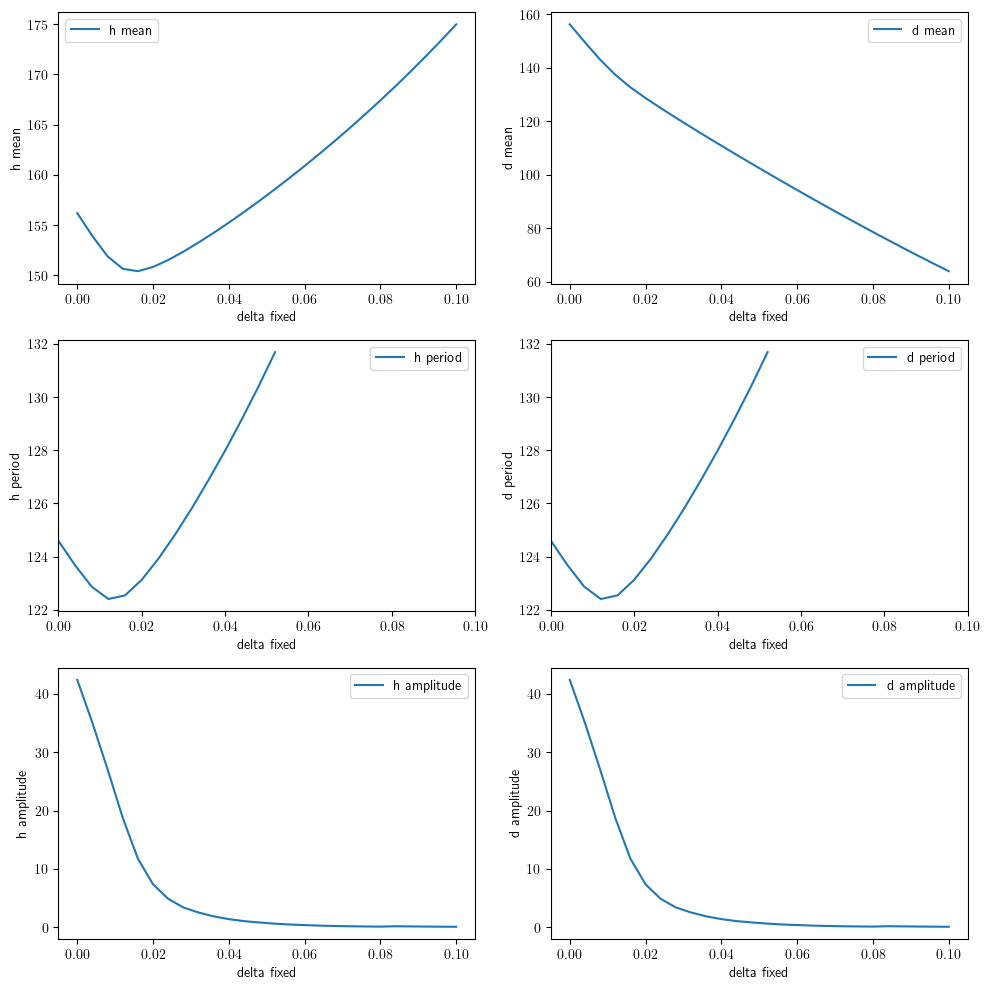

In [5]:
start_time = 2000

h_mean = np.mean(results_fixed[:,start_time:,0], axis=1)
d_mean = np.mean(results_fixed[:,start_time:,2], axis=1)

amplitude_h = np.zeros(len(delta_fixed))
amplitude_d = np.zeros(len(delta_fixed))
period_h = np.zeros(len(delta_fixed))
period_d = np.zeros(len(delta_fixed))

for i in range(len(delta_fixed)):
    amplitude_h[i] = estimate_amplitude_from_peaks(results_fixed[i,start_time:,0])[0]
    amplitude_d[i] = estimate_amplitude_from_peaks(results_fixed[i,start_time:,2])[0]

    amplitude_d = np.nan_to_num(amplitude_d, nan=0.0)  # Handle NaN values
    amplitude_h = np.nan_to_num(amplitude_h, nan=0.0)  # Handle NaN values

    if amplitude_h[i] > 0.5:
        period_h[i] = estimate_period_from_peaks(results_fixed[i,start_time:,0], time = np.arange(num_tsteps-start_time)*dt)[0]
    else:
        period_h[i] = None

    if amplitude_d[i] > 0.5:
        period_d[i] = estimate_period_from_peaks(results_fixed[i,start_time:,2], time = np.arange(num_tsteps-start_time)*dt)[0]
    else:
        period_d[i] = None

print(amplitude_h.shape)
print(amplitude_d)

plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.plot(delta_fixed, h_mean, label='h mean')
plt.xlabel('delta fixed')
plt.ylabel('h mean')   
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(delta_fixed, d_mean, label='d mean')
plt.xlabel('delta fixed')
plt.ylabel('d mean')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(delta_fixed, period_h, label='h period')
plt.xlabel('delta fixed')
plt.xlim(0, max(delta_fixed))
plt.ylabel('h period')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(delta_fixed, period_d, label='d period')
plt.xlabel('delta fixed')
plt.xlim(0, max(delta_fixed))
plt.ylabel('d period')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(delta_fixed, amplitude_h, label='h amplitude')
plt.xlabel('delta fixed')
plt.ylabel('h amplitude')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(delta_fixed, amplitude_d, label='d amplitude')
plt.xlabel('delta fixed')
plt.ylabel('d amplitude')
plt.legend()
plt.tight_layout()

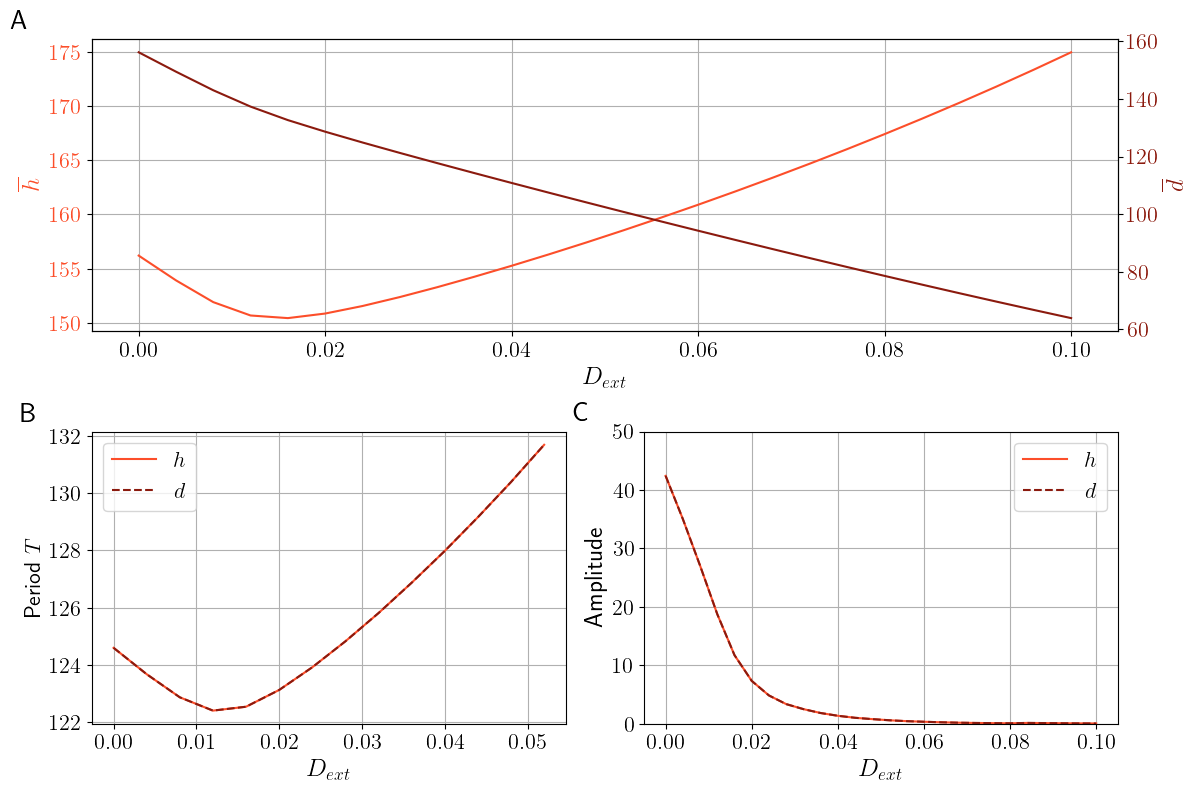

In [103]:
# --------------------------------------
# Create the figure and GridSpec layout
# --------------------------------------
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# ------------------------------------------------------------
# ----------------- Panel A: Top Full Width -----------------
# ------------------------------------------------------------
axA_left = fig.add_subplot(gs[0, :])    # Span both columns

# Plot h_mean on left y-axis
line_h_mean, = axA_left.plot(
    delta_fixed, h_mean, 
    label='h mean',
    color=hescolor2
)

axA_left.set_xlabel(r'$D_{ext}$', fontsize=18)
axA_left.set_ylabel(r'$\overline{h}$', fontsize=18, color=hescolor2)
axA_left.tick_params(axis='y', labelcolor=hescolor2)
axA_left.tick_params(axis='x', labelsize=16)
axA_left.tick_params(axis='y', labelsize=16)
axA_left.grid()
# Right y-axis for d_mean
axA_right = axA_left.twinx()

line_d_mean, = axA_right.plot(
    delta_fixed, d_mean,
    label='d mean',
    color=hescolor3
)

axA_right.set_ylabel(r'$\overline{d}$', fontsize=18, color=hescolor3)
axA_right.tick_params(axis='y', labelcolor=hescolor3)
axA_right.tick_params(axis='y', labelsize=16)

# Combine legends
lines = [line_h_mean, line_d_mean]
labels = [l.get_label() for l in lines]
# axA_left.legend(lines, labels, loc='upper right', fontsize=12)

# Add letter A
axA_left.text(-0.08, 1.1, 'A', transform=axA_left.transAxes,
              fontsize=20, fontweight='bold', va='top')

# ------------------------------------------------------------
# ---------------- Panel B: Bottom Left ---------------------
# ------------------------------------------------------------
axB = fig.add_subplot(gs[1, 0])

axB.plot(delta_fixed, period_h, label=r'$h$', color=hescolor2)
axB.plot(delta_fixed, period_d, label=r'$d$', color=hescolor3, linestyle='--')

axB.set_xlabel(r'$D_{ext}$', fontsize=18)
axB.set_ylabel(r'Period $T$', fontsize=16)
axB.legend(fontsize=16)
axB.grid()
# axB.set_xlim(0, max(delta_fixed))
# axB.set_ylim(110, 130)
axB.tick_params(axis='x', labelsize=16)
axB.tick_params(axis='y', labelsize=16)

# Add letter B
axB.text(-0.15, 1.1, 'B', transform=axB.transAxes,
         fontsize=20, fontweight='bold', va='top')

# ------------------------------------------------------------
# ---------------- Panel C: Bottom Right --------------------
# ------------------------------------------------------------
axC = fig.add_subplot(gs[1, 1])

axC.plot(delta_fixed, amplitude_h, label=r'$h$', color=hescolor2)
axC.plot(delta_fixed, amplitude_d, label=r'$d$', color=hescolor3, linestyle='--')

axC.set_xlabel(r'$D_{ext}$', fontsize=18)
axC.set_ylabel('Amplitude', fontsize=18)
axC.legend(fontsize=16)
axC.grid()
# axC.set_xlim(0, max(delta_fixed))
axC.tick_params(axis='x', labelsize=16)
axC.tick_params(axis='y', labelsize=16)
axC.set_ylim(0, 50)
# Add letter C
axC.text(-0.15, 1.1, 'C', transform=axC.transAxes,
         fontsize=20, fontweight='bold', va='top')

# ------------------------------------------------------------
# Layout adjustments
# ------------------------------------------------------------
plt.tight_layout()
# plt.savefig('delta-bath-fixed.png', dpi=600, bbox_inches='tight')
plt.show()


In [18]:


def equation1(x, gamma_h):
    return gamma_h * x

def equation2(x, gamma_m, p_h, l):
    return gamma_m**(-1) * p_h**l / (p_h**l + x**l)

# Define the difference
def difference(x):
    return equation1(x, 0.03) - equation2(x, 0.03, 100, 5)

# Solve for the root of the difference (i.e., where f1(x) == f2(x))
x_fixed = fsolve(difference, x0=150)[0]  # Initial guess = 1.0
y_fixed = equation1(x_fixed, 0.03)  # or f2(x_cross), they should be equal

# print(f"Intersection point: x = {x_cross}, y = {y_cross}")


In [19]:
cmap = cm.get_cmap('YlGn')
colour = cmap(0.6)
hes_examples = [10, 20]

results_examples= np.zeros((len(hes_examples), num_tsteps, 2))

for i in range(len(hes_examples)):
    T_h = hes_examples[i]  # set the delay in Hes of first cell
    params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = False , grad_coup = False, grad_hes_strength = 0, grad_coup_strength = 0)
    h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
    results_examples[i,:,0] = h[:,0].flatten()
    results_examples[i,:,1] = m_h[:,0].flatten()




C:\Users\kbmcd\AppData\Local\Temp\ipykernel_2764\3571605229.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('YlGn')
100%|██████████| 19999/19999 [00:03<00:00, 6195.59it/s]


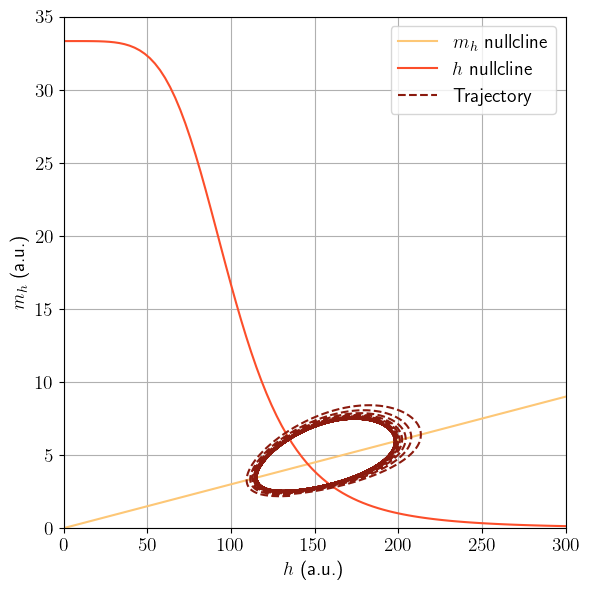

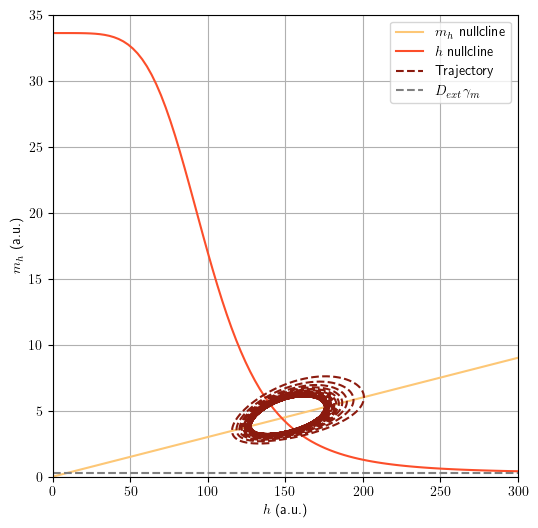

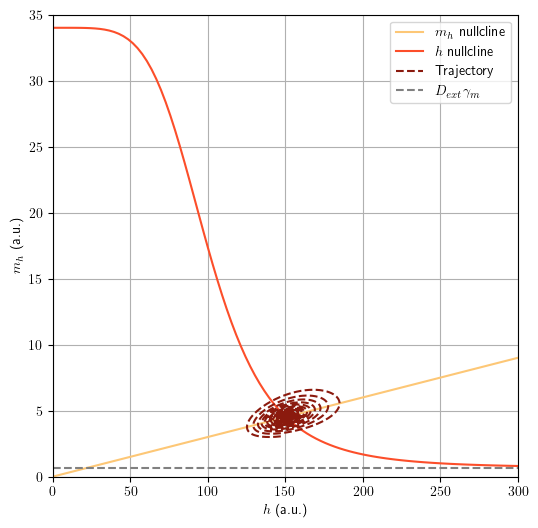

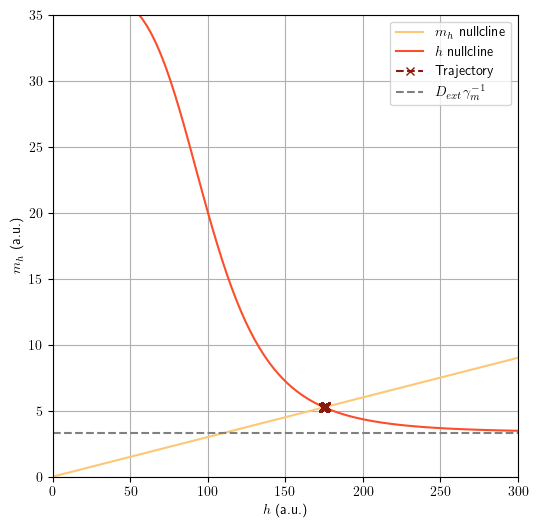

In [ ]:
def nullclines_Hes(m_h, h, p_h, l, gamma_h, gamma_m):
    """Calculate the nullclines for Hes."""
    # Hes protein nullcline
    h_null = gamma_h**(-1)*m_h
    
    # Hes mRNA nullcline
    m_h_null = gamma_m**(-1) * p_h**l / (p_h**l + h**l)

    return h_null, m_h_null

def nullclines_Hes_deltabath(m_h, h, D_ext, p_h, l, gamma_h, gamma_m):
    """Calculate the nullclines for Hes."""
    # Hes protein nullcline
    h_null = gamma_h**(-1)*m_h
    
    # Hes mRNA nullcline
    m_h_null = gamma_m**(-1) * p_h**l / (p_h**l + h**l) + gamma_m**(-1)*D_ext

    return h_null, m_h_null

p_h = 100
l = 5
gamma_h = 0.03
gamma_m = 0.03

D_ext_0 = 0.008
D_ext_1 = 0.02 # external delta concentration
D_ext_2 = 0.1


m_h_plot = np.linspace(0, 50, 100)*1


h_plot = np.linspace(0, 300, 100)*1


# Calculate nullclines
h_null_plot, m_h_null_plot = nullclines_Hes(m_h_plot, h_plot, p_h, l, gamma_h, gamma_m)

h_null_ext_0, m_h_null_ext_0 = nullclines_Hes_deltabath(m_h_plot, h_plot, D_ext_0, p_h, l, gamma_h, gamma_m)
h_null_ext_1, m_h_null_ext_1 = nullclines_Hes_deltabath(m_h_plot, h_plot, D_ext_1, p_h, l, gamma_h, gamma_m)
h_null_ext_2, m_h_null_ext_2 = nullclines_Hes_deltabath(m_h_plot, h_plot, D_ext_2, p_h, l, gamma_h, gamma_m)
# m_h_null_ext_2, h_null_ext_2 = nullclines_Hes_deltabath(m_h_plot, h_plot, D_ext_2, p_h, l, gamma_h, gamma_m)

hescolor1 = '#fdc776'  # light
hescolor2 = '#fc4e2a'  # dark
hescolor3 = '#8b1a0e'  # dark red with a warm tone

meshgrid shapes: (25, 25) (25, 25)
(25, 25)
(25, 25)


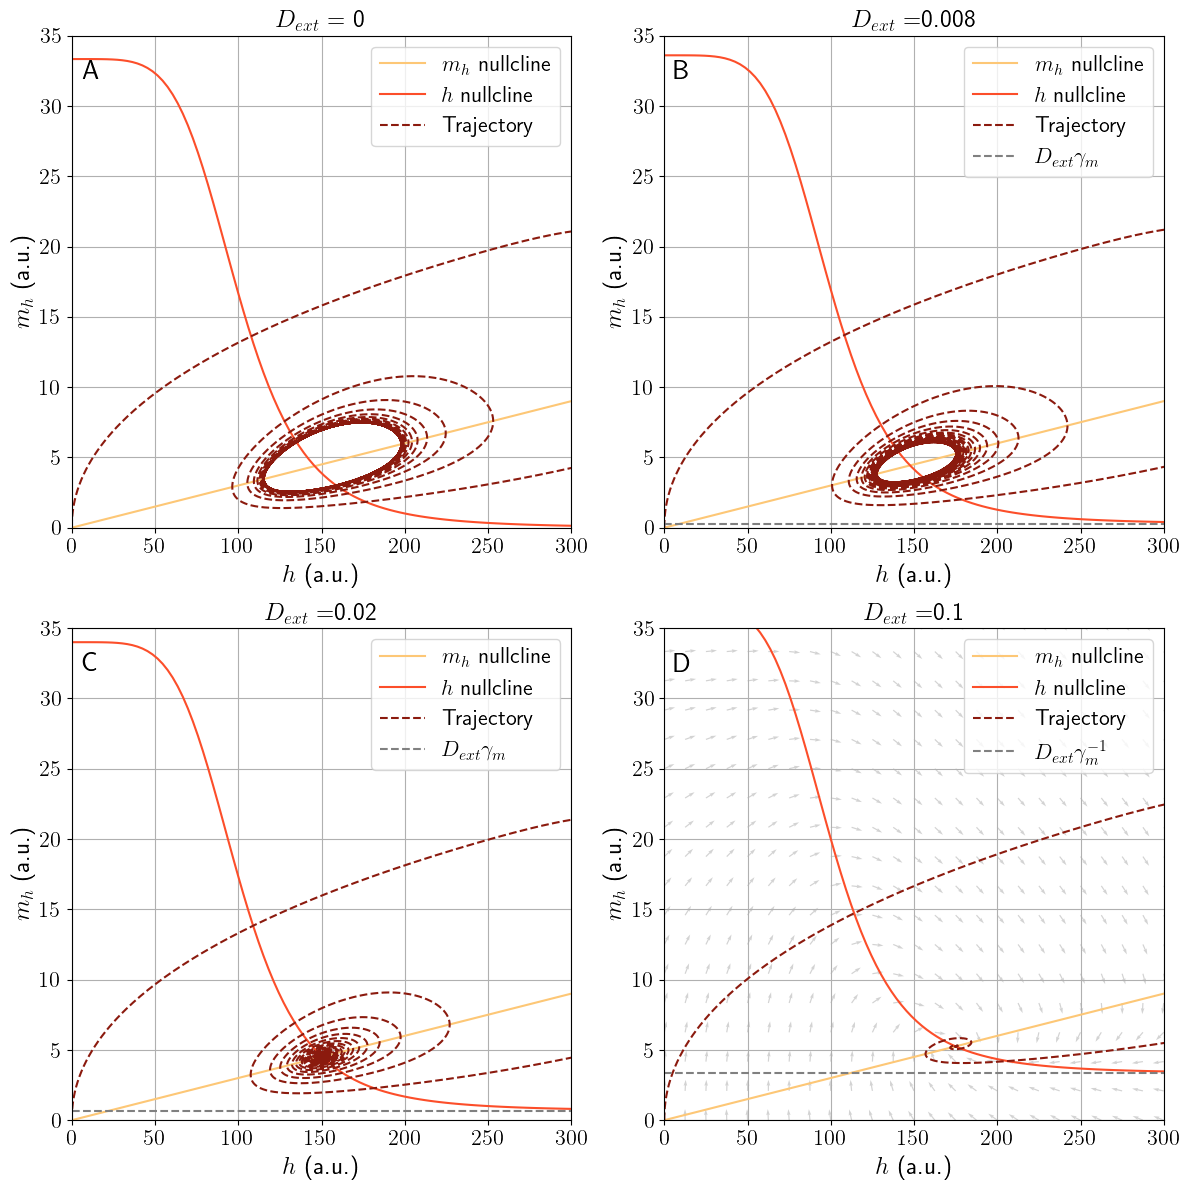

In [18]:
h = np.linspace(0, 300, 25)
m = np.linspace(0, 50, 25)

H, M = np.meshgrid(h, m)
print('meshgrid shapes:', H.shape, M.shape) 

# Define vector field components (U, V)
U = dh_dt(H, M, params) # x-component of vectors
print(U.shape)
V = dmh_dt(M, H, D_ext_2/w_coupling, params, lattice) /gamma_m # y-component of vectors
print(V.shape)

# Normalize the vectors to unit magnitude
magnitude = np.sqrt(U**2 + V**2)
# Avoid division by zero
magnitude[magnitude == 0] = 1  
U_normalized = U / magnitude
V_normalized = V / magnitude

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Letters to annotate subplots
letters = ['A', 'B', 'C', 'D']

# --------- First subplot ---------
ax = axs[0, 0]
ax.plot(h_null_plot, m_h_plot,  label=r'$m_h$ nullcline', color = hescolor1)
ax.plot(h_plot, m_h_null_plot,  label=r'$h$ nullcline', color = hescolor2)
ax.plot(results_fixed[0, :, 0], results_fixed[0, :, 1], 
        ls = '--', label = 'Trajectory', color = hescolor3)
ax.set_xlabel(r'$h$ (a.u.)', fontsize=18)
ax.set_ylabel(r'$m_h$ (a.u.)', fontsize=18)
ax.set_xlim(0, 300)
ax.set_ylim(0, 35)
ax.grid()
ax.tick_params(labelsize=16)
ax.legend(fontsize=16)
ax.set_title(r'$D_{ext}$ = 0', fontsize=18)
ax.text(0.02, 0.95, letters[0], transform=ax.transAxes,
        fontsize=20, fontweight='bold', va='top', ha='left')

# --------- Second subplot ---------
ax = axs[0, 1]
ax.plot(h_null_ext_0, m_h_plot,  label=r'$m_h$ nullcline', color = hescolor1)
ax.plot(h_plot, m_h_null_ext_0,  label=r'$h$ nullcline', color = hescolor2)
ax.plot(results_fixed[2, :, 0], results_fixed[2, :, 1], 
        ls = '--', label = 'Trajectory', color = hescolor3)
ax.axhline(D_ext_0/gamma_m, ls='--', color='gray', label=r'$D_{ext}\gamma_m$')
ax.set_xlabel(r'$h$ (a.u.)', fontsize=18)
ax.set_ylabel(r'$m_h$ (a.u.)', fontsize=18)
ax.set_xlim(0, 300)
ax.set_ylim(0, 35)
ax.grid()
ax.tick_params(labelsize=16)
ax.legend(fontsize=16)
ax.set_title(r'$D_{ext}$ =' + str(delta_fixed[2]), fontsize=18)
ax.text(0.02, 0.95, letters[1], transform=ax.transAxes,
        fontsize=20, fontweight='bold', va='top', ha='left')

# --------- Third subplot ---------
ax = axs[1, 0]
ax.plot(h_null_ext_1, m_h_plot,  label=r'$m_h$ nullcline', color = hescolor1)
ax.plot(h_plot, m_h_null_ext_1,  label=r'$h$ nullcline', color = hescolor2)
ax.plot(results_fixed[5, :, 0], results_fixed[5, :, 1], 
        ls = '--', label = 'Trajectory', color = hescolor3)
ax.axhline(D_ext_1/gamma_m, ls='--', color='gray', label=r'$D_{ext}\gamma_m$')
ax.set_xlabel(r'$h$ (a.u.)', fontsize=18)
ax.set_ylabel(r'$m_h$ (a.u.)', fontsize=18)
ax.set_xlim(0, 300)
ax.set_ylim(0, 35)
ax.grid()
ax.tick_params(labelsize=16)
ax.legend(fontsize=16)
ax.set_title(r'$D_{ext}$ =' + str(delta_fixed[5]), fontsize=18)
ax.text(0.02, 0.95, letters[2], transform=ax.transAxes,
        fontsize=20, fontweight='bold', va='top', ha='left')

# --------- Fourth subplot ---------
ax = axs[1, 1]
ax.plot(h_null_ext_2, m_h_plot,  label=r'$m_h$ nullcline', color = hescolor1)
ax.plot(h_plot, m_h_null_ext_2,  label=r'$h$ nullcline', color = hescolor2)
ax.plot(results_fixed[-1, :, 0], results_fixed[-1, :, 1], 
        ls = '--', label = 'Trajectory', color = hescolor3)
ax.axhline(D_ext_2/gamma_m, ls='--', color='gray', label=r'$D_{ext}\gamma_m^{-1}$')
ax.quiver(H, M, U_normalized, V_normalized, color='lightgray', label='')
ax.set_xlabel(r'$h$ (a.u.)', fontsize=18)
ax.set_ylabel(r'$m_h$ (a.u.)', fontsize=18)
ax.set_xlim(0, 300)
ax.set_ylim(0, 35)
ax.grid()
ax.tick_params(labelsize=16)
ax.legend(fontsize=16)
ax.set_title(r'$D_{ext}$ =' + str(delta_fixed[-1]), fontsize=18)
ax.text(0.02, 0.95, letters[3], transform=ax.transAxes,
        fontsize=20, fontweight='bold', va='top', ha='left')

plt.tight_layout()

# Optional save
# plt.savefig('delta-bath-fixed-limit-cycles.png', dpi=600)

plt.show()


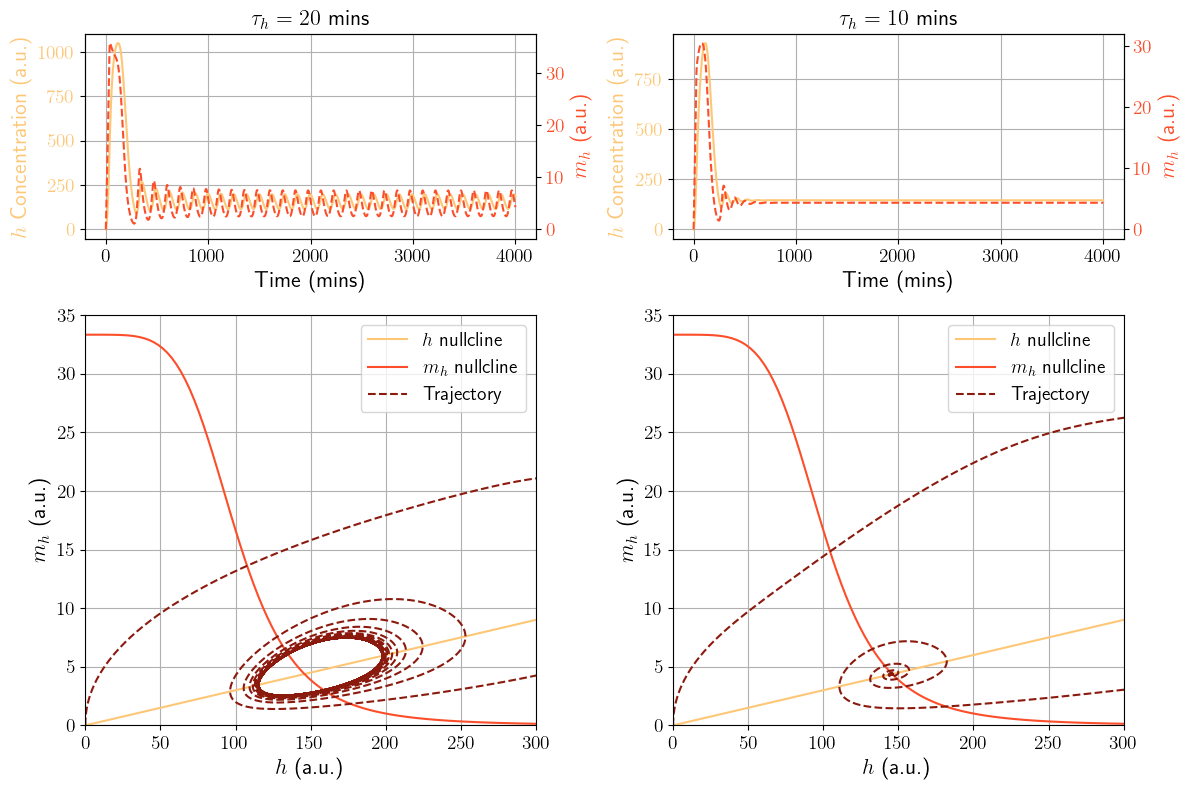

In [25]:
fig = plt.figure(figsize=(12, 8))

# Create a 2x2 grid with custom height ratios
gs = GridSpec.GridSpec(2, 2, height_ratios=[1, 2], figure=fig)

# --- Subplot 1 ---
ax1 = fig.add_subplot(gs[0, 0])
t = np.arange(0, num_tsteps * dt, dt)

# Primary y-axis (h)
ax1.plot(t, results_examples[1, :, 0], color=hescolor1, label=r'$h$')
ax1.set_xlabel(r'Time (mins)', fontsize=16)
ax1.set_ylabel(r'$h$ Concentration (a.u.)', fontsize=16, color=hescolor1)
ax1.tick_params(axis='y', labelcolor=hescolor1)
ax1.grid()
ax1.set_title(r'$\tau_h = 20$ mins', fontsize=16)
ax1.tick_params(labelsize=14)

# Secondary y-axis (m_h)
ax1b = ax1.twinx()
ax1b.plot(t, results_examples[1, :, 1], color=hescolor2, linestyle='--', label=r'$m_h \cdot 10$')
ax1b.set_ylabel(r'$m_h$ (a.u.)', fontsize=16, color=hescolor2)
ax1b.tick_params(axis='y', labelcolor=hescolor2)
ax1b.tick_params(labelsize=14)

# --- Subplot 2 ---
ax2 = fig.add_subplot(gs[0, 1])
# Primary y-axis (h)
ax2.plot(t, results_examples[0, :, 0], color=hescolor1, label=r'$h$')
ax2.set_xlabel(r'Time (mins)', fontsize=16)
ax2.set_ylabel(r'$h$ Concentration (a.u.)', fontsize=16, color=hescolor1)
ax2.tick_params(axis='y', labelcolor=hescolor1)
ax2.grid()
ax2.set_title(r'$\tau_h = 10$ mins', fontsize=16)
ax2.tick_params(labelsize=14)

# Secondary y-axis (m_h)
ax2b = ax2.twinx()
ax2b.plot(t, results_examples[0, :, 1], color=hescolor2, linestyle='--', label=r'$m_h \cdot 10$')
ax2b.set_ylabel(r'$m_h $ (a.u.)', fontsize=16, color=hescolor2)
ax2b.tick_params(axis='y', labelcolor=hescolor2)
ax2b.tick_params(labelsize=14)

# Bottom-left (wider)
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(h_null_plot, m_h_plot,  label=r'$h$ nullcline', color = hescolor1)
ax3.plot(h_plot, m_h_null_plot,  label=r'$m_h$ nullcline', color = hescolor2)
ax3.plot(results_fixed[0, :, 0], results_fixed[0, :, 1], ls = '--', label = 'Trajectory', color = hescolor3)
ax3.set_xlabel(r'$h$ (a.u.)', fontsize=16)
ax3.set_ylabel(r'$m_h$ (a.u.)', fontsize=16)
ax3.set_xlim(0, 300)
ax3.set_ylim(0, 35)
ax3.grid()
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax3.legend(fontsize=14)

# Bottom-right (wider)
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(h_null_plot, m_h_plot,  label=r'$h$ nullcline', color = hescolor1)
ax4.plot(h_plot, m_h_null_plot,  label=r'$m_h$ nullcline', color = hescolor2)
ax4.plot(results_examples[0, :, 0], results_examples[0,:,1], color=hescolor3, ls = '--', label = 'Trajectory')
ax4.set_xlabel(r'$h$ (a.u.)', fontsize=16)
ax4.set_ylabel(r'$m_h$ (a.u.)', fontsize=16)
ax4.set_xlim(0, 300)
ax4.set_ylim(0, 35)
ax4.grid()
ax4.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='y', labelsize=14)
ax4.legend(fontsize=14)

plt.tight_layout()
plt.savefig('single_cell_examples.png', dpi=600)


### Plotting the vector field

namespace(gamma_h=0.03, gamma_d=0.03, gamma_m=0.03, p_h=100, p_d=50, T_h=array([0., 0., 0.]), T_coupling=array([0., 0., 0.]), w_h=1, w_coupling=1, l=5, n=3, grad_hes=False, grad_coup=False, grad_hes_strength=0, grad_coup_strength=0, T_h_steps=array([100, 100, 100]), T_coup_steps=array([0, 0, 0]))
meshgrid shapes: (25, 25) (25, 25)
(25, 25)
(25, 25)


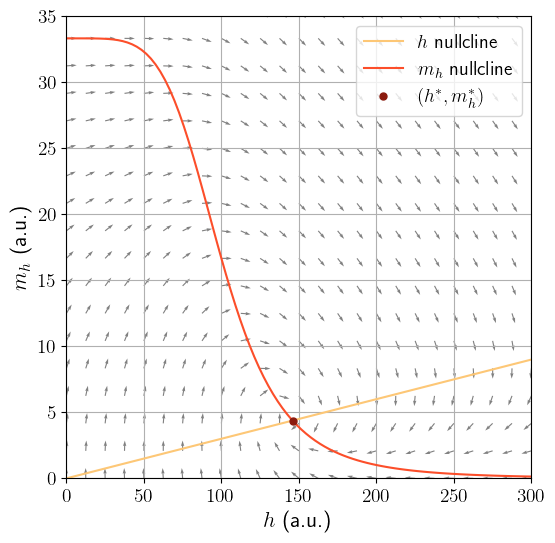

In [26]:

h = np.linspace(0, 300, 25)
m = np.linspace(0, 50, 25)
h_null_plot, m_h_null_plot = nullclines_Hes(m_h_plot, h_plot, p_h, l, gamma_h, gamma_m)

params.T_h = np.zeros_like(params.T_h)  # Set T_h to zero for the vector field
print(params)
H, M = np.meshgrid(h, m)
print('meshgrid shapes:', H.shape, M.shape) 

# Define vector field components (U, V)
U = dh_dt(H, M, params) # x-component of vectors
print(U.shape)
V = dmh_dt(M, H, 0, params, lattice) /gamma_m # y-component of vectors
print(V.shape)

# Normalize the vectors to unit magnitude
magnitude = np.sqrt(U**2 + V**2)
# Avoid division by zero
magnitude[magnitude == 0] = 1  
U_normalized = U / magnitude
V_normalized = V / magnitude

# Create the plot
plt.figure(figsize=(6, 6))
plt.quiver(H, M, U_normalized, V_normalized, color='gray')
plt.plot(h_null_plot, m_h_plot,  label=r'$h$ nullcline', color = hescolor1)
plt.plot(h_plot, m_h_null_plot,  label=r'$m_h$ nullcline', color = hescolor2)
plt.plot(x_fixed, y_fixed, marker = 'o', ls = 'None', color = hescolor3, label=r'$(h^*, m_h^*)$', markersize=5)
plt.xlabel(r'$h$ (a.u.)', fontsize=16)
plt.ylabel(r'$m_h$ (a.u.)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.xlim(0, 300)
plt.ylim(0, 35)
plt.grid(True)
# plt.savefig('single-cell-stability-vector-field.png', dpi=600)
plt.show()

namespace(gamma_h=0.03, gamma_d=0.03, gamma_m=0.03, p_h=100, p_d=50, T_h=array([0., 0., 0.]), T_coupling=array([0., 0., 0.]), w_h=1, w_coupling=1, l=5, n=3, grad_hes=False, grad_coup=False, grad_hes_strength=0, grad_coup_strength=0, T_h_steps=array([100, 100, 100]), T_coup_steps=array([0, 0, 0]))
meshgrid shapes: (25, 25) (25, 25)
(25, 25)
(25, 25)


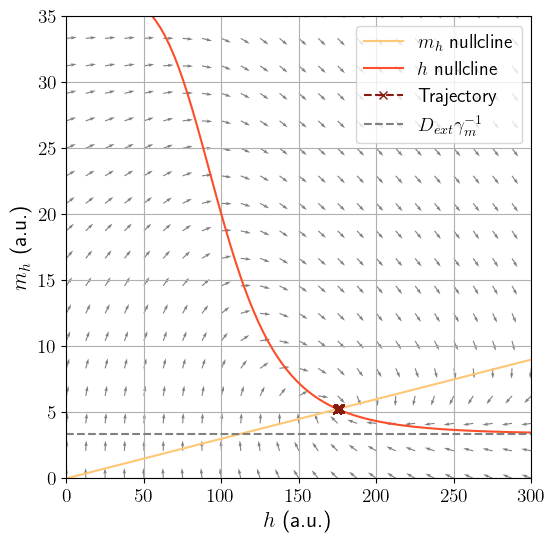

In [28]:
h = np.linspace(0, 300, 25)
m = np.linspace(0, 50, 25)
h_null_plot, m_h_null_plot = nullclines_Hes(m_h_plot, h_plot, p_h, l, gamma_h, gamma_m)

params.T_h = np.zeros_like(params.T_h)  # Set T_h to zero for the vector field
print(params)
H, M = np.meshgrid(h, m)
print('meshgrid shapes:', H.shape, M.shape) 

# Define vector field components (U, V)
U = dh_dt(H, M, params) # x-component of vectors
print(U.shape)
V = dmh_dt(M, H, D_ext_2/w_coupling, params, lattice) /gamma_m # y-component of vectors
print(V.shape)

# Normalize the vectors to unit magnitude
magnitude = np.sqrt(U**2 + V**2)
# Avoid division by zero
magnitude[magnitude == 0] = 1  
U_normalized = U / magnitude
V_normalized = V / magnitude

# Create the plot
plt.figure(figsize=(6, 6))
plt.quiver(H, M, U_normalized, V_normalized, color='gray')
plt.plot(h_null_ext_2, m_h_plot,  label=r'$m_h$ nullcline', color = hescolor1)
plt.plot(h_plot, m_h_null_ext_2,  label=r'$h$ nullcline', color = hescolor2)
plt.plot(results_fixed[-1, start_time:, 0], results_fixed[-1, start_time:, 1], ls = '--', marker = 'x', label = 'Trajectory', color = hescolor3)
plt.axhline(D_ext_2/gamma_m, ls='--', color='gray', label=r'$D_{ext}\gamma_m^{-1}$')
plt.xlabel(r'$h$ (a.u.)', fontsize=16)
plt.ylabel(r'$m_h$ (a.u.)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.xlim(0, 300)
plt.ylim(0, 35)
plt.grid(True)
# plt.savefig('delta-bath-strong-vector-field.png', dpi=600)
plt.show()

## Oscillating Delta bath

In [11]:
#set the lattice of the cells 
P = 3
Q = 1

lattice = get_lattice(P, Q)

# set initial parameters of the reactions 
gamma_h = 0.03
gamma_d = 0.03
gamma_m = 0.03
p_h = 100
p_d = 50
T_h = 20
T_coupling = 0
w_h = 1
w_coupling = 0.5
l = 5
n = 3

params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)
print(params)


num_tsteps = 20000
dt = 0.2

namespace(gamma_h=0.03, gamma_d=0.03, gamma_m=0.03, p_h=100, p_d=50, T_h=array([20., 20., 20.]), T_coupling=array([0., 0., 0.]), w_h=1, w_coupling=0.5, l=5, n=3, grad_hes=False, grad_coup=False, grad_hes_strength=0.2, grad_coup_strength=0)


In [52]:
# set aspects of the delta oscillator
delta_period = 80

delta_exp_level = 0.01
delta_amplitude = 0.01

num_tsteps = 40000
dt = 0.2

delta_oscillator = np.sin(np.arange(num_tsteps) * dt * 2 * np.pi / delta_period) * delta_amplitude + delta_exp_level

# create the delta oscillator


### Run for oscillating delta

In [13]:

delta_periods = [60, 70, 80, 90, 100, 120, 125, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 155, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]
delays = [0, 1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 50]
results_oscillating = np.zeros((len(delta_periods), len(delays), num_tsteps, 2))

for i, delta_period in enumerate(delta_periods):
    for j, delay in enumerate(delays):
        print(f"Evaluating delta period {delta_period} with delay {delay}")
        delta_oscillator = np.sin(np.arange(num_tsteps) * dt * 2 * np.pi / delta_period) * delta_amplitude + delta_exp_level
        h, m_h, d, m_d = evaluate_oscillating_delta(num_tsteps, dt, delta_oscillator, delay, lattice, params)

        results_oscillating[i,j,:,0] = h[:,1].flatten()
        results_oscillating[i,j,:,1] = d[:,1].flatten()

    # plt.figure(figsize=(10, 5))
    # plt.plot(delta_oscillator, label='Delta oscillator')
    # plt.plot(h[:,1], label='h 0')
    # plt.plot(d[:,1], label='d 0')
    # plt.title(f'Delta Period: {delta_period}')
    # plt.xlabel('Time Steps')
    # plt.ylabel('Signal Value')
    # plt.legend()
    # plt.show()

Evaluating delta period 60 with delay 0


100%|██████████| 39999/39999 [00:08<00:00, 4618.32it/s]


Evaluating delta period 60 with delay 1


100%|██████████| 39999/39999 [00:08<00:00, 4535.18it/s]


Evaluating delta period 60 with delay 2


100%|██████████| 39999/39999 [00:12<00:00, 3232.41it/s]


Evaluating delta period 60 with delay 5


 47%|████▋     | 18894/39999 [00:06<00:07, 2730.68it/s]


KeyboardInterrupt: 

In [93]:
with open('results_oscillating_0.01.pickle', 'wb') as f:
    pickle.dump(results_oscillating, f)

### Load in data 

In [22]:
delta_periods = [60, 70, 80, 90, 100, 120, 125, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 155, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]
delays = [0, 1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 50]

with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_oscillating_0.05.pickle', 'rb') as f:
    results_oscillating_strong = pickle.load(f)

with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_oscillating_0.01.pickle', 'rb') as f:
    results_oscillating_weak = pickle.load(f)

### Plot all variants of loaded data 

In [62]:
# for i in range(len(delta_periods)):
#     plt.figure(figsize=(20,5))
#     for j in range(len(delays/2)):
#         plt.subplot(2, len(delays)//2, j+1)
#         plt.plot(results_oscillating_strong[i,j,:,0], label='h 0')
#         plt.plot(external_delta_oscillator(num_tsteps, dt, delta_periods[i], 0.05), label='Delta oscillator')
#         plt.title(f'Delta Period: {delta_periods[i]}, Delay: {delays[j]}')
#         plt.xlabel('Time Steps')
#         plt.ylabel('Signal Value')
#         plt.legend()
#         plt.show()

# for i in range(len(delta_periods)):
#     plt.figure(figsize=(20, 5))
#     external = external_delta_oscillator(num_tsteps, dt, delta_periods[i], 0.05)
#     for j in range(len(delays)//2):  # integer division to avoid float index error
#         plt.subplot(2, len(delays)//2, j + 1)
        
#         # Primary axis
#         ax1 = plt.gca()
#         ax1.plot(results_oscillating_strong[i, j, :, 0], label='h 0', color='tab:blue')
#         ax1.set_xlabel('Time Steps')
#         ax1.set_ylabel('Signal Value (h 0)', color='tab:blue')
#         ax1.tick_params(axis='y', labelcolor='tab:blue')
        
#         # Secondary axis
#         ax2 = ax1.twinx()
#         ax2.plot(np.arange(num_tsteps)*dt, external_delta_oscillator(num_tsteps, dt, delta_periods[i], 0.05), label='Delta oscillator', color='tab:red', linestyle='--')
#         ax2.set_ylabel('Delta Oscillator', color='tab:red')
#         ax2.tick_params(axis='y', labelcolor='tab:red')

#         plt.title(f'Delta Period: {delta_periods[i]}, Delay: {delays[j]}')
    
#     plt.tight_layout()
#     plt.show()

In [23]:
print(delta_periods)

[60, 70, 80, 90, 100, 120, 125, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 155, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]


C:\Users\kbmcd\AppData\Local\Temp\ipykernel_15672\3872273401.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('YlGn')


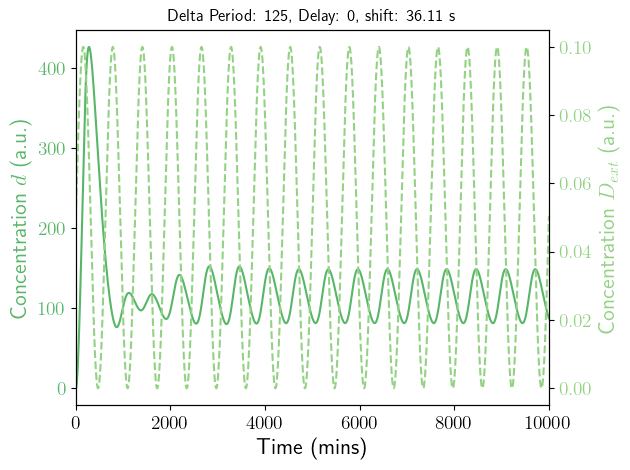

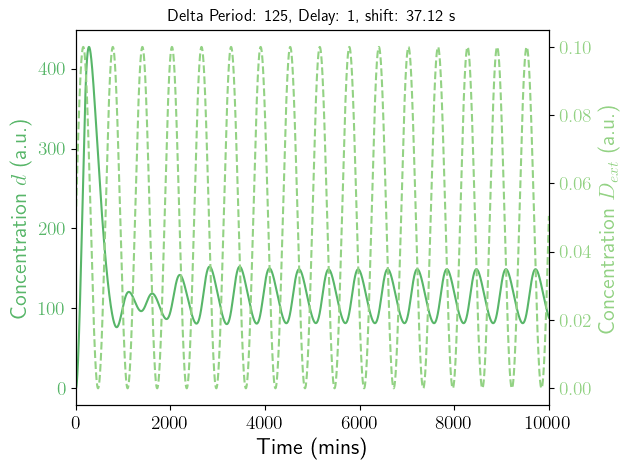

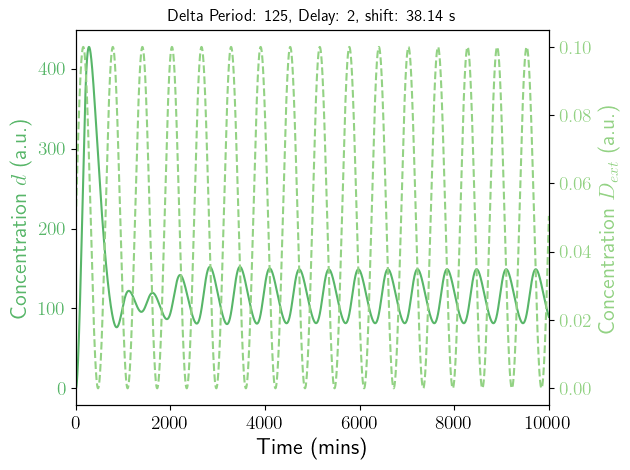

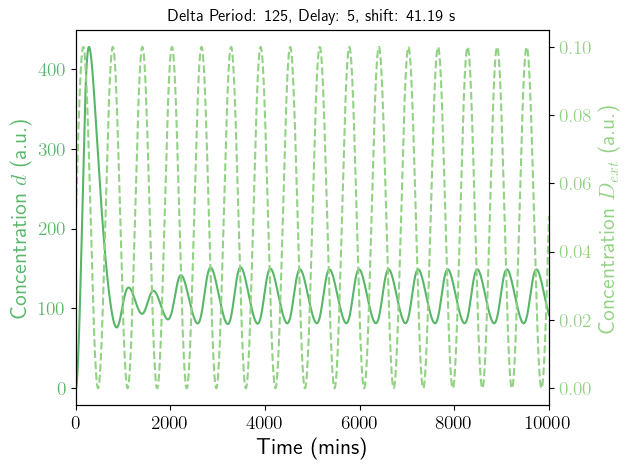

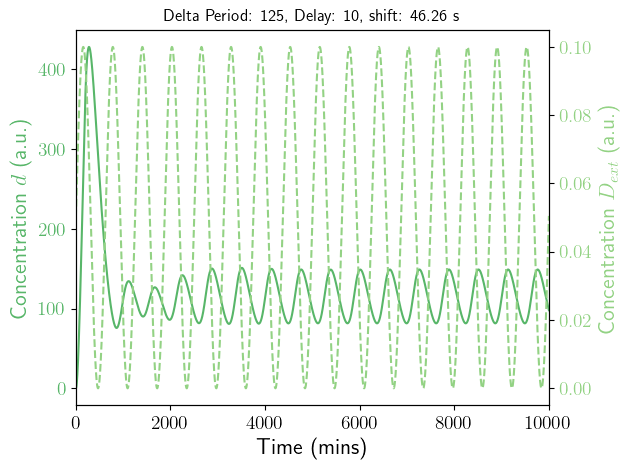

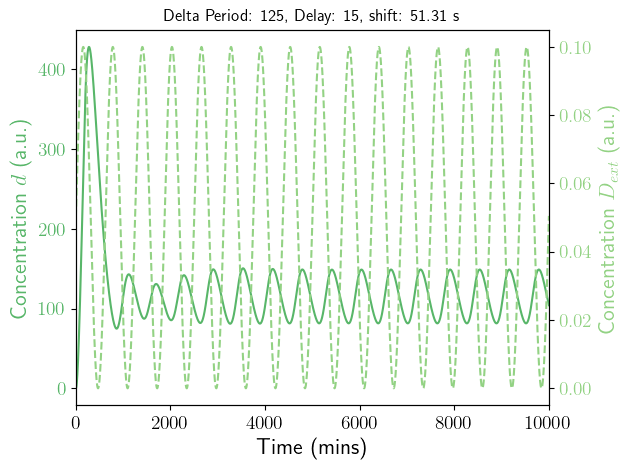

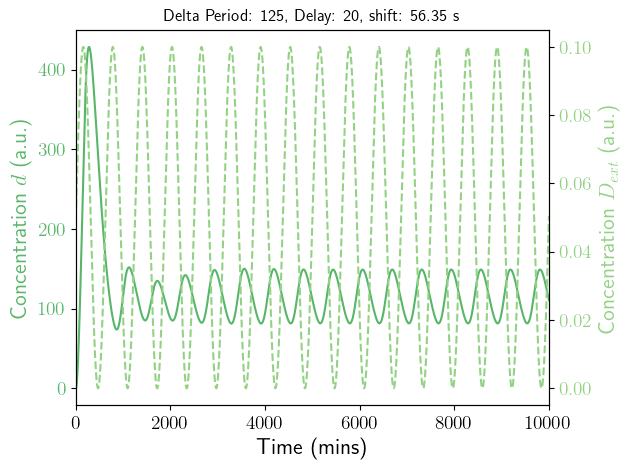

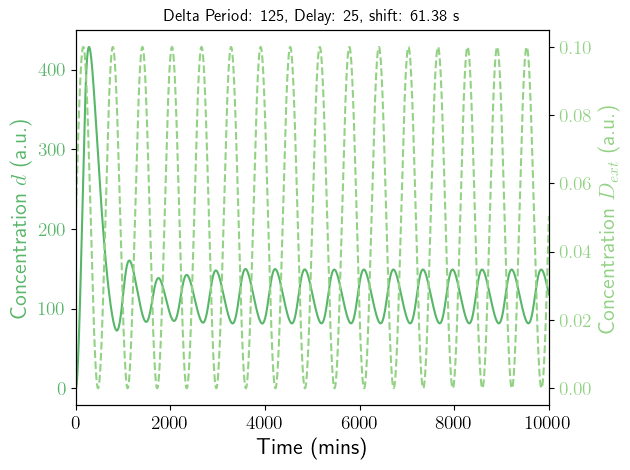

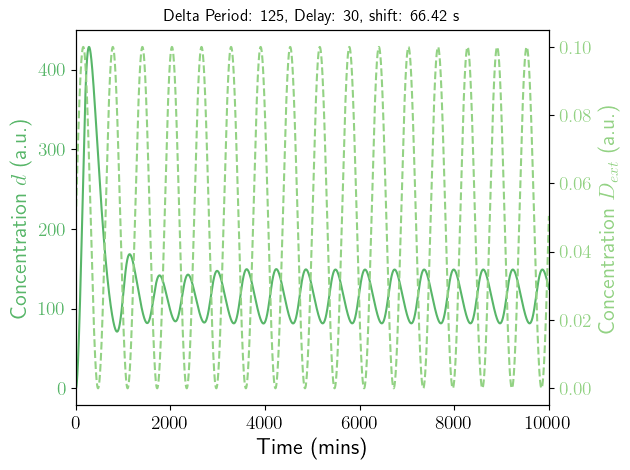

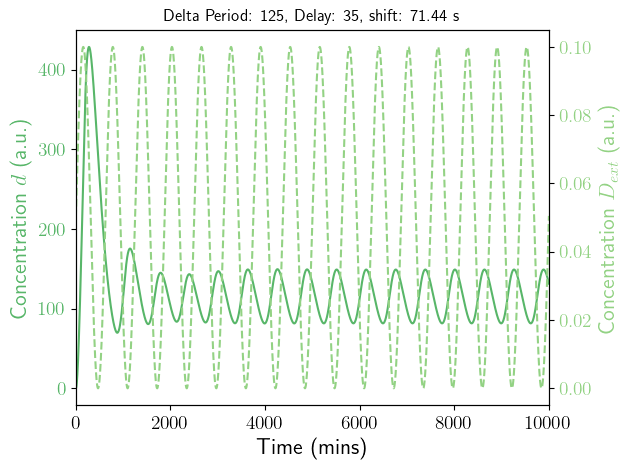

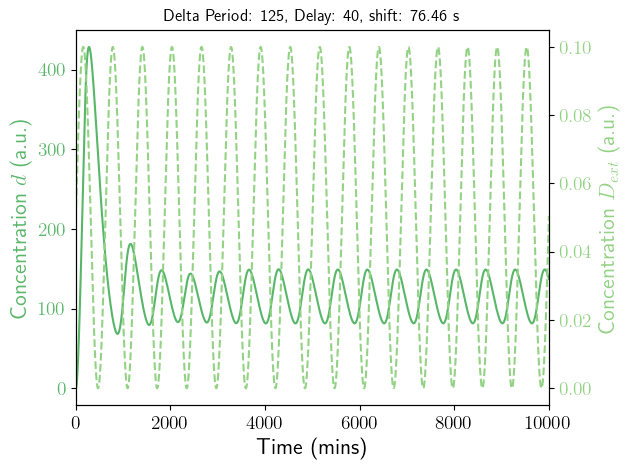

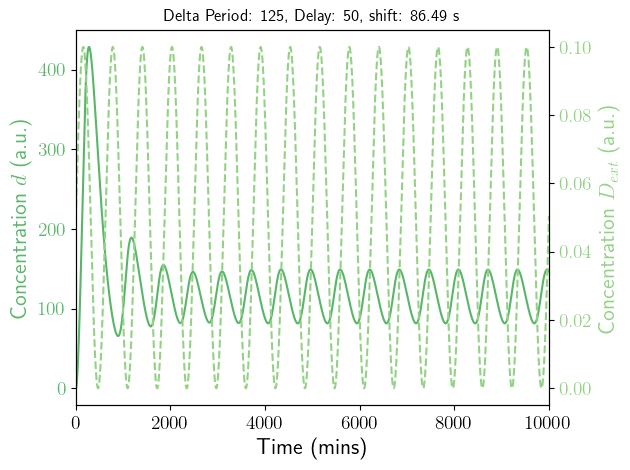

In [26]:
i = 6

external = external_delta_oscillator(num_tsteps, dt, delta_periods[i], 0.05)
colours = get_distinguishable_ylgn_colors(len(delays))
for j in range(len(delays)):  # integer division to avoid float index error
    period, peaks_external = estimate_period_from_peaks(external[start_time:], time=np.arange(num_tsteps-start_time)*dt)
    period, peaks_internal = estimate_period_from_peaks(results_oscillating_strong[i,j,start_time:,1], time=np.arange(num_tsteps-start_time)*dt)
    shift = find_shift(peaks_external/dt, peaks_internal/dt)

    plt.figure()
    # Primary axis
    ax1 = plt.gca()
    ax1.plot(results_oscillating_strong[i, j, :, 1], label='D0', color=colours[6])
    # ax1.axvline(peaks_internal[0]/dt+start_time, color='gray', linestyle='--')
    ax1.set_xlabel('Time (mins)', fontsize=16)
    ax1.set_ylabel(r'Concentration $d$ (a.u.)', color=colours[6], fontsize=16)
    ax1.tick_params(axis='y', labelcolor=colours[6], labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    
    # Secondary axis
    ax2 = ax1.twinx()
    ax2.plot(np.arange(num_tsteps), external_delta_oscillator(num_tsteps, dt, delta_periods[i], 0.05), label='Delta oscillator', color=colours[3], linestyle='--')
    # ax2.axvline(peaks_external[0]/dt+start_time, color='black', linestyle='--')
    ax2.set_ylabel(r'Concentration $D_{ext}$ (a.u.)', color=colours[3], fontsize=16)
    ax2.tick_params(axis='y', labelcolor=colours[3], labelsize=14)
    

    plt.title(f'Delta Period: {delta_periods[i]}, Delay: {delays[j]}, shift: {shift:.2f} s')
    plt.tight_layout()
    plt.xlim(0, 10000)
    if j == 0 or j == 8:
        plt.savefig(f'delta_bath_example_delay_{delays[j]}_period_{delta_periods[i]}.png', dpi=600)

ValueError: x and y must have same first dimension, but have shapes (40000,) and (20000,)

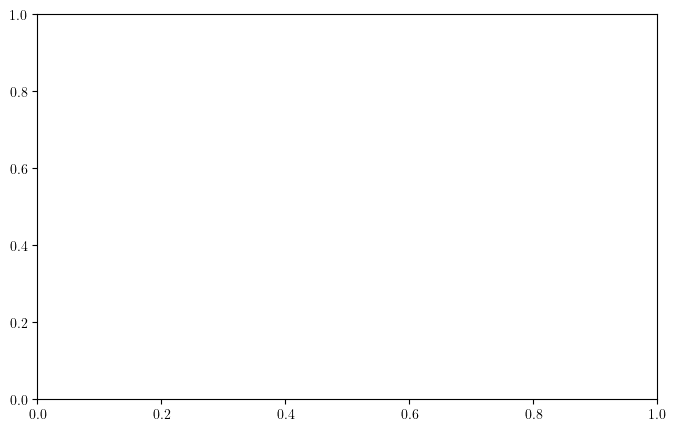

In [63]:
i = 6

j0 = 0
j8 = 8

# Time axis
time_minutes = np.arange(num_tsteps) * dt

# Data
d_j0 = results_oscillating_strong[i, j0, :, 1]
d_j8 = results_oscillating_strong[i, j8, :, 1]
external_signal = external_delta_oscillator(num_tsteps, dt, delta_periods[i], 0.05)

# Create figure
fig, ax1 = plt.subplots(figsize=(8,5))

# Plot d for j=0 (solid line, optionally fill under curve)
ax1.plot(time_minutes, d_j0, label=fr'$\tau_d$={delays[j0]} min', color=colours[6])
# ax1.fill_between(time_minutes, d_j0, color=colours[6], alpha=0.2)

# Plot d for j=8 (dashed line)
ax1.plot(time_minutes, d_j8, label=fr'$\tau_d$={delays[j8]} min', color=colours[6], linestyle='--')

# Axis styling
ax1.set_xlabel('Time (mins)', fontsize=16)
ax1.set_ylabel(r'Concentration $d$ (a.u.)', fontsize=16, color=colours[6])
ax1.tick_params(axis='y', labelcolor=colours[6], labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

# Secondary axis
ax2 = ax1.twinx()
ax2.plot(time_minutes, external_signal, label='External', color=colours[3], linestyle='-')
ax2.set_ylabel(r'Concentration $D_{ext}$ (a.u.)', fontsize=16, color=colours[3])
ax2.tick_params(axis='y', labelcolor=colours[3], labelsize=14)
# ax2.set_ylim(0, 0.2)  # Limit y-axis for clarity
# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, fontsize=14, loc='upper right')

# Title
# ax1.set_title(f'Delta Period: {delta_periods[i]}', fontsize=16)

ax1.set_xlim(0, 2000)  # Limit x-axis to first 10000 time steps


plt.tight_layout()

# Optional save
#plt.savefig('combined_d_and_delta_plot.png', dpi=600)

plt.show()


### Analysing oscillating data

In [25]:
def get_distinguishable_ylgn_colors(k, min_val=0.3, max_val=0.8):
    """
    Returns k distinguishable colors from the 'YlGn' colormap,
    avoiding very light (near white) colors for better contrast on white backgrounds.

    Parameters:
    - k: Number of colors.
    - min_val: Minimum position in the colormap (0 = lightest, 1 = darkest).
    - max_val: Maximum position in the colormap.
    """
    assert 0 <= min_val < max_val <= 1, "min_val and max_val must be in (0, 1]"
    cmap = cm.get_cmap('YlGn')
    values = np.linspace(min_val, max_val, k)
    colors = [cmap(v) for v in values]
    return colors

100%|██████████| 39999/39999 [00:05<00:00, 7994.34it/s]


[20. 20. 20.]
Uncoupled period: 125.23174603174606


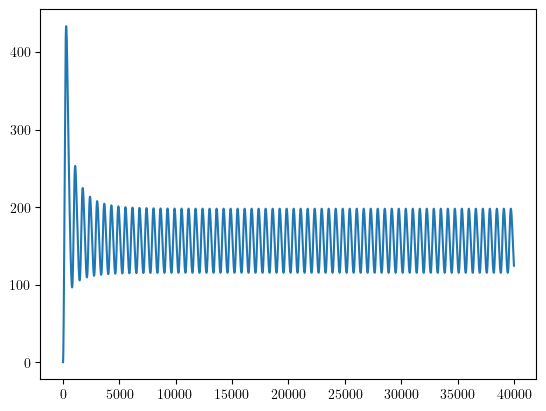

In [47]:
delta_uncoupled = 0 
w_coupling = 0.5
h, m_h, d, m_d = evaluate_fixed_delta(num_tsteps, dt, delta_uncoupled, lattice, params)

plt.plot(h[:,1], label='h 0')
print(params.T_h)
period_uncoupled = estimate_period_from_peaks(h[:,1].flatten(), time=np.arange(num_tsteps)*dt)[0]
print(f"Uncoupled period: {period_uncoupled}")

C:\Users\kbmcd\AppData\Local\Temp\ipykernel_15672\3872273401.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('YlGn')


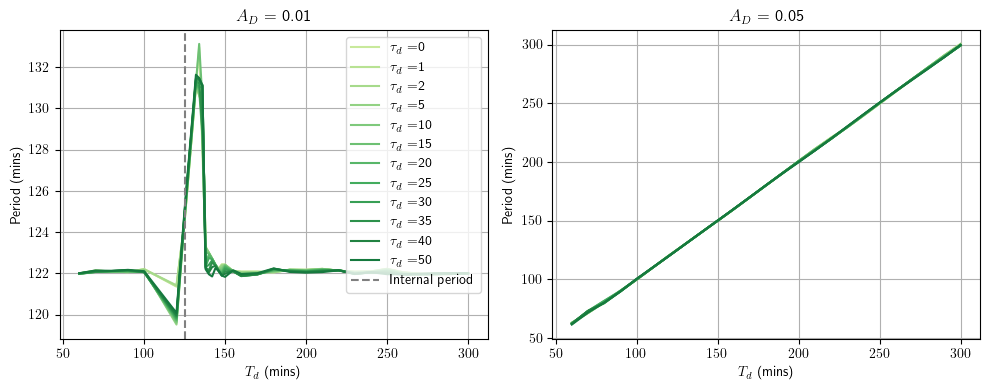

In [82]:
delta_periods = [60, 70, 80, 90, 100, 120, 125, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 155, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]
delays = [0, 1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 50]
num_tsteps = 40000
start_time = 2000
amplitude_limit = 0.01
amplitude_h_osc_weak = np.zeros((len(delta_periods), len(delays)))
amplitude_d_osc_weak = np.zeros((len(delta_periods), len(delays)))
period_h_osc_weak = np.zeros((len(delta_periods), len(delays)))
period_d_osc_weak = np.zeros((len(delta_periods), len(delays)))

amplitude_h_osc_strong = np.zeros((len(delta_periods), len(delays)))
amplitude_d_osc_strong = np.zeros((len(delta_periods), len(delays)))
period_h_osc_strong = np.zeros((len(delta_periods), len(delays)))
period_d_osc_strong = np.zeros((len(delta_periods), len(delays)))


def get_two_colormaps(k, avoid_white=True):
    """
    Returns two lists of k colors each:
    - One from the 'Blues' colormap
    - One from the 'Reds' colormap
    Colors are spaced and trimmed to avoid white and black extremes.
    """
    # Trim range to avoid white (too light) and near-black (too dark)
    min_val, max_val = (0.3, 0.85) if avoid_white else (0.0, 1.0)
    sample_points = np.linspace(min_val, max_val, k)

    blues_cmap = plt.cm.Blues(sample_points)
    reds_cmap = plt.cm.Reds(sample_points)

    # Convert to RGB tuples (remove alpha)
    blues_rgb = [tuple(color[:3]) for color in blues_cmap]
    reds_rgb = [tuple(color[:3]) for color in reds_cmap]

    return blues_rgb, reds_rgb

k = len(delays)
blues, reds = get_two_colormaps(k, avoid_white=True)

results_oscillating = results_oscillating_weak
for i in range(len(delta_periods)):
    for j in range(len(delays)):
        amplitude_h_osc_weak[i,j] = estimate_amplitude_from_peaks(results_oscillating[i,j,start_time:,0])[0]
        amplitude_d_osc_weak[i,j] = estimate_amplitude_from_peaks(results_oscillating[i,j,start_time:,1])[0]

        # amplitude_d_osc = np.nan_to_num(amplitude_d, nan=0.0)  # Handle NaN values
        # amplitude_h_osc = np.nan_to_num(amplitude_h, nan=0.0)  # Handle NaN values

        if amplitude_h_osc_weak[i,j] > amplitude_limit:
            period_h_osc_weak[i,j] = estimate_period_from_peaks(results_oscillating[i,j,start_time:,0], time = np.arange(num_tsteps-start_time)*dt)[0]
        else:
            period_h_osc_weak[i,j] = None

        if amplitude_d_osc_weak[i,j] > amplitude_limit:
            period_d_osc_weak[i,j] = estimate_period_from_peaks(results_oscillating[i,j,start_time:,1], time = np.arange(num_tsteps-start_time)*dt)[0]
        else:
            period_d_osc_weak[i,j] = None  

colours = get_distinguishable_ylgn_colors(len(delays), min_val=0.3, max_val=0.8)

plt.figure(figsize=(10, 4))

for j in range(len(delays)):
    plt.subplot(1, 2, 1)
    plt.plot(delta_periods, period_d_osc_weak[:,j], label=r'$\tau_d$ =' + str(delays[j]), color =colours[j])
    plt.xlabel(r'$T_d$ (mins)')
    plt.ylabel(r'Period (mins)')
    plt.title(r'$A_D$ = 0.01')


plt.axvline(period_uncoupled, ls='--', color='gray', label='Internal period')
plt.grid()
plt.legend()

results_oscillating = results_oscillating_strong
for i in range(len(delta_periods)):
    for j in range(len(delays)):
        amplitude_h_osc_strong[i,j] = estimate_amplitude_from_peaks(results_oscillating[i,j,start_time:,0])[0]
        amplitude_d_osc_strong[i,j] = estimate_amplitude_from_peaks(results_oscillating[i,j,start_time:,1])[0]
        # amplitude_d_osc = np.nan_to_num(amplitude_d, nan=0.0)  # Handle NaN values
        # amplitude_h_osc = np.nan_to_num(amplitude_h, nan=0.0)  # Handle NaN values

        if amplitude_h_osc_strong[i,j] > amplitude_limit:
            period_h_osc_strong[i,j] = estimate_period_from_peaks(results_oscillating[i,j,start_time:,0], time = np.arange(num_tsteps-start_time)*dt)[0]
        else:
            period_h_osc_strong[i,j] = None

        if amplitude_d_osc_strong[i,j] > amplitude_limit:
            period_d_osc_strong[i,j] = estimate_period_from_peaks(results_oscillating[i,j,start_time:,1], time = np.arange(num_tsteps-start_time)*dt)[0]
        else:
            period_d_osc_strong[i,j] = None  

colours = get_distinguishable_ylgn_colors(len(delays), min_val=0.3, max_val=0.8)

for j in range(len(delays)):
    plt.subplot(1, 2, 2)
    plt.plot(delta_periods, period_d_osc_strong[:,j], label=r'$\tau_d$ =' + str(delays[j]), color =colours[j])
    plt.xlabel(r'$T_d$ (mins)')
    plt.ylabel(r'Period (mins)')
    plt.title(r'$A_D$ = 0.05')


plt.grid()

plt.tight_layout()
# plt.savefig('bath-osc-periods.png', dpi =600, bbox_inches='tight')

# plt.figure(figsize=(10, 4))
# for j in range(len(delays)):
#     plt.subplot(1, 2, 1)
#     plt.plot(delta_periods, amplitude_d_osc[:,j], label=r'$\tau_d$ =' + str(delays[j]), color =colours[j])
#     plt.xlabel(r'$T_d$ (mins)')
#     plt.ylabel(r'Amplitude (a.u.)')
#     plt.title(r'$A_D$ = 0.01')
    
# for j in range(len(delays)):
#     plt.subplot(1, 2, 2)
#     plt.plot(delta_periods, amplitude_d_osc[:,j], label=r'$\tau_d$ =' + str(delays[j]), color =colours[j])
#     plt.xlabel(r'$T_d$ (mins)')
#     plt.ylabel(r'Period (mins)')
#     plt.title(r'$A_D$ = 0.05')


# plt.grid()

# plt.tight_layout()
# # plt.savefig('bath-osc-periods.png', dpi =600, bbox_inches='tight')

In [49]:

period = estimate_period_from_peaks(results_oscillating[0,0,start_time:,0], time = np.arange(num_tsteps-start_time)*dt)[0]
amplitude = estimate_amplitude_from_peaks(results_oscillating[0,0,start_time:,0])[0]

print(f"Estimated period: {period}")
print(f"Estimated amplitude: {amplitude}")

Estimated period: 60.10175438596491
Estimated amplitude: 4.316088427902715


In [53]:
def decay_ratio(signal, time_frame=360, height=None, distance=None, prominence=None):
    time_frame_steps = int(time_frame / dt)

    # Detect peaks
    peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)
    
    if len(peaks) < 2:
        return 100  # Not enough peaks

    # Calculate distances from the first peak
    peak_distances = peaks - peaks[0]
    mask = peak_distances > time_frame_steps

    if not np.any(mask):
        return 100  # No second peak far enough away

    # Get the first peak that satisfies the condition
    index = np.argmax(mask)

    peak_start = peaks[0]
    peak_end = peaks[index]

    peak_values_start = signal[peak_start]
    peak_values_end = signal[peak_end]

    # Check for invalid division
    if peak_values_end <= 0:
        return 100
    
    return peak_values_start / peak_values_end

In [54]:
# find the shift between the external delta peaks and the internal delta peaks

shift = np.zeros((len(delta_periods), len(delays)))
decay_ratios = np.zeros((len(delta_periods), len(delays)))
start_time = 2000
for i in range(len(delta_periods)):
    external_signal = np.sin(np.arange(num_tsteps) * dt * 2 * np.pi / delta_periods[i]) * delta_amplitude + delta_exp_level
    for j in range(len(delays)):
        period, peaks_external = estimate_period_from_peaks(external_signal[start_time:], time=np.arange(num_tsteps-start_time)*dt)
        period, peaks_internal = estimate_period_from_peaks(results_oscillating_strong[i,j,start_time:,1], time=np.arange(num_tsteps-start_time)*dt)

        decay_ratios[i,j] = decay_ratio(results_oscillating_strong[i,j,start_time:,1], time_frame=360, height=None, distance=5000, prominence=None)
        shift[i,j] = find_shift(peaks_external/dt, peaks_internal/dt)

In [57]:
print(num_tsteps)

40000


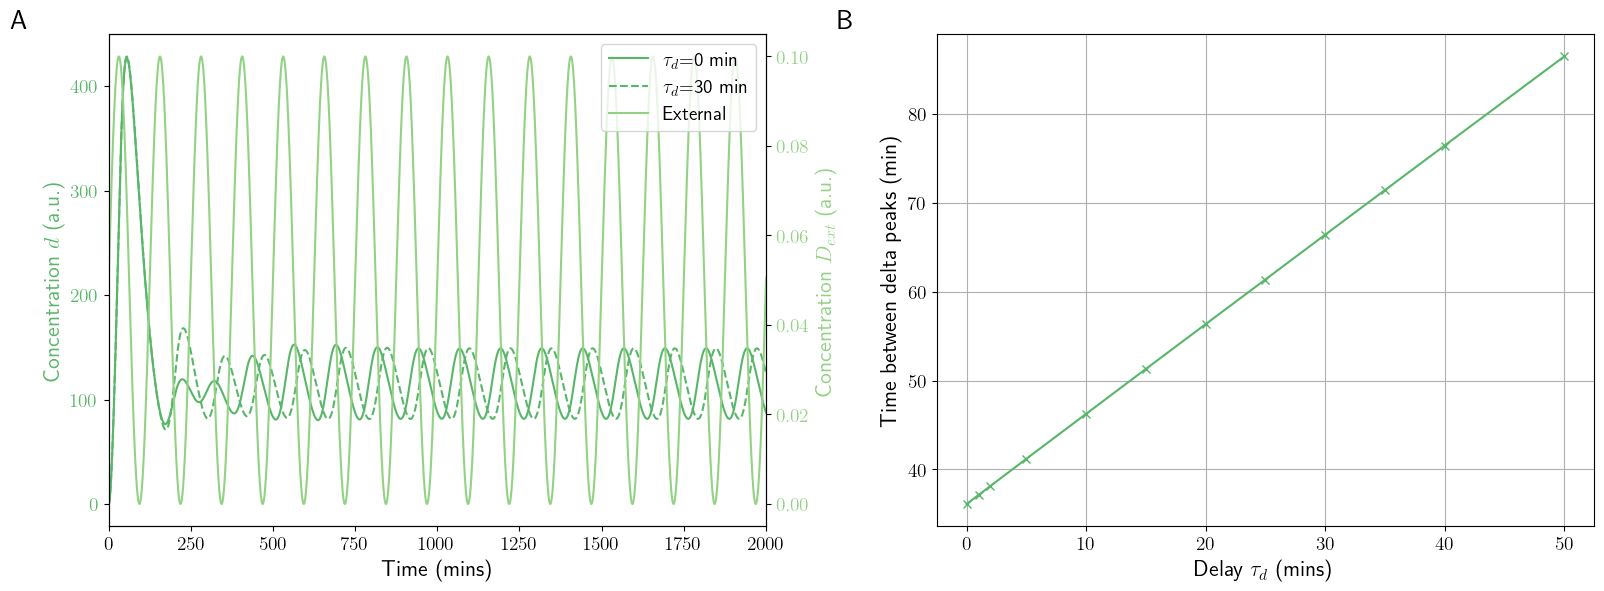

In [ ]:
# Time axis
time_minutes = np.arange(num_tsteps) * dt
time_minutes_half = np.arange(num_tsteps//2) * dt

# Data
i = 6
j0 = 0
j8 = 8

d_j0 = results_oscillating_strong[i, j0, :, 1]
d_j8 = results_oscillating_strong[i, j8, :, 1]
external_signal = external_delta_oscillator(num_tsteps, dt, delta_periods[i], 0.05)

# Create figure with 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16,6))

# ---------------------------------------------------------
# ---- Left subplot: time series plot ---------------------
# ---------------------------------------------------------
ax1 = axs[0]

# Plot d for j=0
ax1.plot(
    time_minutes_half, 
    d_j0, 
    label=fr'$\tau_d$={delays[j0]} min', 
    color=colours[6]
)

# Plot d for j=8
ax1.plot(
    time_minutes_half, 
    d_j8, 
    label=fr'$\tau_d$={delays[j8]} min', 
    color=colours[6], 
    linestyle='--'
)

# Secondary axis for external signal
ax2 = ax1.twinx()
ax2.plot(
    time_minutes, 
    external_signal, 
    label='External', 
    color=colours[3], 
    linestyle='-'
)

# Axis styling
ax1.set_xlabel('Time (mins)', fontsize=16)
ax1.set_ylabel(r'Concentration $d$ (a.u.)', fontsize=16, color=colours[6])
ax1.tick_params(axis='y', labelcolor=colours[6], labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

ax2.set_ylabel(r'Concentration $D_{ext}$ (a.u.)', fontsize=16, color=colours[3])
ax2.tick_params(axis='y', labelcolor=colours[3], labelsize=14)

ax1.set_xlim(0, 2000)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, fontsize=14, loc='upper right')

# Add subplot letter
ax1.text(-0.15, 1.05, 'A', transform=ax1.transAxes, 
         fontsize=20, fontweight='bold', va='top')

# ---------------------------------------------------------
# ---- Right subplot: delay vs shift ----------------------
# ---------------------------------------------------------
ax = axs[1]

ax.plot(
    delays, 
    shift[6, :], 
    marker='x', 
    label=r'$T_D$ = ' + str(delta_periods[6]), 
    color=colours[6]
)

ax.set_xlabel(r'Delay $\tau_d$ (mins)', fontsize=16)
ax.set_ylabel('Time between delta peaks (min)', fontsize=16)
ax.grid()
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# ax.legend(fontsize=14)

# Add subplot letter
ax.text(-0.15, 1.05, 'B', transform=ax.transAxes, 
         fontsize=20, fontweight='bold', va='top')

plt.tight_layout()

# Save
# plt.savefig('delta-bath-delay-shift-combined.png', dpi=600, bbox_inches='tight')

plt.show()


### Testing for shift 

## For 4 external periods check the effect amplitude strength

In [71]:
periods = np.array([-50, -10, 10, 50]) + np.round(period_uncoupled)
external_strength = np.linspace(0, 0.05, 41)
print(periods, external_strength)

[ 75. 115. 135. 175.] [0.      0.00125 0.0025  0.00375 0.005   0.00625 0.0075  0.00875 0.01
 0.01125 0.0125  0.01375 0.015   0.01625 0.0175  0.01875 0.02    0.02125
 0.0225  0.02375 0.025   0.02625 0.0275  0.02875 0.03    0.03125 0.0325
 0.03375 0.035   0.03625 0.0375  0.03875 0.04    0.04125 0.0425  0.04375
 0.045   0.04625 0.0475  0.04875 0.05   ]


### obtain data

In [ ]:
num_tsteps = 40000
dt = 0.2

results_osc_strength = np.zeros((len(periods), len(external_strength), num_tsteps, 3))

for i in range(len(periods)):
    for j in range(len(external_strength)):
        print(f"Evaluating period {periods[i]} with external strength {external_strength[j]}")
        delta_oscillator = external_delta_oscillator(num_tsteps, dt, periods[i], external_strength[j])
        h, m_h, d, m_d = evaluate_oscillating_delta(num_tsteps, dt, delta_oscillator, 0, lattice, params)

        results_osc_strength[i,j,:,0] = h[:,1].flatten()
        results_osc_strength[i,j,:,1] = m_h[:,1].flatten()
        results_osc_strength[i,j,:,2] = d[:,1].flatten()

with open('results_osc_strength.pickle', 'wb') as f:
    pickle.dump(results_osc_strength, f)

Evaluating period 75.0 with external strength 0.0


100%|██████████| 19999/19999 [00:02<00:00, 8716.81it/s]


Evaluating period 75.0 with external strength 0.00125


100%|██████████| 19999/19999 [00:02<00:00, 8488.94it/s]


Evaluating period 75.0 with external strength 0.0025


100%|██████████| 19999/19999 [00:02<00:00, 8718.21it/s]


Evaluating period 75.0 with external strength 0.00375


100%|██████████| 19999/19999 [00:02<00:00, 9891.90it/s] 


Evaluating period 75.0 with external strength 0.005


100%|██████████| 19999/19999 [00:01<00:00, 10170.90it/s]


Evaluating period 75.0 with external strength 0.00625


100%|██████████| 19999/19999 [00:02<00:00, 9452.55it/s]


Evaluating period 75.0 with external strength 0.0075


100%|██████████| 19999/19999 [00:02<00:00, 8142.46it/s]


Evaluating period 75.0 with external strength 0.00875


100%|██████████| 19999/19999 [00:02<00:00, 8525.74it/s]


Evaluating period 75.0 with external strength 0.01


100%|██████████| 19999/19999 [00:02<00:00, 9572.69it/s] 


Evaluating period 75.0 with external strength 0.01125


100%|██████████| 19999/19999 [00:02<00:00, 9745.80it/s] 


Evaluating period 75.0 with external strength 0.0125


100%|██████████| 19999/19999 [00:02<00:00, 8099.41it/s]


Evaluating period 75.0 with external strength 0.01375


100%|██████████| 19999/19999 [00:02<00:00, 8064.27it/s] 


Evaluating period 75.0 with external strength 0.015


100%|██████████| 19999/19999 [00:01<00:00, 10339.34it/s]


Evaluating period 75.0 with external strength 0.01625


100%|██████████| 19999/19999 [00:01<00:00, 10560.98it/s]


Evaluating period 75.0 with external strength 0.0175


100%|██████████| 19999/19999 [00:02<00:00, 9578.92it/s]


Evaluating period 75.0 with external strength 0.01875


100%|██████████| 19999/19999 [00:02<00:00, 9676.68it/s] 


Evaluating period 75.0 with external strength 0.02


100%|██████████| 19999/19999 [00:02<00:00, 9768.31it/s] 


Evaluating period 75.0 with external strength 0.02125


100%|██████████| 19999/19999 [00:02<00:00, 9948.70it/s] 


Evaluating period 75.0 with external strength 0.0225


100%|██████████| 19999/19999 [00:01<00:00, 10005.76it/s]


Evaluating period 75.0 with external strength 0.02375


100%|██████████| 19999/19999 [00:01<00:00, 10256.36it/s]


Evaluating period 75.0 with external strength 0.025


100%|██████████| 19999/19999 [00:02<00:00, 9762.98it/s] 


Evaluating period 75.0 with external strength 0.02625


100%|██████████| 19999/19999 [00:01<00:00, 10950.76it/s]


Evaluating period 75.0 with external strength 0.0275


100%|██████████| 19999/19999 [00:01<00:00, 10896.49it/s]


Evaluating period 75.0 with external strength 0.02875


100%|██████████| 19999/19999 [00:01<00:00, 10814.64it/s]


Evaluating period 75.0 with external strength 0.03


100%|██████████| 19999/19999 [00:02<00:00, 9258.36it/s] 


Evaluating period 75.0 with external strength 0.03125


100%|██████████| 19999/19999 [00:02<00:00, 8967.94it/s]


Evaluating period 75.0 with external strength 0.0325


100%|██████████| 19999/19999 [00:01<00:00, 10381.57it/s]


Evaluating period 75.0 with external strength 0.03375


100%|██████████| 19999/19999 [00:02<00:00, 9990.47it/s] 


Evaluating period 75.0 with external strength 0.035


100%|██████████| 19999/19999 [00:01<00:00, 10515.00it/s]


Evaluating period 75.0 with external strength 0.03625


100%|██████████| 19999/19999 [00:02<00:00, 9654.40it/s]


Evaluating period 75.0 with external strength 0.0375


100%|██████████| 19999/19999 [00:02<00:00, 8957.46it/s]


Evaluating period 75.0 with external strength 0.03875


100%|██████████| 19999/19999 [00:01<00:00, 10072.06it/s]


Evaluating period 75.0 with external strength 0.04


100%|██████████| 19999/19999 [00:01<00:00, 10361.05it/s]


Evaluating period 75.0 with external strength 0.04125


100%|██████████| 19999/19999 [00:01<00:00, 10622.92it/s]


Evaluating period 75.0 with external strength 0.0425


100%|██████████| 19999/19999 [00:01<00:00, 10529.59it/s]


Evaluating period 75.0 with external strength 0.043750000000000004


100%|██████████| 19999/19999 [00:01<00:00, 10349.88it/s]


Evaluating period 75.0 with external strength 0.045


100%|██████████| 19999/19999 [00:01<00:00, 10806.20it/s]


Evaluating period 75.0 with external strength 0.04625


100%|██████████| 19999/19999 [00:01<00:00, 10646.80it/s]


Evaluating period 75.0 with external strength 0.0475


100%|██████████| 19999/19999 [00:01<00:00, 10821.32it/s]


Evaluating period 75.0 with external strength 0.04875


100%|██████████| 19999/19999 [00:01<00:00, 10185.17it/s]


Evaluating period 75.0 with external strength 0.05


100%|██████████| 19999/19999 [00:01<00:00, 10216.07it/s]


Evaluating period 115.0 with external strength 0.0


100%|██████████| 19999/19999 [00:01<00:00, 10759.45it/s]


Evaluating period 115.0 with external strength 0.00125


100%|██████████| 19999/19999 [00:01<00:00, 10815.74it/s]


Evaluating period 115.0 with external strength 0.0025


100%|██████████| 19999/19999 [00:01<00:00, 10715.13it/s]


Evaluating period 115.0 with external strength 0.00375


100%|██████████| 19999/19999 [00:01<00:00, 10171.21it/s]


Evaluating period 115.0 with external strength 0.005


100%|██████████| 19999/19999 [00:01<00:00, 10346.01it/s]


Evaluating period 115.0 with external strength 0.00625


100%|██████████| 19999/19999 [00:01<00:00, 10911.34it/s]


Evaluating period 115.0 with external strength 0.0075


100%|██████████| 19999/19999 [00:01<00:00, 10813.98it/s]


Evaluating period 115.0 with external strength 0.00875


100%|██████████| 19999/19999 [00:01<00:00, 10810.67it/s]


Evaluating period 115.0 with external strength 0.01


100%|██████████| 19999/19999 [00:01<00:00, 10407.37it/s]


Evaluating period 115.0 with external strength 0.01125


100%|██████████| 19999/19999 [00:01<00:00, 11023.79it/s]


Evaluating period 115.0 with external strength 0.0125


100%|██████████| 19999/19999 [00:01<00:00, 10810.12it/s]


Evaluating period 115.0 with external strength 0.01375


100%|██████████| 19999/19999 [00:01<00:00, 11015.18it/s]


Evaluating period 115.0 with external strength 0.015


100%|██████████| 19999/19999 [00:01<00:00, 10944.17it/s]


Evaluating period 115.0 with external strength 0.01625


100%|██████████| 19999/19999 [00:01<00:00, 10528.01it/s]


Evaluating period 115.0 with external strength 0.0175


100%|██████████| 19999/19999 [00:01<00:00, 10745.92it/s]


Evaluating period 115.0 with external strength 0.01875


100%|██████████| 19999/19999 [00:01<00:00, 10904.16it/s]


Evaluating period 115.0 with external strength 0.02


100%|██████████| 19999/19999 [00:01<00:00, 10815.24it/s]


Evaluating period 115.0 with external strength 0.02125


100%|██████████| 19999/19999 [00:01<00:00, 10908.13it/s]


Evaluating period 115.0 with external strength 0.0225


100%|██████████| 19999/19999 [00:01<00:00, 10528.43it/s]


Evaluating period 115.0 with external strength 0.02375


100%|██████████| 19999/19999 [00:01<00:00, 10716.37it/s]


Evaluating period 115.0 with external strength 0.025


100%|██████████| 19999/19999 [00:01<00:00, 10716.92it/s]


Evaluating period 115.0 with external strength 0.02625


100%|██████████| 19999/19999 [00:01<00:00, 10626.49it/s]


Evaluating period 115.0 with external strength 0.0275


100%|██████████| 19999/19999 [00:02<00:00, 9539.79it/s] 


Evaluating period 115.0 with external strength 0.02875


100%|██████████| 19999/19999 [00:02<00:00, 7899.07it/s]


Evaluating period 115.0 with external strength 0.03


100%|██████████| 19999/19999 [00:02<00:00, 8396.45it/s]


Evaluating period 115.0 with external strength 0.03125


100%|██████████| 19999/19999 [00:05<00:00, 3879.04it/s]


Evaluating period 115.0 with external strength 0.0325


100%|██████████| 19999/19999 [00:02<00:00, 8364.59it/s]


Evaluating period 115.0 with external strength 0.03375


100%|██████████| 19999/19999 [00:02<00:00, 6776.45it/s]


Evaluating period 115.0 with external strength 0.035


100%|██████████| 19999/19999 [00:03<00:00, 5579.37it/s]


Evaluating period 115.0 with external strength 0.03625


100%|██████████| 19999/19999 [00:03<00:00, 6534.31it/s]


Evaluating period 115.0 with external strength 0.0375


100%|██████████| 19999/19999 [00:02<00:00, 8210.54it/s]


Evaluating period 115.0 with external strength 0.03875


100%|██████████| 19999/19999 [00:02<00:00, 6865.51it/s]


Evaluating period 115.0 with external strength 0.04


100%|██████████| 19999/19999 [00:02<00:00, 9827.41it/s] 


Evaluating period 115.0 with external strength 0.04125


100%|██████████| 19999/19999 [00:02<00:00, 9048.95it/s] 


Evaluating period 115.0 with external strength 0.0425


100%|██████████| 19999/19999 [00:02<00:00, 7065.95it/s]


Evaluating period 115.0 with external strength 0.043750000000000004


100%|██████████| 19999/19999 [00:02<00:00, 7524.90it/s]


Evaluating period 115.0 with external strength 0.045


100%|██████████| 19999/19999 [00:02<00:00, 8754.19it/s] 


Evaluating period 115.0 with external strength 0.04625


100%|██████████| 19999/19999 [00:02<00:00, 8335.32it/s]


Evaluating period 115.0 with external strength 0.0475


100%|██████████| 19999/19999 [00:02<00:00, 6753.76it/s]


Evaluating period 115.0 with external strength 0.04875


100%|██████████| 19999/19999 [00:02<00:00, 6947.22it/s]


Evaluating period 115.0 with external strength 0.05


100%|██████████| 19999/19999 [00:02<00:00, 7469.88it/s]


Evaluating period 135.0 with external strength 0.0


100%|██████████| 19999/19999 [00:01<00:00, 10416.05it/s]


Evaluating period 135.0 with external strength 0.00125


100%|██████████| 19999/19999 [00:02<00:00, 8012.46it/s]


Evaluating period 135.0 with external strength 0.0025


100%|██████████| 19999/19999 [00:02<00:00, 8721.75it/s]


Evaluating period 135.0 with external strength 0.00375


100%|██████████| 19999/19999 [00:01<00:00, 10410.49it/s]


Evaluating period 135.0 with external strength 0.005


100%|██████████| 19999/19999 [00:02<00:00, 9953.04it/s] 


Evaluating period 135.0 with external strength 0.00625


100%|██████████| 19999/19999 [00:01<00:00, 10421.56it/s]


Evaluating period 135.0 with external strength 0.0075


100%|██████████| 19999/19999 [00:01<00:00, 10825.50it/s]


Evaluating period 135.0 with external strength 0.00875


100%|██████████| 19999/19999 [00:02<00:00, 8516.03it/s] 


Evaluating period 135.0 with external strength 0.01


100%|██████████| 19999/19999 [00:02<00:00, 9084.71it/s] 


Evaluating period 135.0 with external strength 0.01125


100%|██████████| 19999/19999 [00:02<00:00, 9700.56it/s] 


Evaluating period 135.0 with external strength 0.0125


100%|██████████| 19999/19999 [00:02<00:00, 9623.16it/s] 


Evaluating period 135.0 with external strength 0.01375


100%|██████████| 19999/19999 [00:02<00:00, 8701.08it/s] 


Evaluating period 135.0 with external strength 0.015


100%|██████████| 19999/19999 [00:01<00:00, 10864.83it/s]


Evaluating period 135.0 with external strength 0.01625


100%|██████████| 19999/19999 [00:01<00:00, 11042.22it/s]


Evaluating period 135.0 with external strength 0.0175


100%|██████████| 19999/19999 [00:02<00:00, 7972.82it/s]


Evaluating period 135.0 with external strength 0.01875


100%|██████████| 19999/19999 [00:02<00:00, 9836.68it/s] 


Evaluating period 135.0 with external strength 0.02


100%|██████████| 19999/19999 [00:01<00:00, 10722.33it/s]


Evaluating period 135.0 with external strength 0.02125


100%|██████████| 19999/19999 [00:02<00:00, 7386.20it/s]


Evaluating period 135.0 with external strength 0.0225


100%|██████████| 19999/19999 [00:03<00:00, 6328.54it/s]


Evaluating period 135.0 with external strength 0.02375


100%|██████████| 19999/19999 [00:03<00:00, 6356.87it/s]


Evaluating period 135.0 with external strength 0.025


100%|██████████| 19999/19999 [00:02<00:00, 7056.51it/s]


Evaluating period 135.0 with external strength 0.02625


100%|██████████| 19999/19999 [00:02<00:00, 7387.67it/s] 


Evaluating period 135.0 with external strength 0.0275


100%|██████████| 19999/19999 [00:01<00:00, 10473.70it/s]


Evaluating period 135.0 with external strength 0.02875


100%|██████████| 19999/19999 [00:01<00:00, 10274.60it/s]


Evaluating period 135.0 with external strength 0.03


100%|██████████| 19999/19999 [00:01<00:00, 11282.01it/s]


Evaluating period 135.0 with external strength 0.03125


100%|██████████| 19999/19999 [00:01<00:00, 11081.58it/s]


Evaluating period 135.0 with external strength 0.0325


100%|██████████| 19999/19999 [00:01<00:00, 10719.10it/s]


Evaluating period 135.0 with external strength 0.03375


100%|██████████| 19999/19999 [00:01<00:00, 10635.42it/s]


Evaluating period 135.0 with external strength 0.035


100%|██████████| 19999/19999 [00:01<00:00, 10678.51it/s]


Evaluating period 135.0 with external strength 0.03625


100%|██████████| 19999/19999 [00:01<00:00, 10923.81it/s]


Evaluating period 135.0 with external strength 0.0375


100%|██████████| 19999/19999 [00:01<00:00, 10896.78it/s]


Evaluating period 135.0 with external strength 0.03875


100%|██████████| 19999/19999 [00:01<00:00, 11144.21it/s]


Evaluating period 135.0 with external strength 0.04


100%|██████████| 19999/19999 [00:01<00:00, 11130.82it/s]


Evaluating period 135.0 with external strength 0.04125


100%|██████████| 19999/19999 [00:01<00:00, 10678.30it/s]


Evaluating period 135.0 with external strength 0.0425


100%|██████████| 19999/19999 [00:01<00:00, 11089.25it/s]


Evaluating period 135.0 with external strength 0.043750000000000004


100%|██████████| 19999/19999 [00:01<00:00, 10960.01it/s]


Evaluating period 135.0 with external strength 0.045


100%|██████████| 19999/19999 [00:01<00:00, 10919.25it/s]


Evaluating period 135.0 with external strength 0.04625


100%|██████████| 19999/19999 [00:01<00:00, 11114.77it/s]


Evaluating period 135.0 with external strength 0.0475


100%|██████████| 19999/19999 [00:02<00:00, 9758.61it/s] 


Evaluating period 135.0 with external strength 0.04875


100%|██████████| 19999/19999 [00:01<00:00, 11099.28it/s]


Evaluating period 135.0 with external strength 0.05


100%|██████████| 19999/19999 [00:01<00:00, 11018.43it/s]


Evaluating period 175.0 with external strength 0.0


100%|██████████| 19999/19999 [00:01<00:00, 10799.59it/s]


Evaluating period 175.0 with external strength 0.00125


100%|██████████| 19999/19999 [00:02<00:00, 9215.63it/s] 


Evaluating period 175.0 with external strength 0.0025


100%|██████████| 19999/19999 [00:01<00:00, 10616.05it/s]


Evaluating period 175.0 with external strength 0.00375


100%|██████████| 19999/19999 [00:01<00:00, 11183.81it/s]


Evaluating period 175.0 with external strength 0.005


100%|██████████| 19999/19999 [00:02<00:00, 9323.73it/s]


Evaluating period 175.0 with external strength 0.00625


100%|██████████| 19999/19999 [00:02<00:00, 7865.47it/s]


Evaluating period 175.0 with external strength 0.0075


100%|██████████| 19999/19999 [00:01<00:00, 10261.12it/s]


Evaluating period 175.0 with external strength 0.00875


100%|██████████| 19999/19999 [00:02<00:00, 9393.38it/s] 


Evaluating period 175.0 with external strength 0.01


100%|██████████| 19999/19999 [00:01<00:00, 10819.13it/s]


Evaluating period 175.0 with external strength 0.01125


100%|██████████| 19999/19999 [00:01<00:00, 10780.83it/s]


Evaluating period 175.0 with external strength 0.0125


100%|██████████| 19999/19999 [00:02<00:00, 8197.56it/s]


Evaluating period 175.0 with external strength 0.01375


100%|██████████| 19999/19999 [00:02<00:00, 8346.81it/s] 


Evaluating period 175.0 with external strength 0.015


100%|██████████| 19999/19999 [00:01<00:00, 10926.34it/s]


Evaluating period 175.0 with external strength 0.01625


100%|██████████| 19999/19999 [00:01<00:00, 10528.10it/s]


Evaluating period 175.0 with external strength 0.0175


100%|██████████| 19999/19999 [00:01<00:00, 11316.45it/s]


Evaluating period 175.0 with external strength 0.01875


100%|██████████| 19999/19999 [00:01<00:00, 10958.70it/s]


Evaluating period 175.0 with external strength 0.02


100%|██████████| 19999/19999 [00:03<00:00, 5915.68it/s]


Evaluating period 175.0 with external strength 0.02125


100%|██████████| 19999/19999 [00:02<00:00, 6949.39it/s]


Evaluating period 175.0 with external strength 0.0225


100%|██████████| 19999/19999 [00:02<00:00, 7250.85it/s]


Evaluating period 175.0 with external strength 0.02375


100%|██████████| 19999/19999 [00:02<00:00, 6673.98it/s]


Evaluating period 175.0 with external strength 0.025


100%|██████████| 19999/19999 [00:03<00:00, 6307.54it/s]


Evaluating period 175.0 with external strength 0.02625


100%|██████████| 19999/19999 [00:02<00:00, 7172.90it/s]


Evaluating period 175.0 with external strength 0.0275


100%|██████████| 19999/19999 [00:04<00:00, 4973.50it/s]


Evaluating period 175.0 with external strength 0.02875


100%|██████████| 19999/19999 [00:04<00:00, 4810.86it/s]


Evaluating period 175.0 with external strength 0.03


100%|██████████| 19999/19999 [00:04<00:00, 4611.22it/s]


Evaluating period 175.0 with external strength 0.03125


100%|██████████| 19999/19999 [00:04<00:00, 4721.01it/s]


Evaluating period 175.0 with external strength 0.0325


100%|██████████| 19999/19999 [00:03<00:00, 5338.23it/s]


Evaluating period 175.0 with external strength 0.03375


100%|██████████| 19999/19999 [00:03<00:00, 5252.49it/s]


Evaluating period 175.0 with external strength 0.035


100%|██████████| 19999/19999 [00:02<00:00, 9234.90it/s] 


Evaluating period 175.0 with external strength 0.03625


100%|██████████| 19999/19999 [00:03<00:00, 6043.73it/s]


Evaluating period 175.0 with external strength 0.0375


100%|██████████| 19999/19999 [00:02<00:00, 6914.61it/s]


Evaluating period 175.0 with external strength 0.03875


100%|██████████| 19999/19999 [00:02<00:00, 7898.50it/s] 


Evaluating period 175.0 with external strength 0.04


100%|██████████| 19999/19999 [00:02<00:00, 7665.00it/s]


Evaluating period 175.0 with external strength 0.04125


100%|██████████| 19999/19999 [00:02<00:00, 7417.29it/s] 


Evaluating period 175.0 with external strength 0.0425


100%|██████████| 19999/19999 [00:01<00:00, 11129.32it/s]


Evaluating period 175.0 with external strength 0.043750000000000004


100%|██████████| 19999/19999 [00:01<00:00, 11356.70it/s]


Evaluating period 175.0 with external strength 0.045


100%|██████████| 19999/19999 [00:02<00:00, 9309.60it/s] 


Evaluating period 175.0 with external strength 0.04625


100%|██████████| 19999/19999 [00:01<00:00, 10901.13it/s]


Evaluating period 175.0 with external strength 0.0475


100%|██████████| 19999/19999 [00:01<00:00, 11061.40it/s]


Evaluating period 175.0 with external strength 0.04875


100%|██████████| 19999/19999 [00:01<00:00, 11392.47it/s]


Evaluating period 175.0 with external strength 0.05


100%|██████████| 19999/19999 [00:01<00:00, 10748.51it/s]


### Load data 

In [72]:
with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_osc_strength.pickle', 'rb') as f:
    results_osc_strength = pickle.load(f)

### Periods

In [73]:
periods_osc_strength = np.zeros((len(periods), len(external_strength)))
amplitude_osc_strength = np.zeros((len(periods), len(external_strength)))

for i in range(len(periods)):
    for j in range(len(external_strength)):
        periods_osc_strength[i,j] = estimate_period_from_peaks(results_osc_strength[i,j,:,0], time=np.arange(num_tsteps)*dt)[0]
        amplitude_osc_strength[i,j] = estimate_amplitude_from_peaks(results_osc_strength[i,j,:,0])[0]



C:\Users\kbmcd\AppData\Local\Temp\ipykernel_15672\3872273401.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('YlGn')


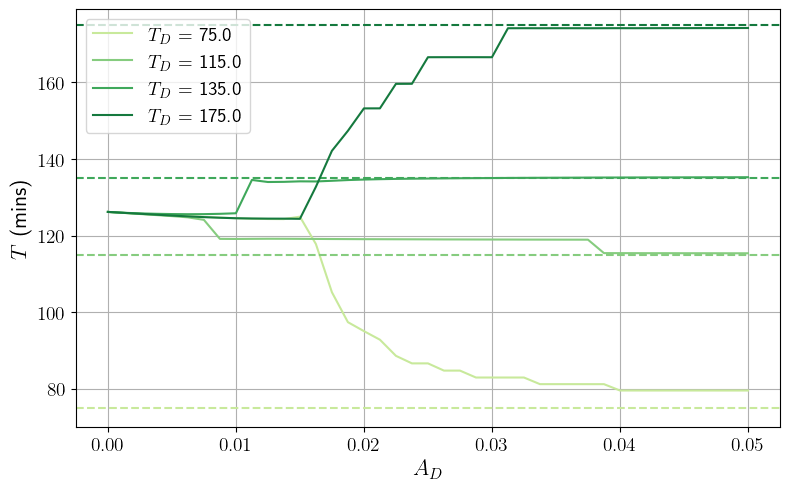

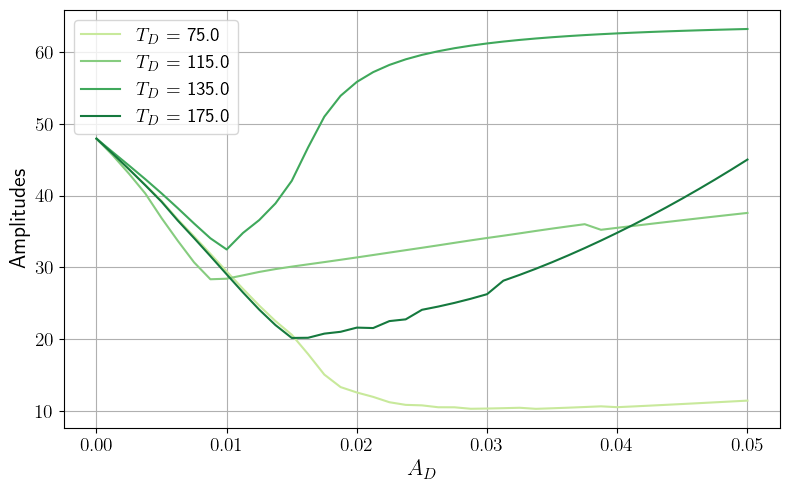

In [75]:
# for i in range(len(periods)):
#     plt.figure()
#     plt.subplot(1, 2, 1)
#     plt.plot(external_strength, periods_osc_strength[i,:], label='period')
#     plt.xlabel('External Strength')
#     plt.ylabel('Period (mins)')
#     plt.subplot(1, 2, 2)
#     plt.plot(external_strength, amplitude_osc_strength[i,:], label='amplitude')
#     plt.xlabel('External Strength')
#     plt.ylabel('Amplitude')
#     plt.suptitle(f'Period vs External Strength for Period {periods[i]}')

greens = get_distinguishable_ylgn_colors(len(periods), min_val=0.3, max_val=0.8)
plt.figure(figsize=(8, 5))
for i in range(len(periods)):
    plt.plot(external_strength, periods_osc_strength[i,:], color = greens[i], label=r'$T_D$ = ' + str(periods[i]))
    plt.axhline(periods[i], ls='--', color=greens[i])
    plt.xlabel(r'$A_D$', fontsize=16)
    plt.ylabel(r'$T$ (mins)', fontsize=16)
plt.grid()
plt.legend(fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

# plt.savefig('periods_vs_external_strength.png', dpi=600, bbox_inches='tight')

plt.figure(figsize=(8, 5))
for i in range(len(periods)):
    plt.plot(external_strength, amplitude_osc_strength[i,:], color = greens[i], label=r'$T_D$ = ' + str(periods[i]))
    plt.xlabel(r'$A_D$', fontsize=16)
    plt.ylabel(r'Amplitudes', fontsize=16)
plt.grid()
plt.legend(fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

# plt.savefig('periods_vs_external_strength.png', dpi=600, bbox_inches='tight')



C:\Users\kbmcd\AppData\Local\Temp\ipykernel_15672\3872273401.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('YlGn')


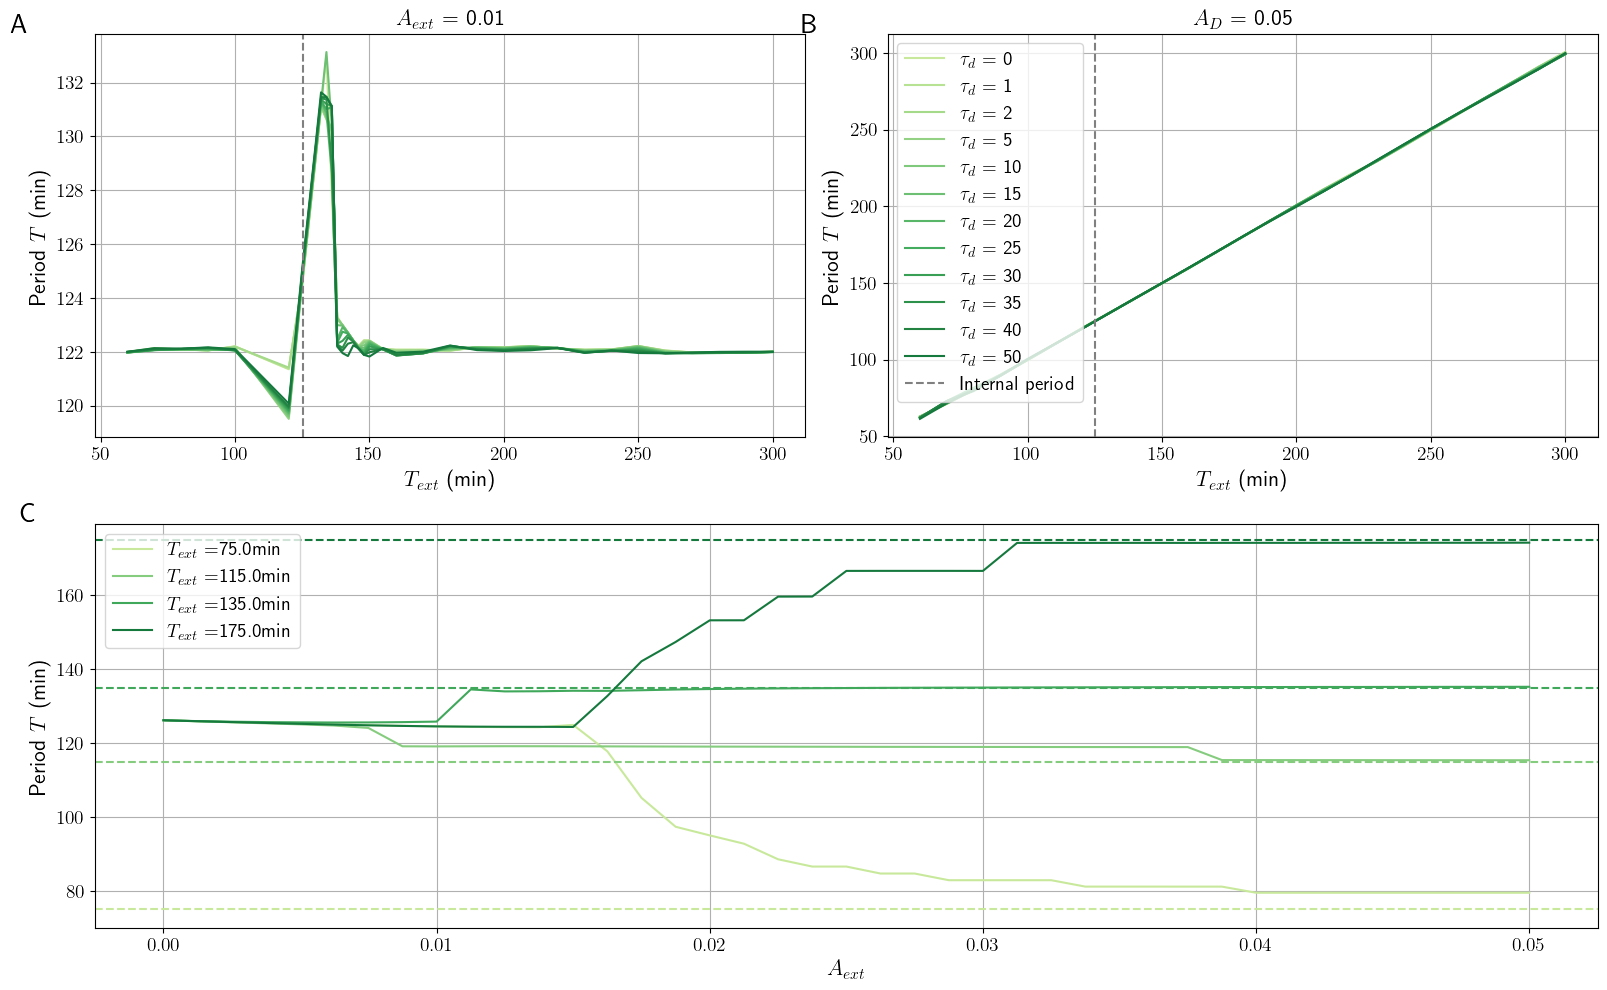

In [86]:

# Define figure + GridSpec
# ----------------------------------------------------------
fig = plt.figure(figsize=(16,10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# ----------------------------------------------------------
# ---- Panel A: Weak coupling (top left) -------------------
# ----------------------------------------------------------
axA = fig.add_subplot(gs[0,0])

# Assume results_oscillating = results_oscillating_weak
# Plot the period curves for weak coupling
colours_weak = get_distinguishable_ylgn_colors(len(delays), min_val=0.3, max_val=0.8)

for j in range(len(delays)):
    axA.plot(delta_periods, period_d_osc_weak[:,j],
             label=fr'$\tau_d$ = {delays[j]}',
             color=colours_weak[j])

axA.axvline(period_uncoupled, ls='--', color='gray', label='Internal period')

axA.set_xlabel(r'$T_{ext}$ (min)', fontsize=16)
axA.set_ylabel(r'Period $T$ (min)', fontsize=16)
axA.set_title(r'$A_{ext}$ = 0.01', fontsize=16)
# axA.legend(fontsize=14)
axA.grid()
axA.tick_params(axis='x', labelsize=14)
axA.tick_params(axis='y', labelsize=14)

# Add letter A
axA.text(-0.12, 1.05, 'A', transform=axA.transAxes,
         fontsize=20, fontweight='bold', va='top')

# ----------------------------------------------------------
# ---- Panel B: Strong coupling (top right) ----------------
# ----------------------------------------------------------
axB = fig.add_subplot(gs[0,1])

# Now results_oscillating = results_oscillating_strong
colours_strong = get_distinguishable_ylgn_colors(len(delays), min_val=0.3, max_val=0.8)

for j in range(len(delays)):
    axB.plot(delta_periods, period_d_osc_strong[:,j],
             label=fr'$\tau_d$ = {delays[j]}',
             color=colours_strong[j])

axB.axvline(period_uncoupled, ls='--', color='gray', label='Internal period')

axB.set_xlabel(r'$T_{ext}$ (min)', fontsize=16)
axB.set_ylabel(r'Period $T$ (min)', fontsize=16)
axB.set_title(r'$A_D$ = 0.05', fontsize=16)
axB.legend(fontsize=14)
axB.grid()
axB.tick_params(axis='x', labelsize=14)
axB.tick_params(axis='y', labelsize=14)

# Add letter B
axB.text(-0.12, 1.05, 'B', transform=axB.transAxes,
         fontsize=20, fontweight='bold', va='top')

# ----------------------------------------------------------
# ---- Panel C: Period vs A_D plot (bottom spanning both) --
# ----------------------------------------------------------
axC = fig.add_subplot(gs[1, :])

for i in range(len(periods)):
    axC.plot(
        external_strength,
        periods_osc_strength[i,:],
        color=greens[i],
        label=r'$T_{ext}$ =' + str(periods[i]) + 'min'
    )
    axC.axhline(periods[i], ls='--', color=greens[i])

axC.set_xlabel(r'$A_{ext}$', fontsize=16)
axC.set_ylabel(r'Period $T$ (min)', fontsize=16)
axC.legend(fontsize=14)
axC.grid()
axC.tick_params(axis='x', labelsize=14)
axC.tick_params(axis='y', labelsize=14)

# Add letter C
axC.text(-0.05, 1.05, 'C', transform=axC.transAxes,
         fontsize=20, fontweight='bold', va='top')

# ----------------------------------------------------------
# Layout and save
# ----------------------------------------------------------
plt.tight_layout()
# plt.savefig('delta-bath-delay-shift.png', dpi=600, bbox_inches='tight')
plt.show()


### Limit cycles for these cases 

[ 0  8 16 24 32 40]


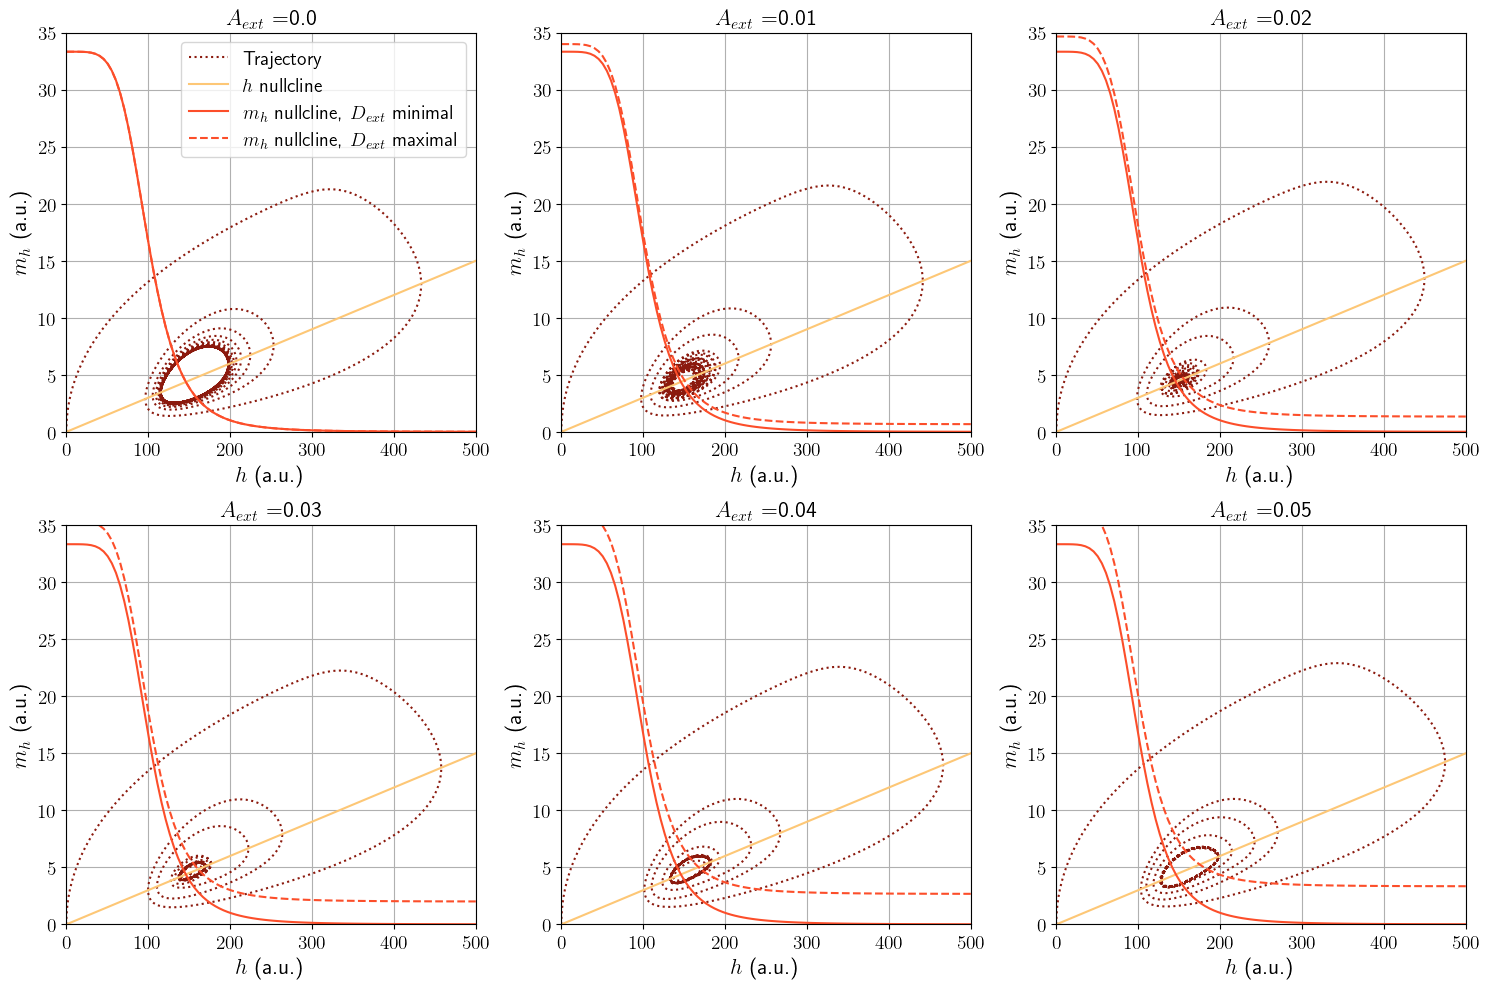

In [88]:
i_period = 3
i_ext_strength = -1
timepoint = 10000

m_h_plot = np.linspace(0, 50, 100)*1
h_plot = np.linspace(0, 500, 100)*1

strength_range = np.linspace(0, 5, 6, dtype = int)*8
print(strength_range)

plt.figure(figsize=(15, 10))
for i_ext_strength in strength_range:
    limit_cycle_case = results_osc_strength[i_period,i_ext_strength]

    limit_cycle_external = external_delta_oscillator(num_tsteps, dt, periods[i_period], external_strength[i_ext_strength])

    # plt.figure(figsize=(3,1))
    # plt.plot(limit_cycle_external)
    # print(limit_cycle_external[timepoint])
    h_null_0, m_h_null_0 = nullclines_Hes_deltabath(m_h_plot, h_plot, 0, p_h, l, gamma_h, gamma_m)
    h_null_ext, m_h_null_ext = nullclines_Hes_deltabath(m_h_plot, h_plot, 2*external_strength[i_ext_strength], p_h, l, gamma_h, gamma_m)
    plt.subplot(2, len(strength_range)//2, int(i_ext_strength  / 8 + 1))
    plt.plot(limit_cycle_case[:,0], limit_cycle_case[:,1], ls = 'dotted', color = hescolor3, label='Trajectory')
    
    plt.plot(h_null_ext, m_h_plot, color = hescolor1, label=r'$h$ nullcline')
    plt.plot(h_plot, m_h_null_0, color = hescolor2, label=r'$m_h$ nullcline, $D_{ext}$ minimal')
    plt.plot(h_plot, m_h_null_ext, color = hescolor2, ls = '--', label=r'$m_h$ nullcline, $D_{ext}$ maximal')
    # plt.plot(x_fixed_points, y_fixed_points, ls='--', color='yellow', label='Fixed point line')
    plt.ylim(0,35)
    plt.xlim(0, 500)
    plt.title(r'$A_{ext}$ =' + str(external_strength[i_ext_strength]), fontsize=16)
    plt.grid()
    plt.xlabel(r'$h$ (a.u.)', fontsize = 16)
    plt.ylabel(r'$m_h$ (a.u.)', fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)

    if i_ext_strength == 0:
        plt.legend(fontsize = 14)
    plt.tight_layout()
    # plt.savefig('delta-bath-osc-limit-cycle.png', dpi=600, bbox_inches='tight')



In [46]:
import cv2
import os

imagesPath = '../figures/'
videoPath = '../figures/limit_cycle_strong_external'
fps = 30 # frame per second in video
# add file extension to videoPath
videoPath = videoPath + '.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
framename = f'whoops.png'
#


i_period = -1
i_ext_strength = -1

limit_cycle_case = results_osc_strength[i_period,i_ext_strength]

limit_cycle_external = external_delta_oscillator(num_tsteps, dt, periods[i_period], external_strength[i_ext_strength])


for i in range(100):

    timepoint = 15000 + int(i*50)

    plt.figure(figsize=(6, 6))
    h_null_ext, m_h_null_ext = nullclines_Hes_deltabath(m_h_plot, h_plot, limit_cycle_external[timepoint], p_h, l, gamma_h, gamma_m)

    plt.plot(limit_cycle_case[:,0], limit_cycle_case[:,1], color = 'lightgray', ls = 'dotted')
    plt.plot(limit_cycle_case[timepoint,0], limit_cycle_case[timepoint,1], color = hescolor3, marker = 'x')
    plt.plot(h_null_ext, m_h_plot, color = hescolor1)
    plt.plot(h_plot, m_h_null_ext, color = hescolor2)

    plt.ylim(0,35)
    plt.xlim(0, 500)
    plt.title(f'Amplitude {external_strength[i_ext_strength]}')
    plt.grid()
    plt.xlabel(r'$h$ (a.u.)')
    plt.ylabel(r'$m_h$ (a.u.)')
    plt.tight_layout()

    plt.savefig(os.path.join(imagesPath, framename), bbox_inches='tight')
    plt.close()

    if i == 0: # for the first frame need to do some settings
        frame = cv2.imread(os.path.join(imagesPath, framename))
        height, width, layers = frame.shape
        video = cv2.VideoWriter(videoPath, fourcc, fps, (width,height))
    video.write(cv2.imread(os.path.join(imagesPath, framename)))
cv2.destroyAllWindows()
video.release()

In [ ]:
def compute_and_plot_fft_spectrogram(
    signal,
    fs,
    window_size,
    cutoff_freq=None,
    dc_removal_start_idx=10000
):
    """
    Computes FFT spectra for sliding windows and plots:
    1. Spectral magnitudes (or power) as an image.
    2. Signal power per window.

    Parameters:
    - signal: 1D numpy array, the time-domain signal.
    - fs: Sampling rate in Hz.
    - window_size: Number of samples in each window.
    - normalize: Whether to normalize each FFT vector.
    - db_scale: Whether to convert FFT magnitudes to decibel scale.
    - cutoff_freq: Maximum frequency (Hz) to include in plot and output.
    - dc_removal_start_idx: Index to begin computing mean for DC removal.
    """

    # --- Remove DC component from signal
    signal_mean = np.mean(signal[dc_removal_start_idx:])
    signal = signal - signal_mean

    step = 1  # slide window by 1 sample
    num_windows = len(signal) - window_size + 1
    fft_matrix = []
    power_per_window = []

    # Precompute frequency vector
    freqs = np.fft.fftfreq(window_size, d=1/fs)[:window_size // 2]

    # Apply cutoff mask if specified
    if cutoff_freq is not None:
        freq_mask = freqs <= cutoff_freq
        freqs = freqs[freq_mask]
    else:
        freq_mask = slice(None)  # keep all

    for i in range(num_windows):
        window = signal[i:i+window_size]
        fft_vals = np.abs(fft(window))[:window_size // 2]
        fft_vals = fft_vals[freq_mask]
        power = np.sum(window**2)

        fft_matrix.append(fft_vals)
        power_per_window.append(power)

    fft_matrix = np.array(fft_matrix).T  # shape: [frequencies x time]
    power_per_window = np.array(power_per_window)
    

    return fft_matrix, freqs, power_per_window

def freqs_differences(fft_matrix, power):
    fft_matrix_normalised = fft_matrix / np.linalg.norm(fft_matrix, axis=0, keepdims=True)
    
    freq_diff = np.sum((fft_matrix_normalised - fft_matrix_normalised[:,-1][:,np.newaxis])**2, axis = 0)
    
    power_diff = (power[1:] - power[-1])**2
    return freq_diff, power_diff



#### Example of analysis for one value

175.0 0.02


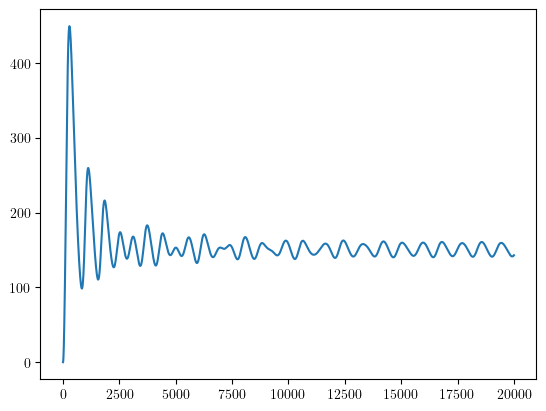

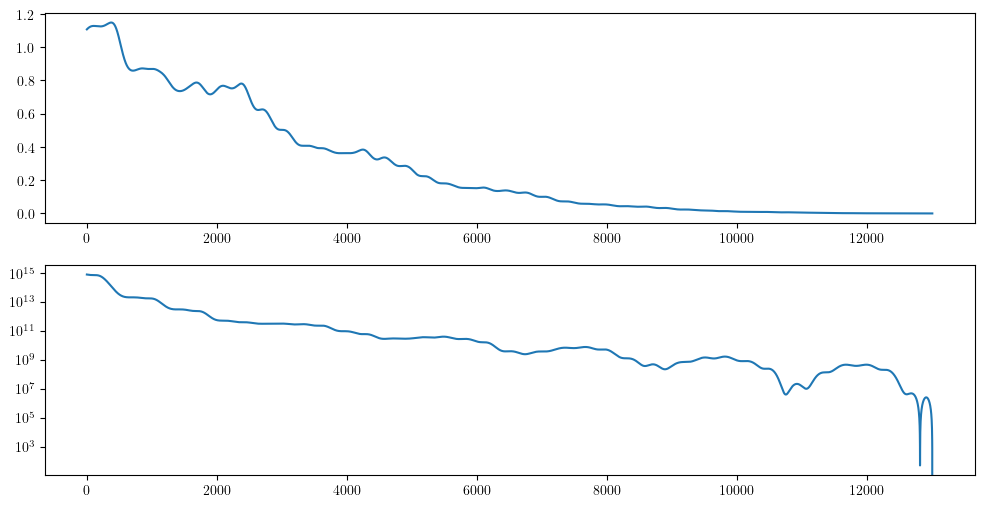

In [271]:
i_period = -1
i_ext_strength = 16

period_system = periods[i_period]
print(period_system, external_strength[i_ext_strength])
window_size = 8*int(period_system / dt)  # Convert period to number of samples

plt.plot(results_osc_strength[i_period, i_ext_strength, :, 0])
fft_matrix_h, freqs, power_per_window_h = compute_and_plot_fft_spectrogram(results_osc_strength[i_period, i_ext_strength, :,0], (dt*60)**-1, window_size, cutoff_freq=1/(40*60))

freq_diff_h, power_diff_h = freqs_differences(fft_matrix_h, power_per_window_h)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(freq_diff_h)


plt.subplot(2, 1, 2)
plt.plot(power_diff_h)
plt.yscale('log')

#### Analysis

75.0 0.0
75.0 0.01
75.0 0.02
75.0 0.03
75.0 0.04
75.0 0.05
115.0 0.0
115.0 0.01
115.0 0.02
115.0 0.03
115.0 0.04
115.0 0.05
135.0 0.0
135.0 0.01
135.0 0.02
135.0 0.03
135.0 0.04
135.0 0.05
175.0 0.0
175.0 0.01
175.0 0.02


C:\Users\kbmcd\AppData\Local\Temp\ipykernel_896\3912768586.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 7.5))


175.0 0.03
175.0 0.04
175.0 0.05


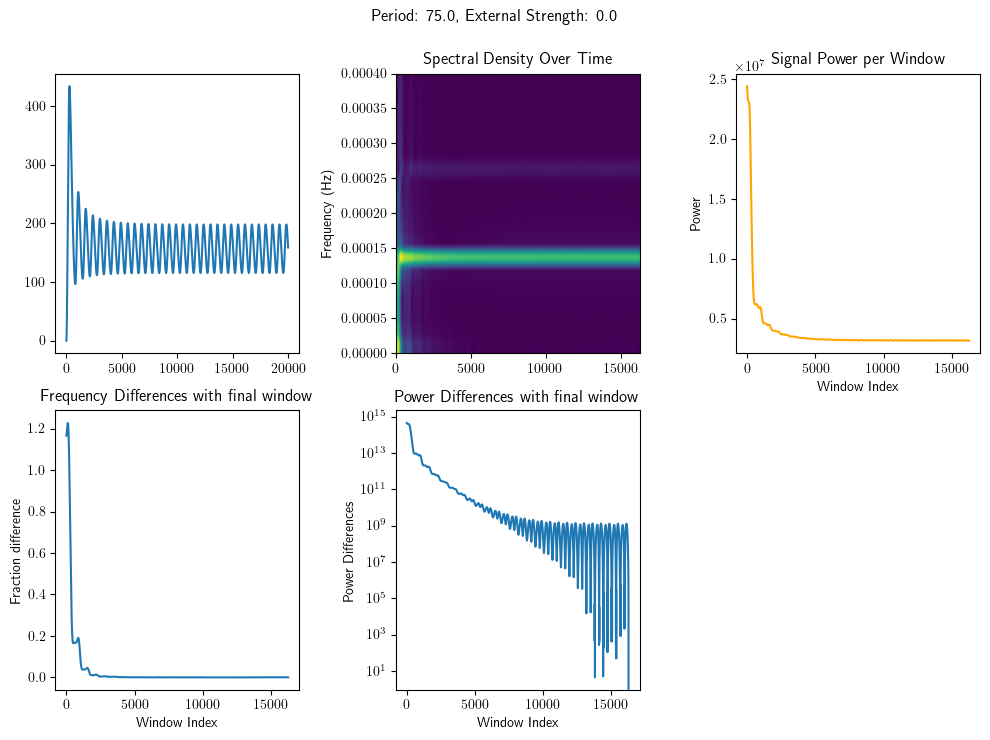

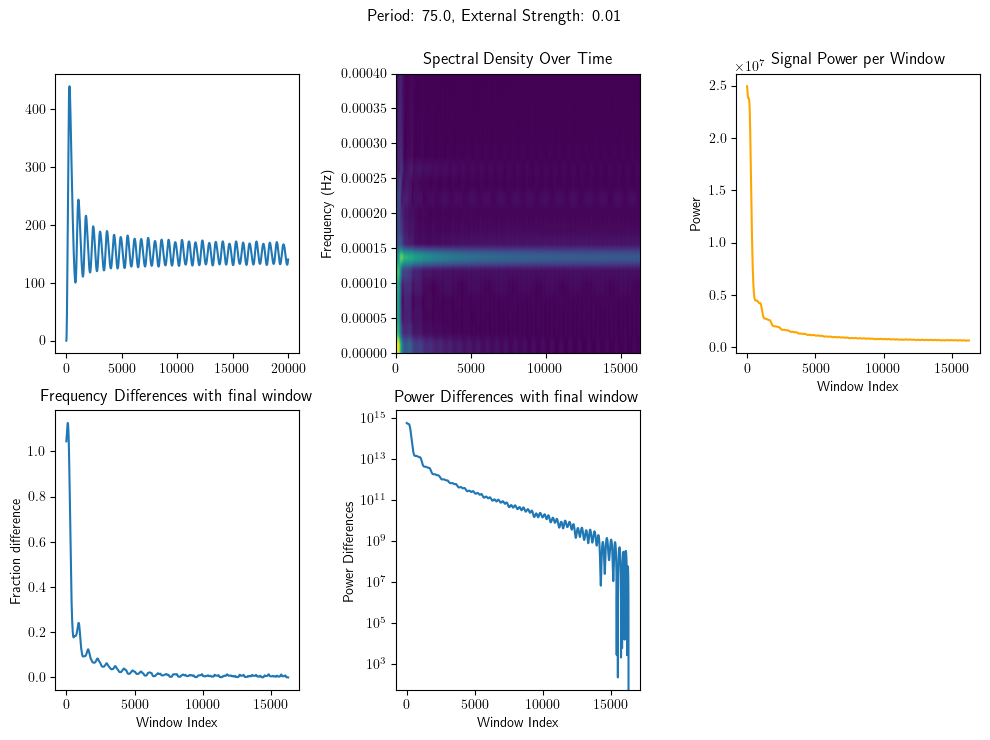

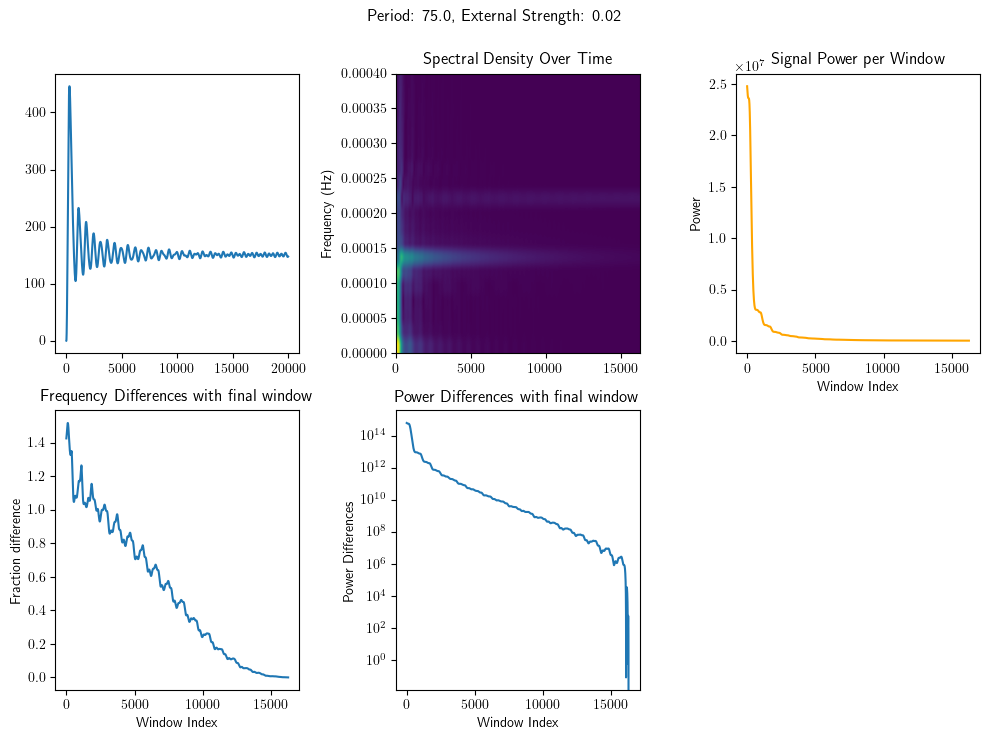

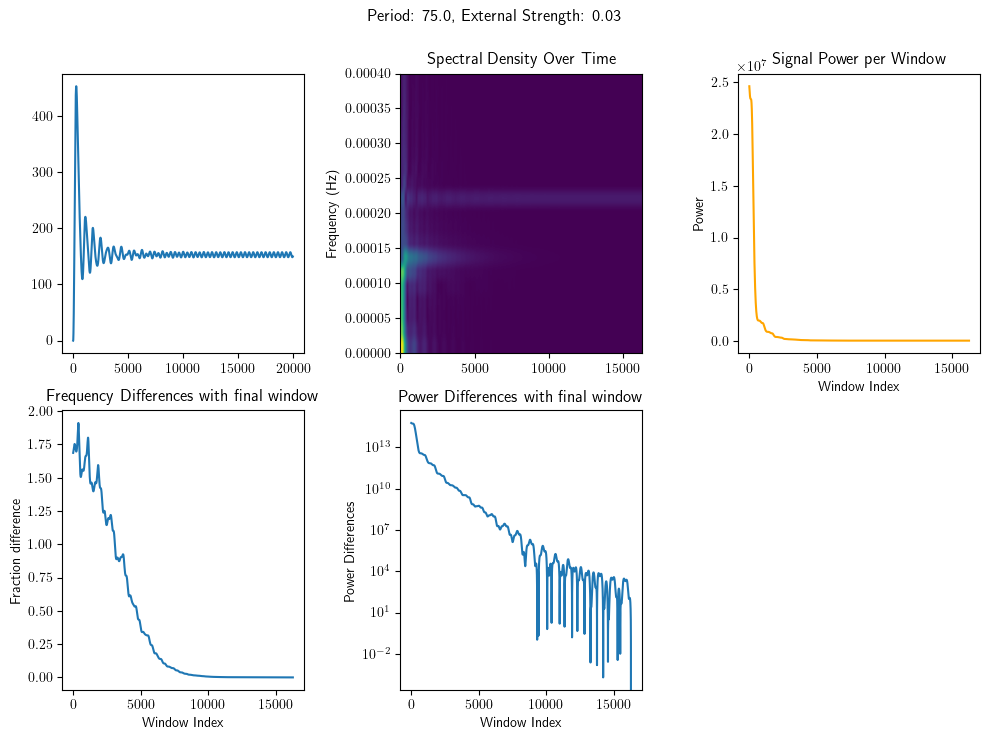

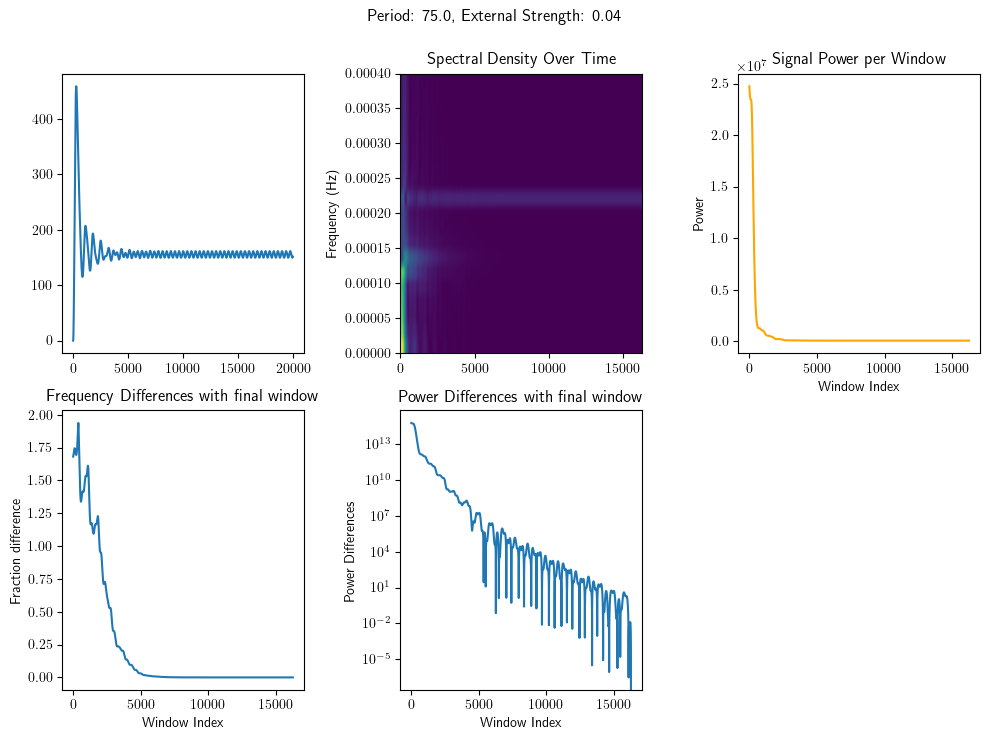

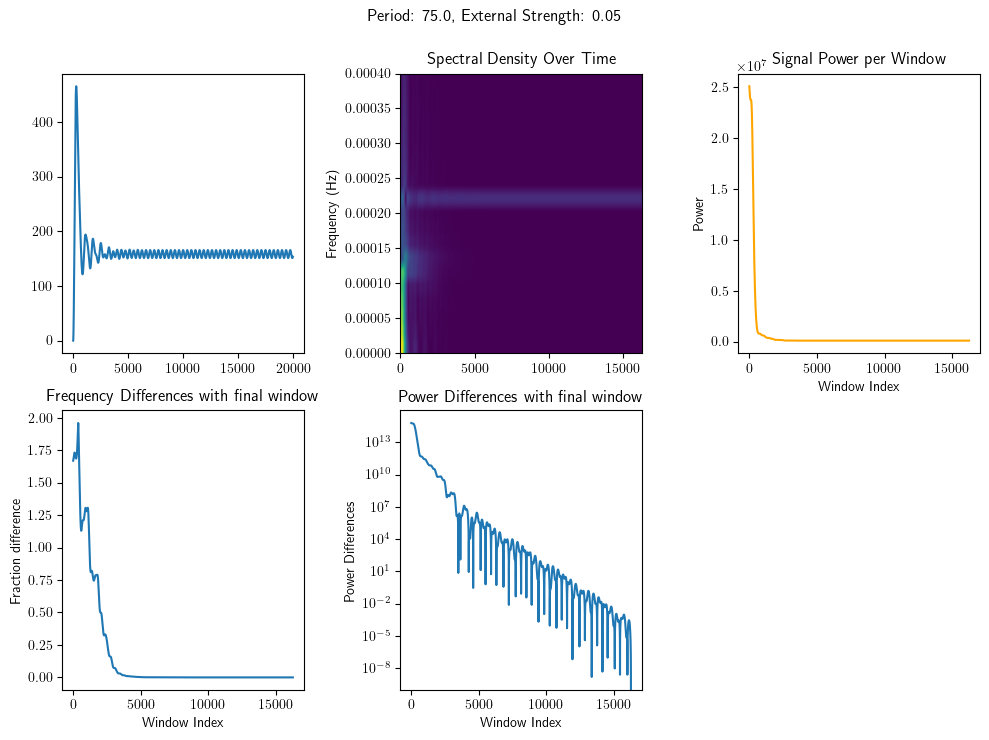

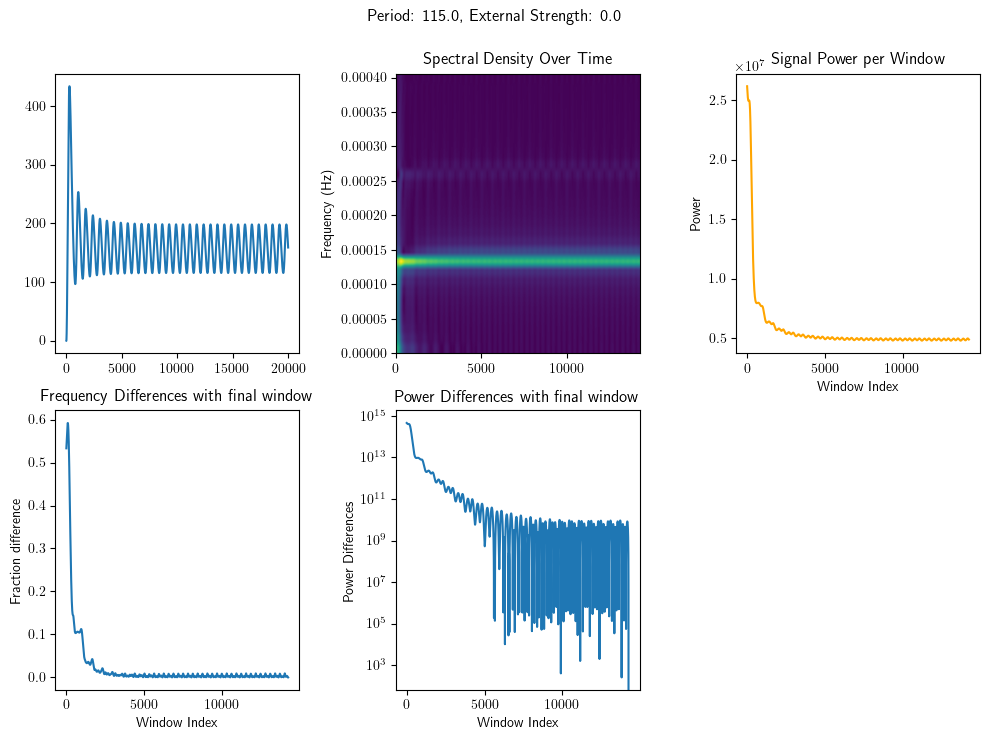

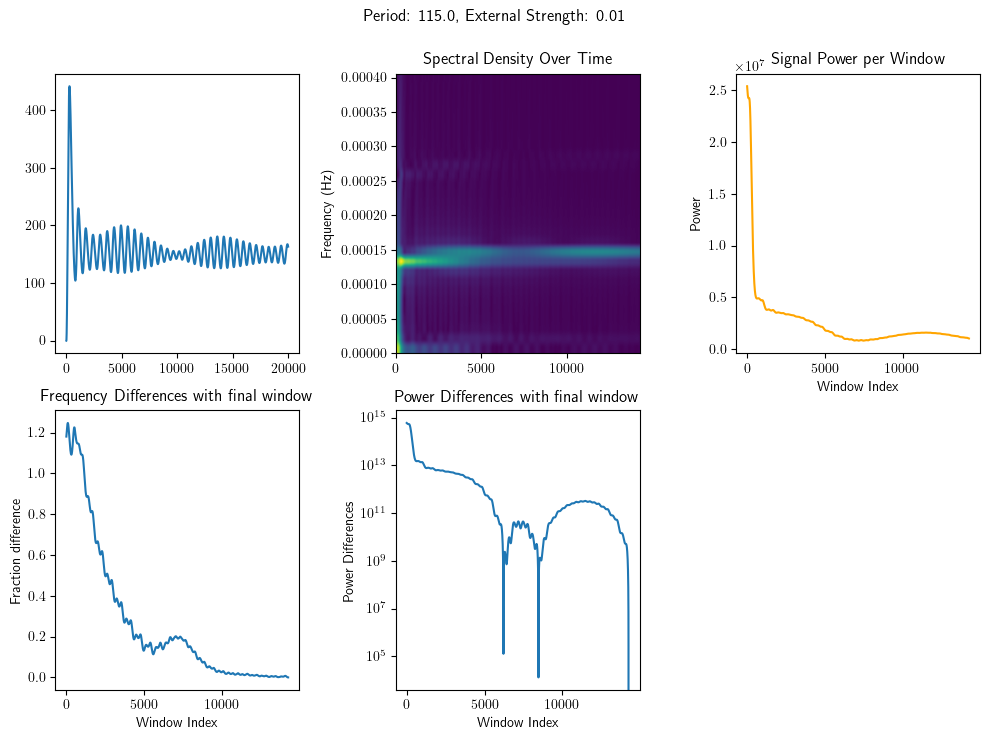

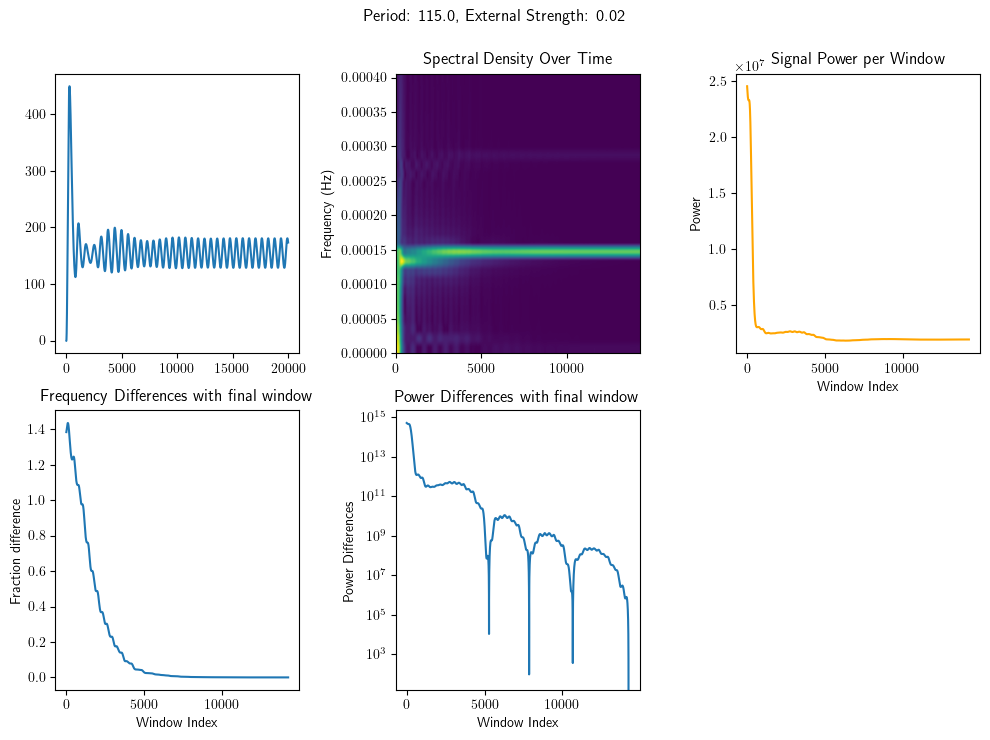

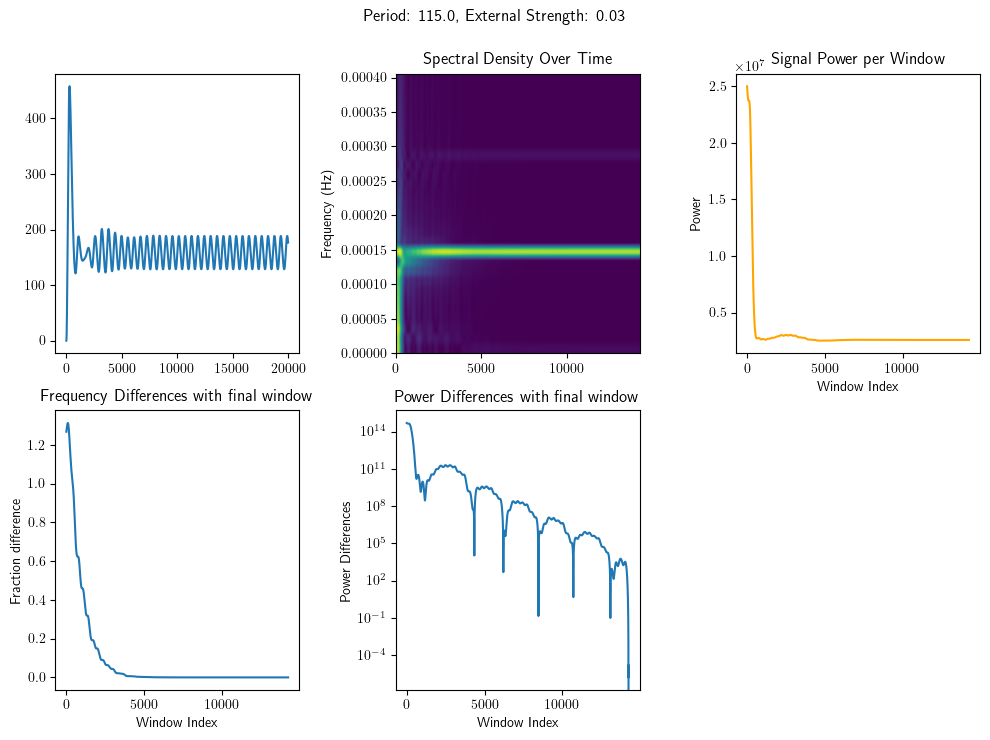

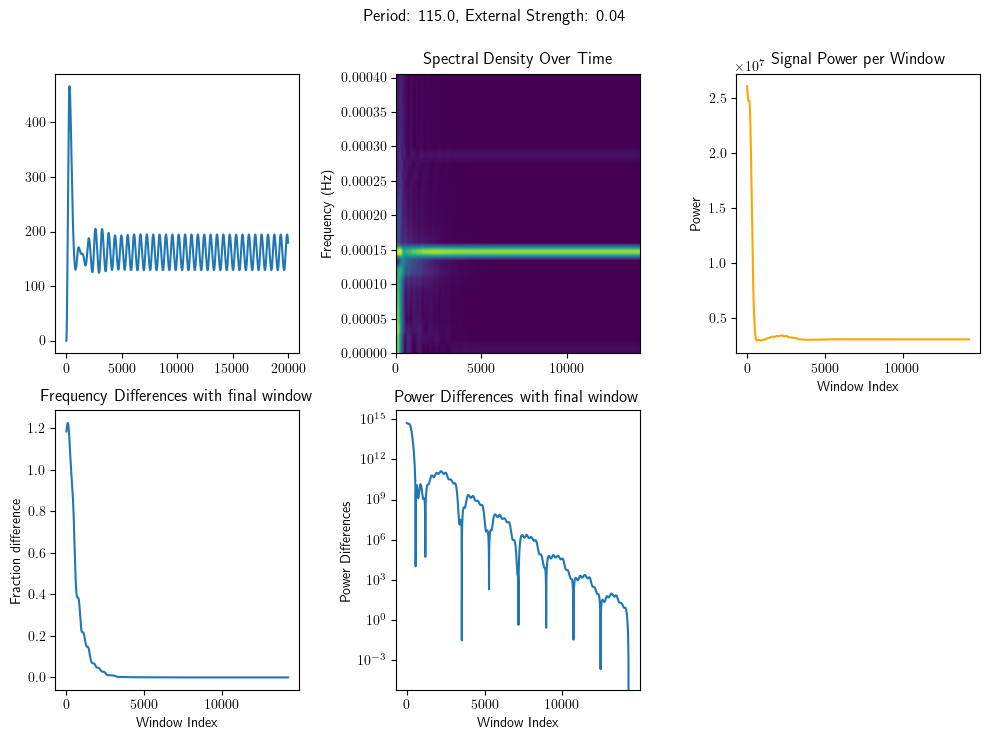

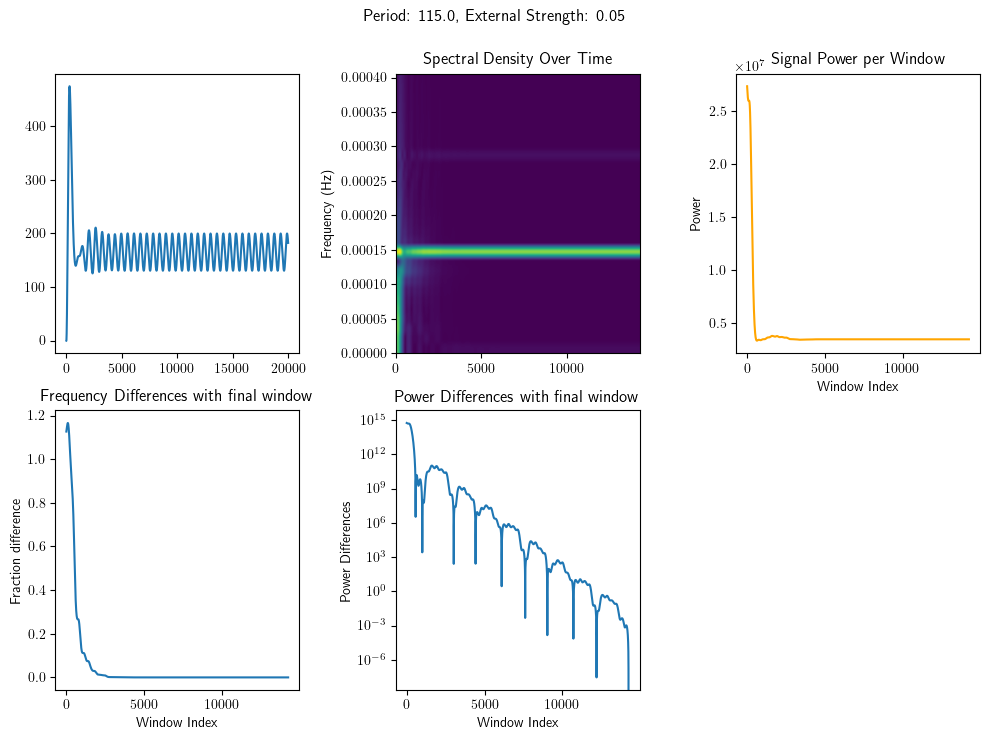

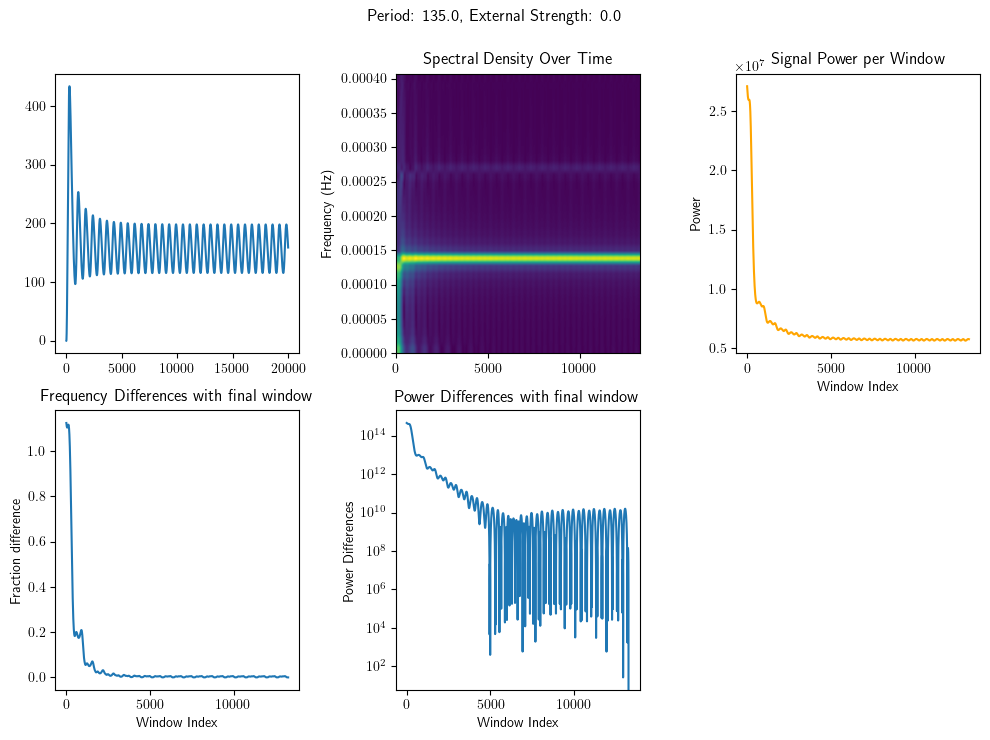

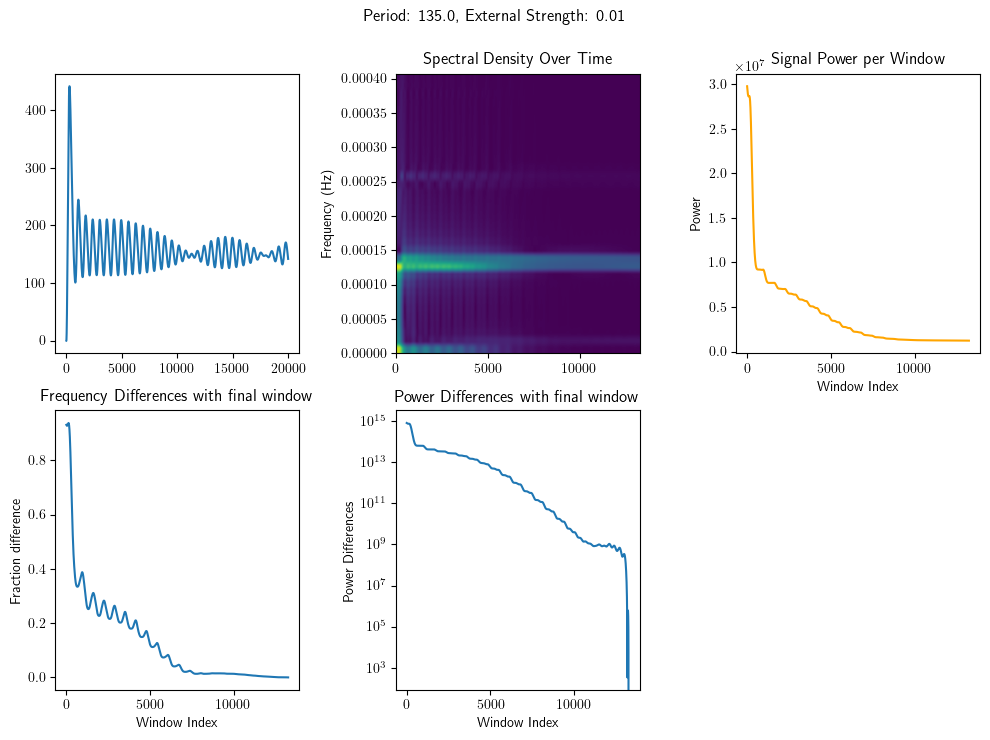

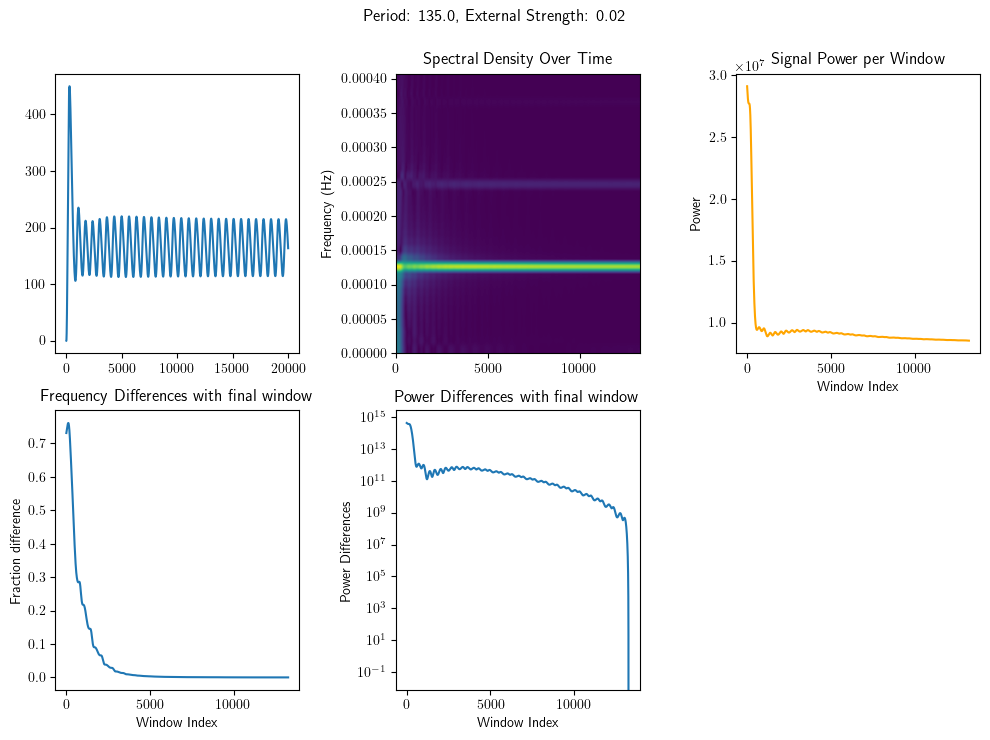

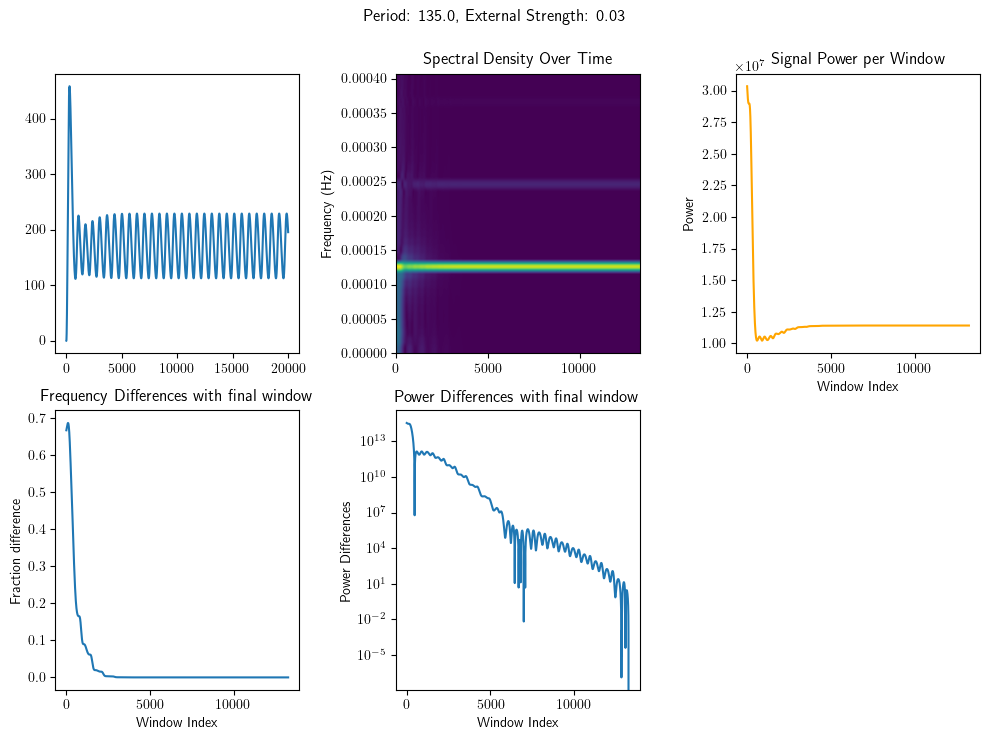

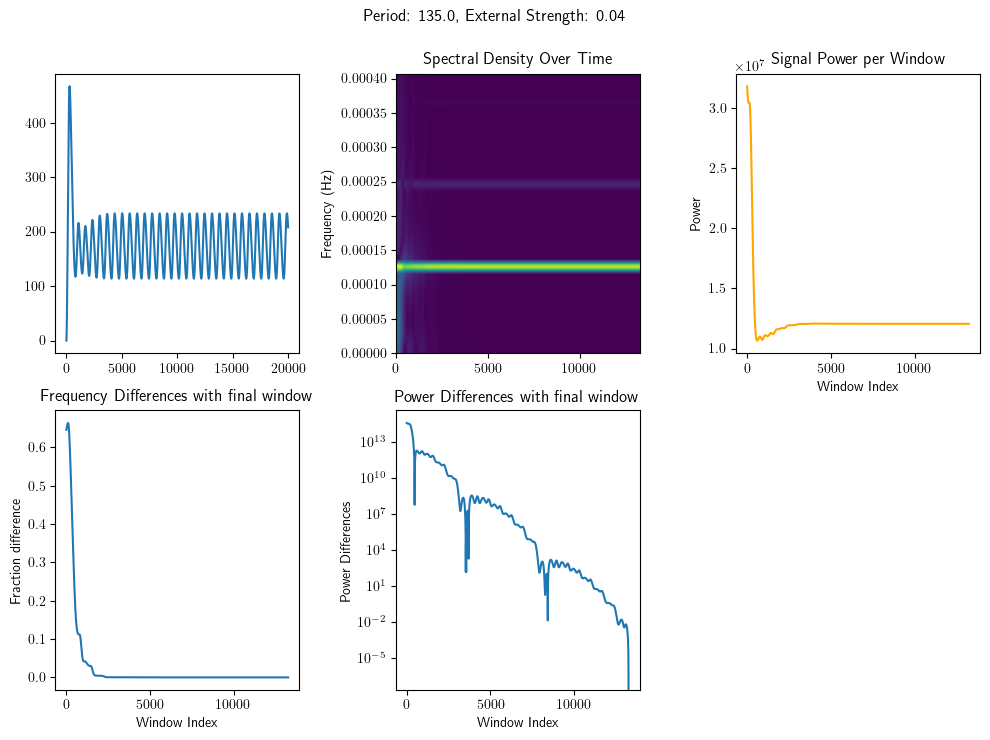

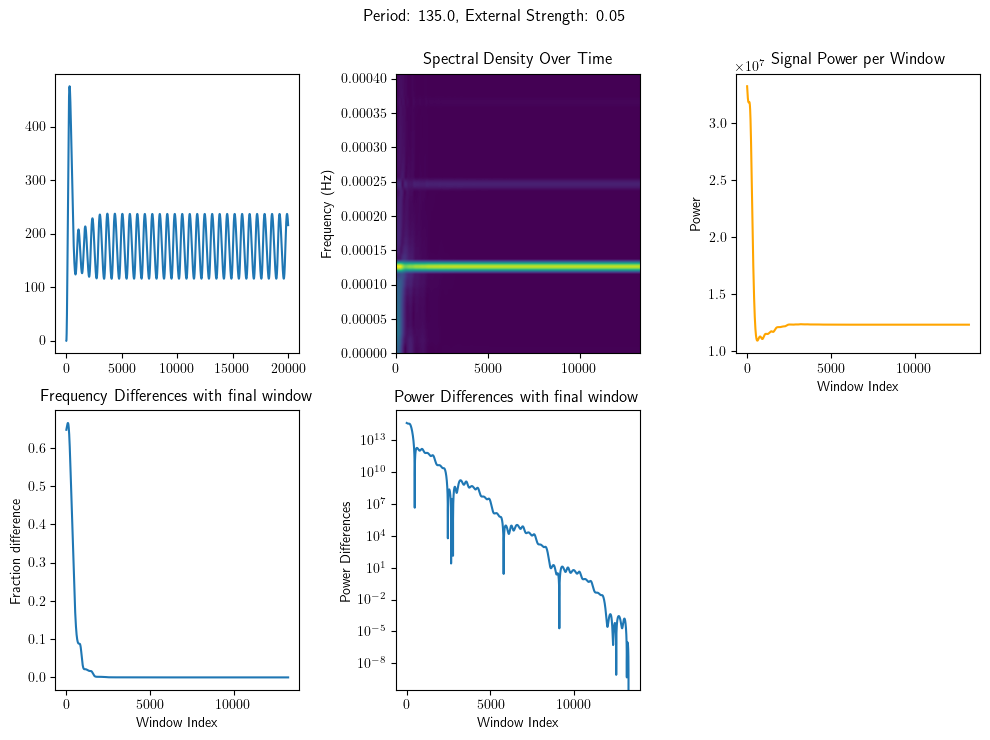

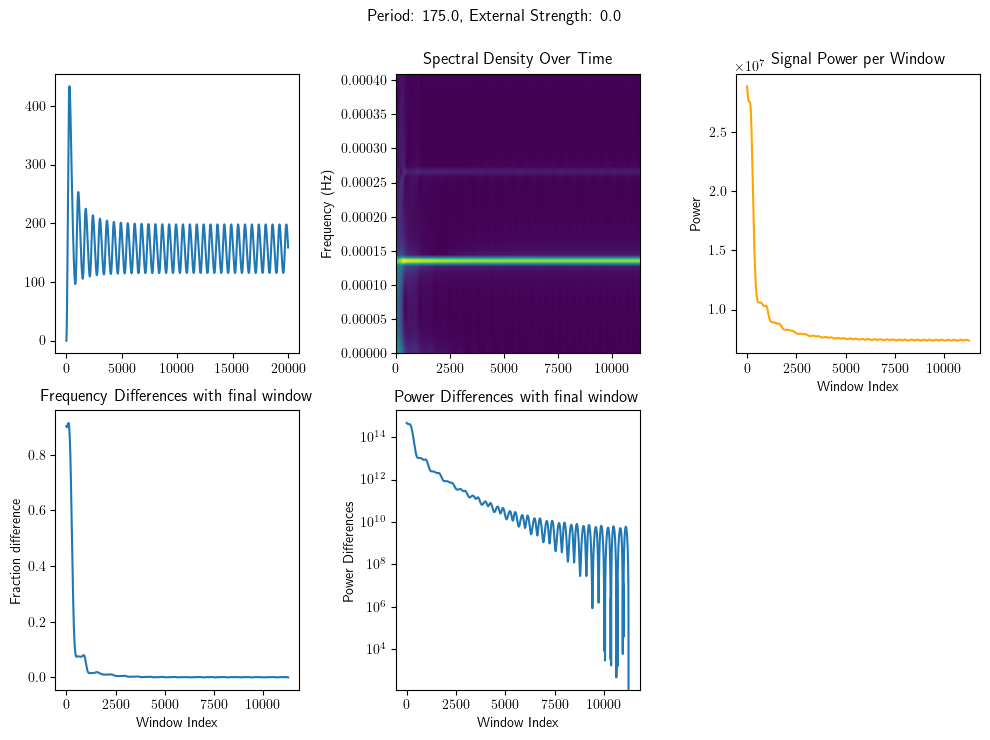

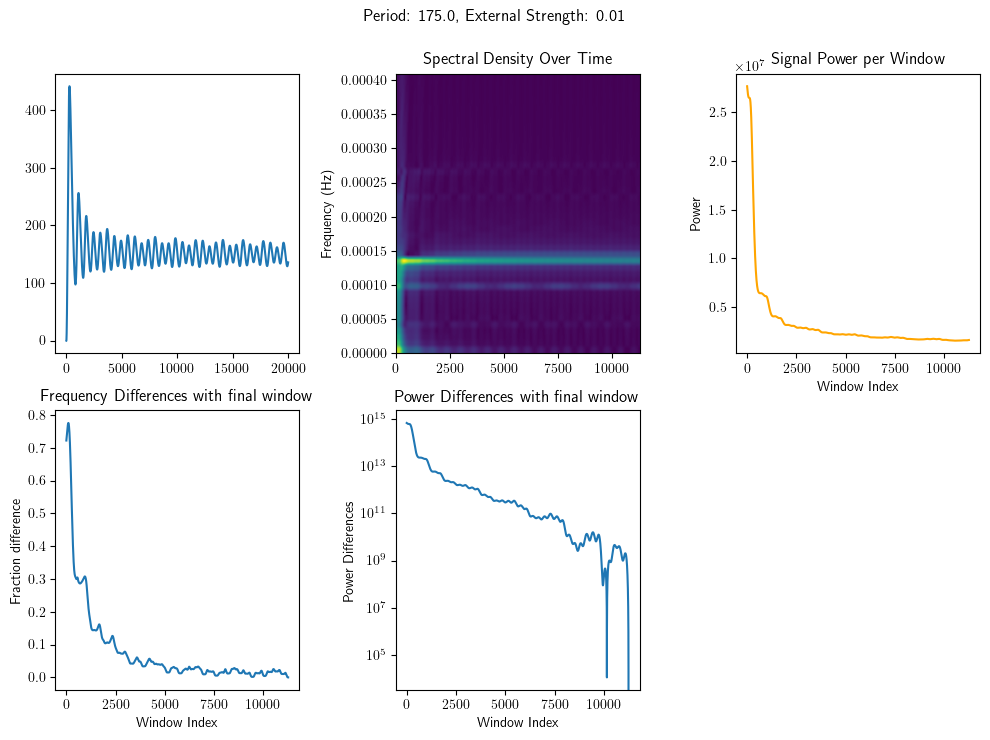

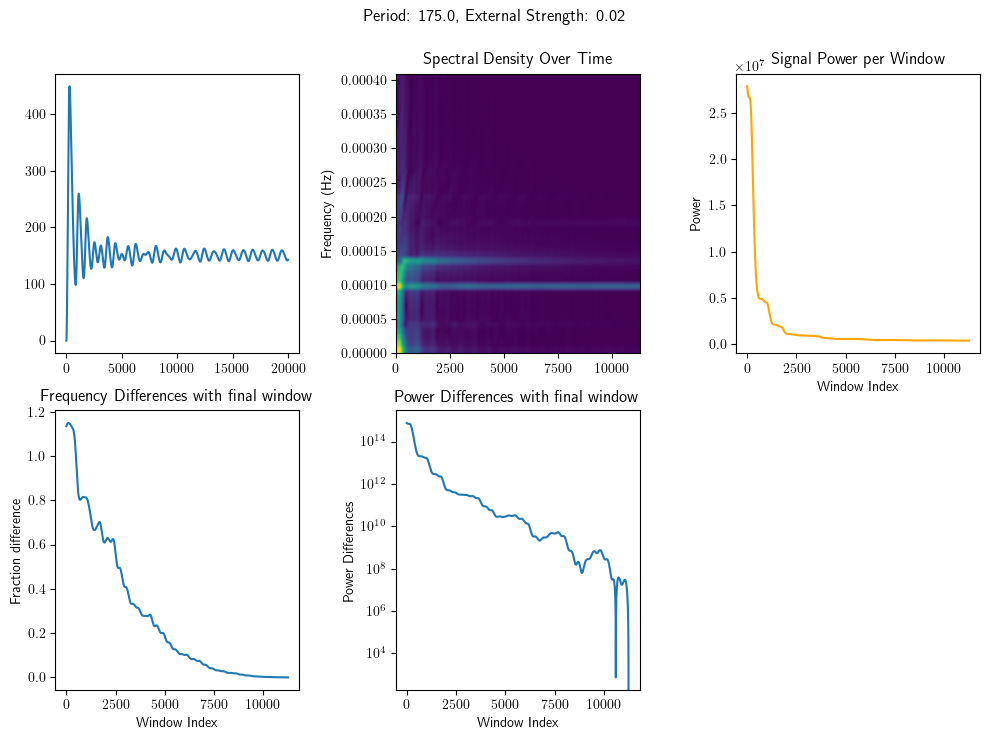

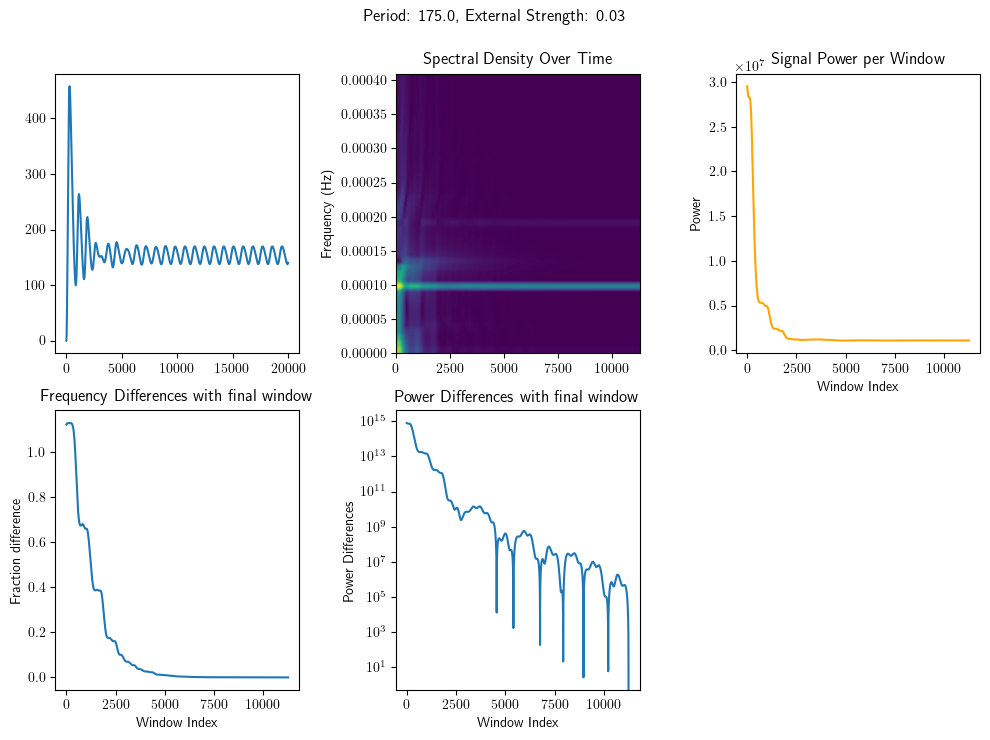

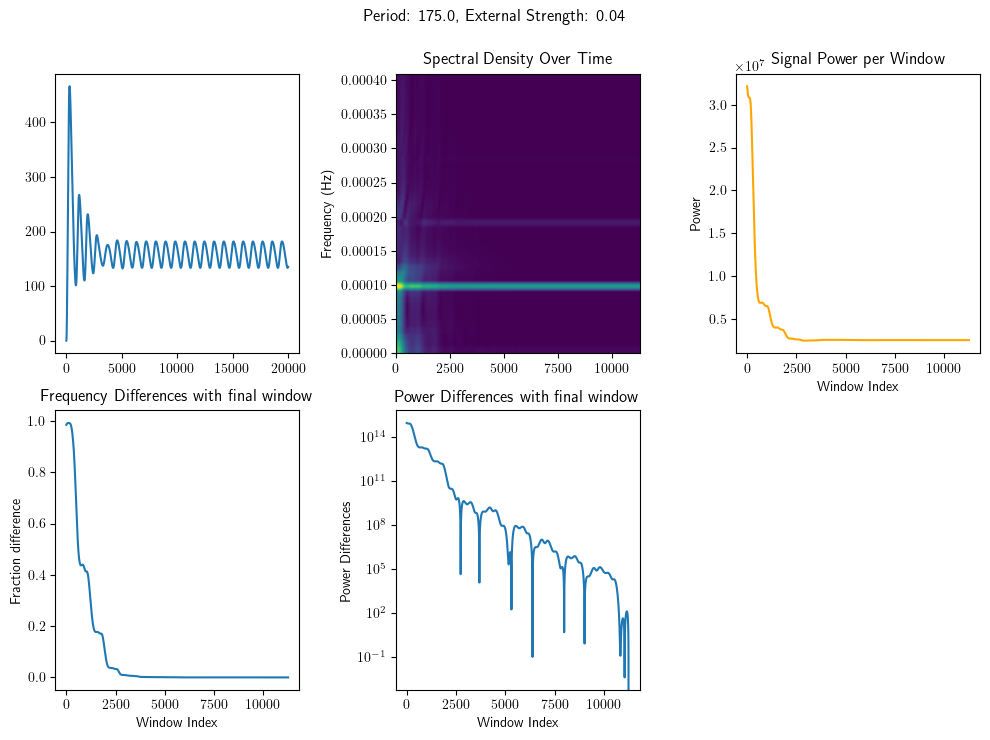

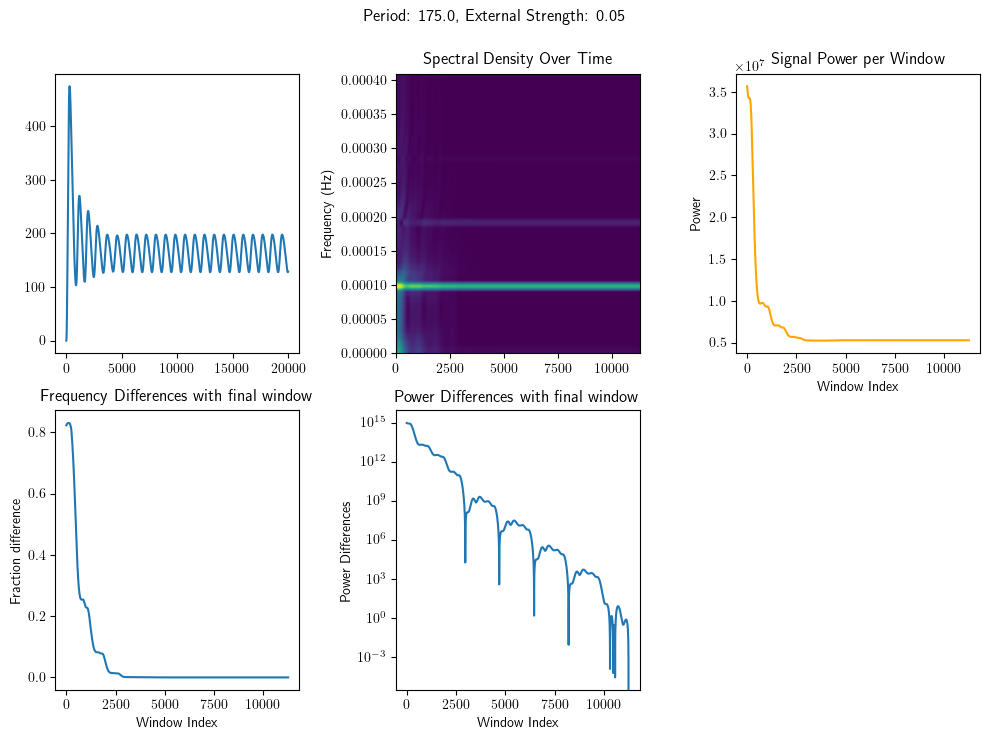

In [279]:
for i_period in range(len(periods)):
    for i_ext_strength in strength_range:
        period_system = periods[i_period]
        print(period_system, external_strength[i_ext_strength])
        window_size = int(10*period_system / dt)  # Convert period to number of samples
        num_windows = results_osc_strength.shape[2] - window_size + 1

        fft_matrix, freqs, power_per_window = compute_and_plot_fft_spectrogram(results_osc_strength[i_period, i_ext_strength, :,0], (dt*60)**-1, window_size, cutoff_freq=1/(40*60))

        freq_diff, power_diff = freqs_differences(fft_matrix, power_per_window)

        #plotting
        plt.figure(figsize=(10, 7.5))
        plt.suptitle(f'Period: {period_system}, External Strength: {external_strength[i_ext_strength]}')
        plt.subplot(2, 3, 1)
        plt.plot(results_osc_strength[i_period, i_ext_strength, :, 0])

        plt.subplot(2, 3, 2)
        extent = [0, num_windows, freqs[0], freqs[-1]]
        plt.imshow(fft_matrix, aspect='auto', origin='lower', extent=extent, cmap='viridis')
        plt.title('Spectral Density Over Time')
        plt.ylabel('Frequency (Hz)')

        # --- Plot signal power per window
        plt.subplot(2, 3, 3)
        plt.plot(power_per_window, color='orange')
        plt.title('Signal Power per Window')
        plt.xlabel('Window Index')
        plt.ylabel('Power')

        plt.subplot(2, 3,  4)
        plt.plot(freq_diff[:])
        plt.ylabel('Fraction difference')
        plt.xlabel('Window Index')
        plt.title('Frequency Differences with final window')

        plt.subplot(2, 3, 5)
        plt.plot(power_diff[:])
        plt.xlabel('Window Index')
        plt.ylabel('Power Differences')
        plt.yscale('log')
        plt.title('Power Differences with final window')
        plt.tight_layout()